In [1]:
import scipy.io
from scipy.interpolate import interp1d
from scipy import signal
import numpy as np
import pylab as plt
import pandas as pd
import xarray as xr
# from isqg import *
from numpy import *
from pylab import *
import gsw
from xrft import detrend
import xrft

###############################################################

/home/tchonang/miniconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
############# compute coherence and phase
import numpy as np
import scipy
from scipy import signal
import scipy.linalg      as linalg
import multitaper.utils      as utils 
import multitaper.mtspec     as spec
from multitaper import MTSpec

class MTCross:

    """
    A class for bi-variate Thomson multitaper estimates. 
    It performs main steps in bi-variate multitaper estimation, 
    including cross-spectrum, coherency and transfer function.
    **Attributes**
    *Parameters*
    npts   : int
        number of points of time series
    nfft   : int
        number of points of FFT. Dafault adds padding. 
    nw     : flaot
        time-bandwidth product
    kspec  : int
        number of tapers to use
    *Time series*
    x      : ndarray [npts]
        time series
    xvar   : float
        variance of time series
    dt     : float
        sampling interval
    *Frequency vector*
    nf     : int
        number of unique frequency points of spectral 
        estimate, assuming real time series
    freq   : ndarray [nfft]
        frequency vector in Hz
    df     : float
        frequncy sampling interval
    *Method*
    iadapt : int
        defines methos to use
        0 - adaptive multitaper
        1 - unweighted, wt =1 for all tapers
        2 - wt by the eigenvalue of DPSS
    wl : float, optional
        water-level for stabilizing deconvolution (transfer function).
        defined as proportion of mean power of Syy
    *Spectral estimates*
    Sxx : ndarray [nfft]
        Power spectrum of x time series
    Syy : ndarray [nfft]
        Power spectrum of y time series
    Sxy : ndarray, complex [nfft]
        Coss-spectrum of x, y series
    cohe  : ndarray [nfft]
        MSC, freq coherence. Normalized (0.0,1.0)
    phase : ndarray [nfft]
        the phase of the cross-spectrum    
    cohy : ndarray, complex [nfft]
        the complex coherency, normalized cross-spectrum 
    trf  : ndarray, compolex [nfft]
        the transfer function Sxy/(Syy_wl), with water-level optional
    se : ndarray [nfft,1] 
        degrees of freedom of estimate
    wt : ndarray [nfft,kspec]
        weights for each eigencoefficient at each frequency
    **Methods**
       * init      : Constructor of the MTCross class
       * mt_deconv : Perform the deconvolution from the self.trf, by iFFT
       * mt_corr   : compute time-domain via iFFT of cross-spectrum, 
                     coherency, and transfer function
    **Modified**
    
	German Prieto
	January 2022
    |
    """

    def __init__(self,x,y,nw=4,kspec=0,dt=1.0,nfft=0,iadapt=0,wl=0.0):
        """
        The constructor of the MTCross class.
        It performs main steps in bi-variate multitaper estimation, 
        including cross-spectrum, coherency and transfer function.
        
        MTCross class variable with attributes described above. 
        **Parameters**
        
        x : MTSpec class, or ndarray [npts,]
            Time series signal x.
            If ndarray, the MTSpec class is created.
        y : MTSpec class, or ndarray [npts,]
            Time series signal x
            If ndarray, the MTSpec class is created.
        nw : float, optional
            time bandwidth product, default = 4
            Only needed if x,y are ndarray
        kspec : int, optional
            number of tapers, default = 2*nw-1
            Only needed if x,y are ndarray
        dt : float, optional
            sampling interval of x, default = 1.0
            Only needed if x,y are ndarray
        nfft : int, optional
            number of frequency points for FFT, allowing for padding
            default = 2*npts+1
            Only needed if x,y are ndarray
        iadapt : int, optional
            defines methos to use, default = 0
            0 - adaptive multitaper
            1 - unweighted, wt =1 for all tapers
            2 - wt by the eigenvalue of DPSS
        wl : float, optional
            water-level for stabilizing deconvolution (transfer function).
            defined as proportion of mean power of Syy
        |
        """
        
        #-----------------------------------------------------
        # Check if input data is MTSPEC class
        #-----------------------------------------------------

        if (type(x) is not type(y)):
            raise ValueError("X and Y are not similar types")

        if (type(x) is np.ndarray):
            
            #-----------------------------------------------------
            # Check dimensions of input vectors
            #-----------------------------------------------------

            xdim  = x.ndim
            ydim  = y.ndim
            if (xdim>2 or ydim>2):
                raise ValueError("Arrays cannot by 3D")
            if (xdim==1):
                x = x[:, np.newaxis]
            if (ydim==1):
                y = y[:, np.newaxis]
            if (x.shape[0] != y.shape[0]):
                raise ValueError('Size of arrays must be the same')
            ndim = x.ndim 
            nx   = x.shape[1]
            ny   = y.shape[1]
            npts = x.shape[0]
            if (nx>1 or ny>1):
                raise ValueError("Arrays must be a single column")

            x = spec.MTSpec(x,nw,kspec,dt,nfft,iadapt=iadapt)
            y = spec.MTSpec(y,nw,kspec,dt,nfft,iadapt=iadapt,vn=x.vn,lamb=x.lamb)

        #------------------------------------------------------------
        # Now, check MTSPEC variables have same sizes
        #------------------------------------------------------------

        if (x.npts != y.npts):
            raise ValueError("npts must coincide")
        if (x.dt != y.dt):
            raise ValueError("dt must coincide")
        if (x.nfft != y.nfft):
            raise ValueError("nfft must coincide")
        if (x.nw != y.nw):
            raise ValueError("NW must coincide")
        if (x.kspec != y.kspec):
            raise ValueError("KSPEC must coincide")

        #------------------------------------------------------------
        # Parameters based on MTSPEC class, not on input
        #------------------------------------------------------------
 
        iadapt = x.iadapt
        dt     = x.dt
        kspec  = x.kspec
        nfft   = x.nfft
        npts   = x.npts
        nw     = x.nw

        #------------------------------------------------------------
        # Create the cross and auto spectra
        #------------------------------------------------------------

        wt = np.minimum(x.wt,y.wt)
        se = utils.wt2dof(wt)

        wt_scale = np.sum(np.abs(wt)**2, axis=1)  # Scale weights to keep power 
        for k in range(kspec):
            wt[:,k] = wt[:,k]/np.sqrt(wt_scale)

        # Weighted Yk's
        dyk_x = np.zeros((nfft,kspec),dtype=complex)
        dyk_y = np.zeros((nfft,kspec),dtype=complex)
        for k in range(kspec):
            dyk_x[:,k] = wt[:,k] * x.yk[:,k]
            dyk_y[:,k] = wt[:,k] * y.yk[:,k]

        # Auto and Cross spectrum
        Sxy      = np.zeros((nfft,1),dtype=complex)
        Sxx      = np.zeros((nfft,1),dtype=float)
        Syy      = np.zeros((nfft,1),dtype=float)
        Sxx[:,0] = np.sum(np.abs(dyk_x)**2, axis=1) 
        Syy[:,0] = np.sum(np.abs(dyk_y)**2, axis=1) 
        Sxy[:,0] = np.sum(dyk_x * np.conjugate(dyk_y),axis=1)

        # Get coherence and phase
        cohe  = np.zeros((nfft,1),dtype=float)
        cohy  = np.zeros((nfft,1),dtype=complex)
        trf   = np.zeros((nfft,1),dtype=complex)
        phase = np.zeros((nfft,1),dtype=float)
        
        w_lev = wl*np.mean(Syy[:,0])
        for i in range(nfft):
            phase[i,0] = np.arctan2(np.imag(Sxy[i,0]),np.real(Sxy[i,0])) 
            cohe[i,0]  = np.abs(Sxy[i,0])**2 / (Sxx[i,0]*Syy[i,0])
            cohy[i,0]  = Sxy[i,0] / np.sqrt(Sxx[i,0]*Syy[i,0])
            trf[i,0]   = Sxy[i,0] / (Syy[i,0]+w_lev)

        phase = phase * (180.0/np.pi)

        #-----------------------------------------------------------------
        # Save all variables in self
        #-----------------------------------------------------------------

        self.freq   = x.freq
        self.dt     = dt
        self.df     = x.df
        self.nf     = x.nf
        self.nw     = nw
        self.kspec  = kspec
        self.nfft   = nfft
        self.npts   = npts
        self.iadapt = iadapt

        self.Sxx    = Sxx
        self.Syy    = Syy
        self.Sxy    = Sxy
        self.cohe   = cohe
        self.cohy   = cohy
        self.trf    = trf
        self.phase  = phase
        self.se     = se
        self.wt     = wt

        del Sxx, Syy, Sxy, cohe, phase, se, wt

    #-------------------------------------------------------------------------
    # Finished INIT mvspec
    #-------------------------------------------------------------------------

    #-------------------------------------------------------------------------
    # Deconvolution
    # TF = Sx/Sy 
    #    although actually we compute Sx*conj(Sy)/(Sy^2)
    # Take the IFFT to convert to the time domain. 
    # Assumes a real deconvolved signal (real input signals). 
    #-------------------------------------------------------------------------

    def mt_corr(self): 

        """
        Compute time-domain via iFFT of cross-spectrum, 
        coherency, and transfer function
 
        Cross spectrum, coherency and transfer function 
        already pre-computed in MTCross.
        **Returns**
        
        xcorr : ndarray [nfft]
            time domain of the transfer function. 
        dcohy : ndarray [nfft]
            time domain of the transfer function. 
        dfun : ndarray [nfft]
            time domain of the transfer function. 
            
        Delay time t=0 in centered in the middle.
        **Notes**
        
        The three correlation-based estimates in the time domain
            - correlation (cross-spectrum)
            - deconvolution (transfer function)
            - norm correlation (coherency)
        Correlation:
            - Sxy = Sx*conj(Sy)
        Deconvolution:
            - Sxy/Sy = Sx*conj(Sy)/Sy^2
        Coherency
            - Sxy/sqrt(Sx*Sy)
        
        | 
        """

        nfft = self.nfft
        cohy = self.cohy
        trf  = self.trf
        xc   = self.Sxy
        phase = self.phase

        xcorr  = scipy.fft.ifft(xc[:,0],nfft) 
        xcorr  = np.real(scipy.fft.fftshift(xcorr))
        xcorr  = xcorr[:,np.newaxis]
        xcorr  = xcorr/float(nfft) 

        dcohy  = scipy.fft.ifft(cohy[:,0],nfft) 
        dcohy  = np.real(scipy.fft.fftshift(dcohy))
        dcohy  = dcohy[:,np.newaxis]
        dcohy  = dcohy/float(nfft) 

        dconv  = scipy.fft.ifft(trf[:,0],nfft) 
        dconv  = np.real(scipy.fft.fftshift(dconv))
        dconv  = dconv[:,np.newaxis]
        dconv  = dconv/float(nfft) 

        return cohy, phase

In [3]:
###################### functions

def compute_geostrophic_velocities(ds):
    """
    Compute geostrophic velocities from SSH data in an xarray Dataset.
    
    Parameters:
    ds (xarray.Dataset): Input dataset containing 'SSH', 'latitude', and 'longitude' DataArrays.
    
    Returns:
    xarray.Dataset: Dataset enriched with geostrophic velocity components 'u_g' and 'v_g'.
    """
    # Constants
    g = 9.81  # Acceleration due to gravity in m/s^2
    omega = 7.2921e-5  # Earth's rotation rate in rad/s
    earth_radius = 6371000  # Earth radius in meters
    
    # Calculate the Coriolis parameter
    ds['f'] = 2 * omega * np.sin(np.deg2rad(ds.latitude))
    
    # Calculate spatial deltas in meters for longitude and latitude
    # Longitude
    longitude_diff = np.diff(ds.longitude, axis=1)
    longitude_diff[longitude_diff > 180] -= 360  # Correct for dateline jump
    longitude_diff[longitude_diff < -180] += 360
    longitude_diff_extended = np.pad(longitude_diff, ((0, 0), (0, 1)), mode='edge')
    dx = xr.DataArray(
        (earth_radius * np.cos(np.deg2rad(ds.latitude)) * (np.pi / 180)) * longitude_diff_extended,
        dims=('num_lines', 'num_pixels'),
        coords={'num_lines': ds.num_lines, 'num_pixels': ds.num_pixels}
    )
    
    # Latitude
    latitude_diff = np.diff(ds.latitude, axis=0)
    latitude_diff_extended = np.pad(latitude_diff, ((0, 1), (0, 0)), mode='edge')
    dy = xr.DataArray(
        (earth_radius * np.pi / 180) * latitude_diff_extended,
        dims=('num_lines', 'num_pixels'),
        coords={'num_lines': ds.num_lines, 'num_pixels': ds.num_pixels}
    )
    
    # Compute gradients of SSH
    ds['grad_ssh_x'] = xr.DataArray(np.gradient(ds.SSH, axis=1) / dx, dims=('num_lines', 'num_pixels'), coords=ds.SSH.coords)
    ds['grad_ssh_y'] = xr.DataArray(np.gradient(ds.SSH, axis=0) / dy, dims=('num_lines', 'num_pixels'), coords=ds.SSH.coords)
    
    # Calculate geostrophic velocities
    ds['u_g'] = -g / ds['f'] * ds['grad_ssh_y']
    ds['v_g'] = g / ds['f'] * ds['grad_ssh_x']
    
    return ds

def filter_butter(data,cutoff,fs, btype,filter_order=4,axis=0):
    """filter signal data using butter filter.
    Parameters
    ==================
    data: N-D array
    cutoff: scalar
        the critical frequency
    fs: scalar
        the sampling frequency
    btype: string
        'low' for lowpass, 'high' for highpass, 'bandpass' for bandpass
    filter_order: scalar
        The order for the filter
    axis: scalar
        The axis of data to which the filter is applied
    Output
    ===============
    N-D array of the filtered data
    """
    import numpy as np
    from scipy import signal
    if btype=='bandpass':
            normal_cutoff=[cutoff[0]/0.5/fs,cutoff[1]/0.5/fs]
    else:
        normal_cutoff=cutoff/(0.5*fs)  #normalize cutoff frequency
    b,a=signal.butter(filter_order, normal_cutoff,btype)
    y = signal.filtfilt(b, a, data, axis=axis)
    return y

In [4]:
# Function to calculate distances and average within radius
def average_within_radius(ds, lon_s2, lat_s2, radius_km, earth_radius_km,variables_to_average):
    # Step 1: Calculate the distance from the target point to all other points
    lat2d = ds['latitude'].values
    lon2d = ds['longitude'].values

    # Convert degrees to radians
    lat_s2_rad = np.radians(lat_s2)
    lon_s2_rad = np.radians(lon_s2)
    lat_rad = np.radians(lat2d)
    lon_rad = np.radians(lon2d)

    # Haversine formula to calculate the great-circle distance
    dlat = lat_rad - lat_s2_rad
    dlon = lon_rad - lon_s2_rad
    a = np.sin(dlat / 2)**2 + np.cos(lat_s2_rad) * np.cos(lat_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distances_km = earth_radius_km * c

    # Step 2: Create a mask for points within the specified radius as an xarray.DataArray
    within_radius = xr.DataArray(distances_km <= radius_km, dims=['num_lines', 'num_pixels'])

    # Step 3: Average or smooth the data within this selection
    # variables_to_average = ['SSH', 'u_g', 'v_g', 'grad_ssh_x', 'grad_ssh_y', 'ut_g']

    # Create a new xarray Dataset to store the averaged results
    averaged_data = {}

    for var in variables_to_average:
        if var in ds:
            # Select data within the radius
            selected_data = ds[var].where(within_radius, drop=True)
            # print('the variable '+var+'is ',selected_data)

            # Average the selected data along the spatial dimensions
            averaged_values = selected_data.mean(dim=['num_lines', 'num_pixels'])

            # Store the averaged values in the new dataset
            averaged_data[var] = averaged_values

    # Create an xarray Dataset from the averaged data
    averaged_ds = xr.Dataset(averaged_data)
    return averaged_ds


In [5]:
mv load_save_sig1000_adj.mat /mnt/flow/swot/Matt_Analysis/calval_orbit_expert_v1.0/science_orbit/adcp


mv: cannot stat 'load_save_sig1000_adj.mat': No such file or directory


### analysis of adcp dataset 

In [6]:

# path = '/mnt/flow/swot/Matt_Analysis/calval_orbit_expert_v1.0/science_orbit/adcp/swot2_vel_gridded.mat'
# mat = scipy.io.loadmat(path)


import h5py

path = '/mnt/flow/swot/Matt_Analysis/calval_orbit_expert_v1.0/science_orbit/adcp/load_save_sig1000_adj.mat'

with h5py.File(path, 'r') as f:
    mat = f['ADCP']
    print(list(mat.keys()))

['clockdrift_status', 'dz', 'info', 'magdec', 'magdec_status', 'shearE', 'shearN', 'time', 'velE', 'velE_adj', 'velN', 'velN_adj']


In [7]:
import h5py

path = '/mnt/flow/swot/Matt_Analysis/calval_orbit_expert_v1.0/science_orbit/adcp/load_save_sig1000_adj.mat'

with h5py.File(path, 'r') as f:
    velE_adj = f['ADCP/velE_adj'][:]
    velN_adj = f['ADCP/velN_adj'][:]
    velE = f['ADCP/velE'][:]
    velN = f['ADCP/velN'][:]
    time = f['ADCP/time'][:,0]
    dz = f['ADCP/dz'][0,:]


In [8]:
# Find valid (non-NaN) indices
valid_time_idx = ~np.isnan(time)
# valid_depth_idx = ~np.isnan(dz)

# Filter all arrays
time_clean = time[valid_time_idx]
# dz_clean = dz[valid_depth_idx]
velE_adj_clean = velE_adj[valid_time_idx, :]
velN_adj_clean = velN_adj[valid_time_idx, :]
velE_clean = velE[valid_time_idx, :]
velN_clean = velN[valid_time_idx, :]

In [9]:
# Create mask for depth levels between 0 m and 100 m
depth_mask = (dz >= 0) & (dz <= 100)

# Apply mask to depth and velocities
dz_selected = dz[depth_mask]
velE_adj_selected = velE_adj_clean[:, depth_mask]
velN_adj_selected = velN_adj_clean[:, depth_mask]

velE_selected = velE_clean[:, depth_mask]
velN_selected = velN_clean[:, depth_mask]

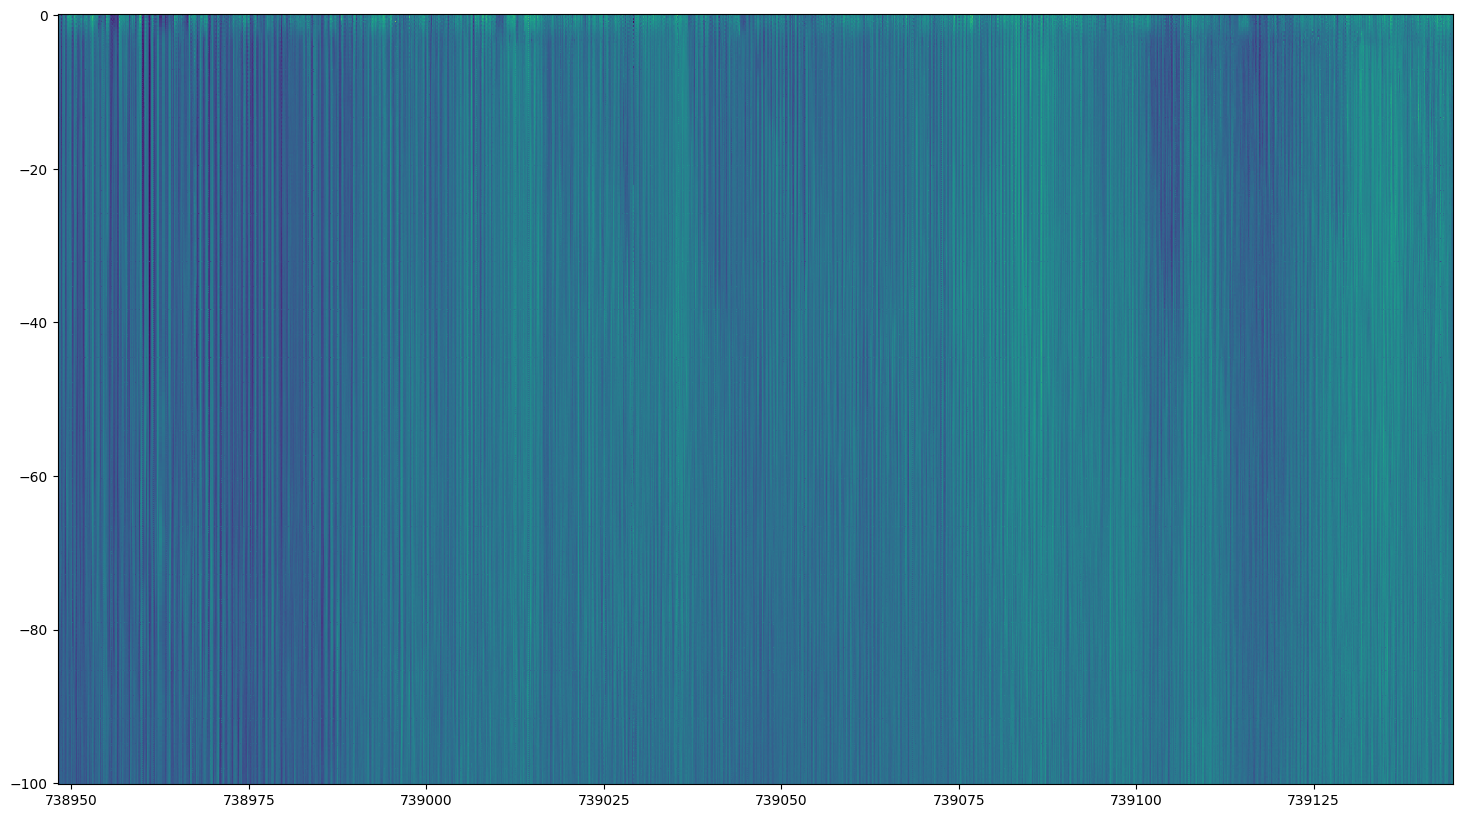

In [10]:
plt.figure(figsize=(18, 10))

plt.pcolor(time_clean, -dz_selected, velE_adj_selected.T)

### put time from num to vect

In [11]:
time_dt = pd.to_datetime(np.squeeze(time_clean)-719529, unit='D').round('s')

In [12]:
time_dt

DatetimeIndex(['2023-03-03 02:14:44', '2023-03-03 02:42:05',
               '2023-03-03 04:06:21', '2023-03-03 04:33:39',
               '2023-03-03 06:30:49', '2023-03-03 08:04:41',
               '2023-03-03 08:36:43', '2023-03-03 10:11:59',
               '2023-03-03 10:44:11', '2023-03-03 12:14:43',
               ...
               '2023-09-14 23:06:01', '2023-09-14 23:38:40',
               '2023-09-15 01:16:58', '2023-09-15 03:23:02',
               '2023-09-15 05:30:13', '2023-09-15 07:07:50',
               '2023-09-15 07:39:37', '2023-09-15 09:18:05',
               '2023-09-15 11:35:08', '2023-09-15 13:15:51'],
              dtype='datetime64[ns]', length=3002, freq=None)

In [13]:
np.diff(dz)

array([0.25, 0.25, 0.25, ..., 0.25, 0.25, 0.25])

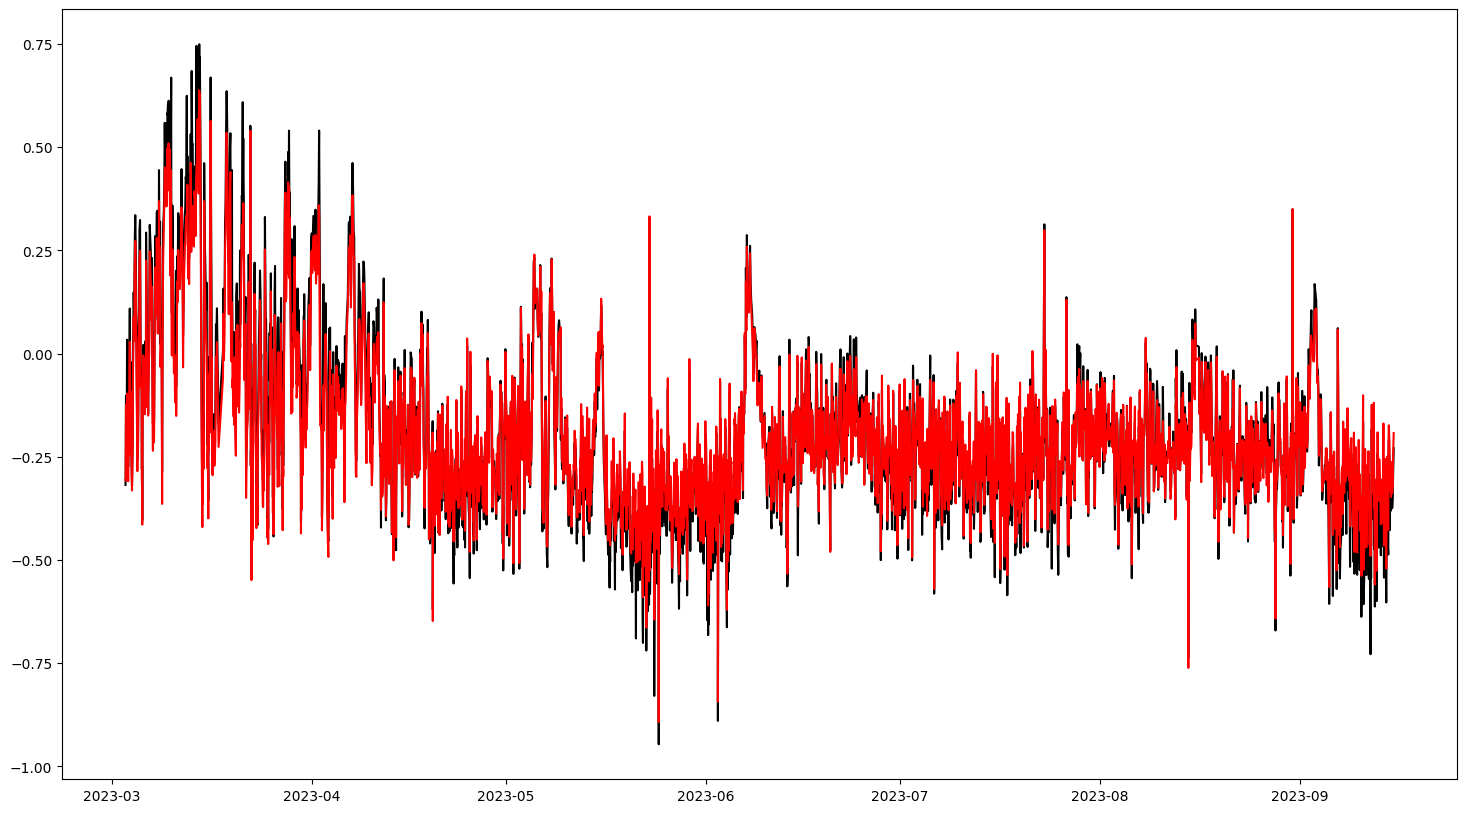

In [14]:
plt.figure(figsize=(18, 10))

plt.plot(time_dt, velN_adj_selected[:,5],'k')
plt.plot(time_dt, velN_selected[:,5],'r')

### create a regular time to interpolate my data on it 

In [15]:
# Define start and end datetime
start_datetime = np.datetime64('2023-04-01T03:00:00')
end_datetime = np.datetime64('2023-07-10T00:00:00')

# Create datetime range with a step of 30 minutes
datetime_range = pd.date_range(start=start_datetime, end=end_datetime, freq='2h')

# Convert the datetime range to a numpy array with dtype='datetime64[ns]'
datetime_array = datetime_range.values.astype('datetime64[ns]')

# create a xarray dataset

In [16]:
# Create Dataset
ds = xr.Dataset(
    data_vars={
        "velE_adj": (("time", "depth"), velE_adj_selected),
        "velN_adj": (("time", "depth"), velN_adj_selected),
        "velE": (("time", "depth"), velE_selected),
        "velN": (("time", "depth"), velN_selected),
    },
    coords={
        "time": time_dt.values.astype('datetime64[ns]'),
        "depth": dz_selected
    }
)

In [17]:
ds.time.values[100:200]

array(['2023-03-09T06:37:13.000000000', '2023-03-09T08:24:26.000000000',
       '2023-03-09T10:09:05.000000000', '2023-03-09T10:41:11.000000000',
       '2023-03-09T12:14:37.000000000', '2023-03-09T12:44:47.000000000',
       '2023-03-09T14:13:05.000000000', '2023-03-09T14:41:54.000000000',
       '2023-03-09T16:08:33.000000000', '2023-03-09T16:37:02.000000000',
       '2023-03-09T18:30:36.000000000', '2023-03-09T20:23:07.000000000',
       '2023-03-09T22:12:13.000000000', '2023-03-09T22:38:51.000000000',
       '2023-03-10T00:25:09.000000000', '2023-03-10T02:12:09.000000000',
       '2023-03-10T02:39:15.000000000', '2023-03-10T04:04:33.000000000',
       '2023-03-10T04:33:55.000000000', '2023-03-10T06:32:01.000000000',
       '2023-03-10T08:31:46.000000000', '2023-03-10T10:28:36.000000000',
       '2023-03-10T12:22:38.000000000', '2023-03-10T14:18:39.000000000',
       '2023-03-10T16:20:46.000000000', '2023-03-10T18:33:17.000000000',
       '2023-03-10T20:17:30.000000000', '2023-03-10

In [18]:
import numpy as np

# Assuming your time array is named time_array
time_array = np.array(ds.time.values, dtype='datetime64[ns]')  # your array

# Compute time difference between consecutive samples
dt = np.diff(time_array) / np.timedelta64(1, 'm')  # in minutes

# Compute median
median_dt_minutes = np.median(dt)

print(f"Median Δt: {median_dt_minutes:.2f} minutes")


Median Δt: 103.38 minutes


In [19]:
ds = ds.interpolate_na(dim='time', method='linear')

In [20]:
ds.velE_adj.values[:,50].min()

-0.5985262

In [21]:
ds_interp_clean = ds.interp(time = datetime_array)
# ds_interp_clean = ds_interp.interpolate_na(dim='time', method='linear')

In [22]:
ds_interp_clean.time.shape

(1199,)

In [23]:
ds_interp_clean.velE_adj[50].values.min()

-0.22007528489504496

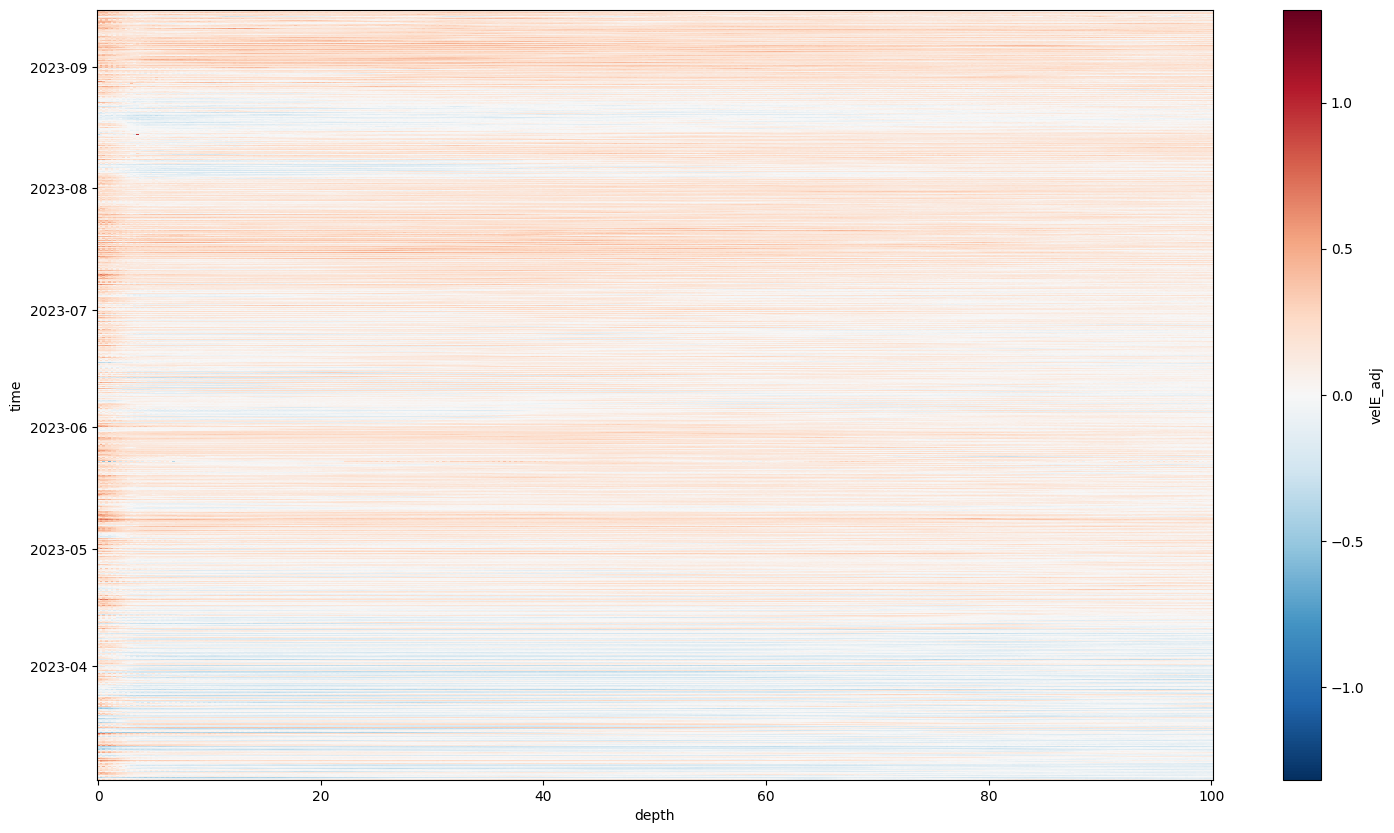

In [24]:
plt.figure(figsize=(18, 10))

ds.velE_adj.plot()

In [25]:
ds_rolling = ds_interp_clean.rolling(time=36, center=True).mean()

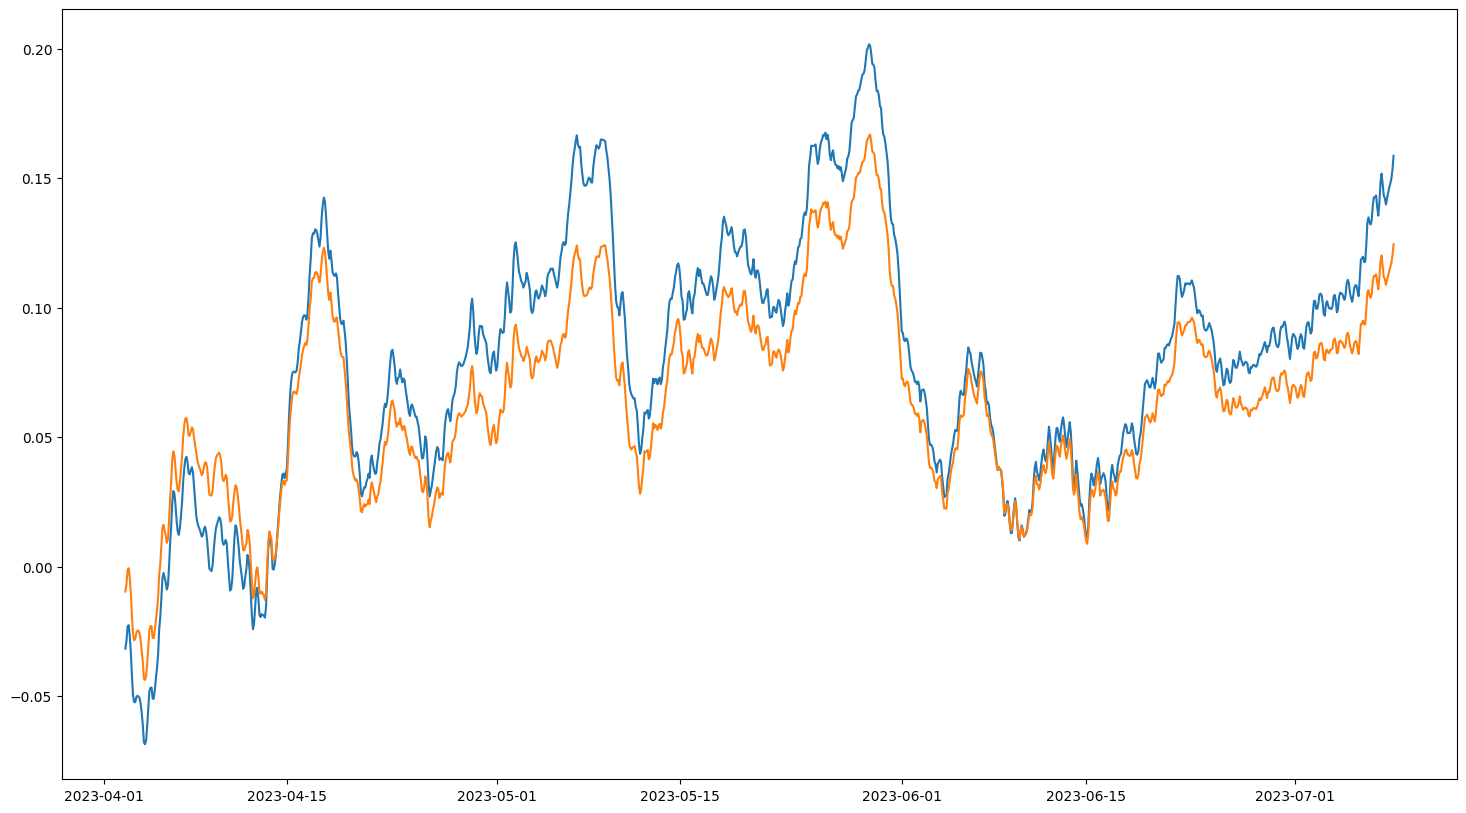

In [26]:
plt.figure(figsize=(18, 10))

plt.plot(ds_rolling.time,ds_rolling.velE_adj[:,10])
plt.plot(ds_rolling.time,ds_rolling.velE[:,10])


In [27]:
from scipy.signal import butter, filtfilt
import xarray as xr

def butter_lowpass_xr(da, cutoff_hours, order=2):
    """
    Apply Butterworth low-pass filter along 'time' dimension of an xarray DataArray.
    """
    dt_hours = 2  # Your data is hourly
    fs = 1 / dt_hours  # Sampling frequency in 1/hour
    fc = 1 / cutoff_hours  # Cutoff frequency in 1/hour
    b, a = butter(order, fc / (0.5 * fs), btype='low')

    # Apply filter along time axis
    filtered = filtfilt(b, a, da.values, axis=0)
    
    # Return as DataArray with same structure
    return xr.DataArray(filtered, dims=da.dims, coords=da.coords, attrs=da.attrs)


In [28]:
6*24

144

In [29]:
cutoff_hours = 48  # For >30h low-pass

ds_filtered = ds_interp_clean.copy()

ds_filtered["velE_filt"] = butter_lowpass_xr(ds_filtered["velE"], cutoff_hours)
ds_filtered["velN_filt"] = butter_lowpass_xr(ds_filtered["velN"], cutoff_hours)
ds_filtered["velE_adj_filt"] = butter_lowpass_xr(ds_filtered["velE_adj"], cutoff_hours)
ds_filtered["velN_adj_filt"] = butter_lowpass_xr(ds_filtered["velN_adj"], cutoff_hours)
ds_filtered = ds_filtered.interpolate_na(dim='time', method='linear')

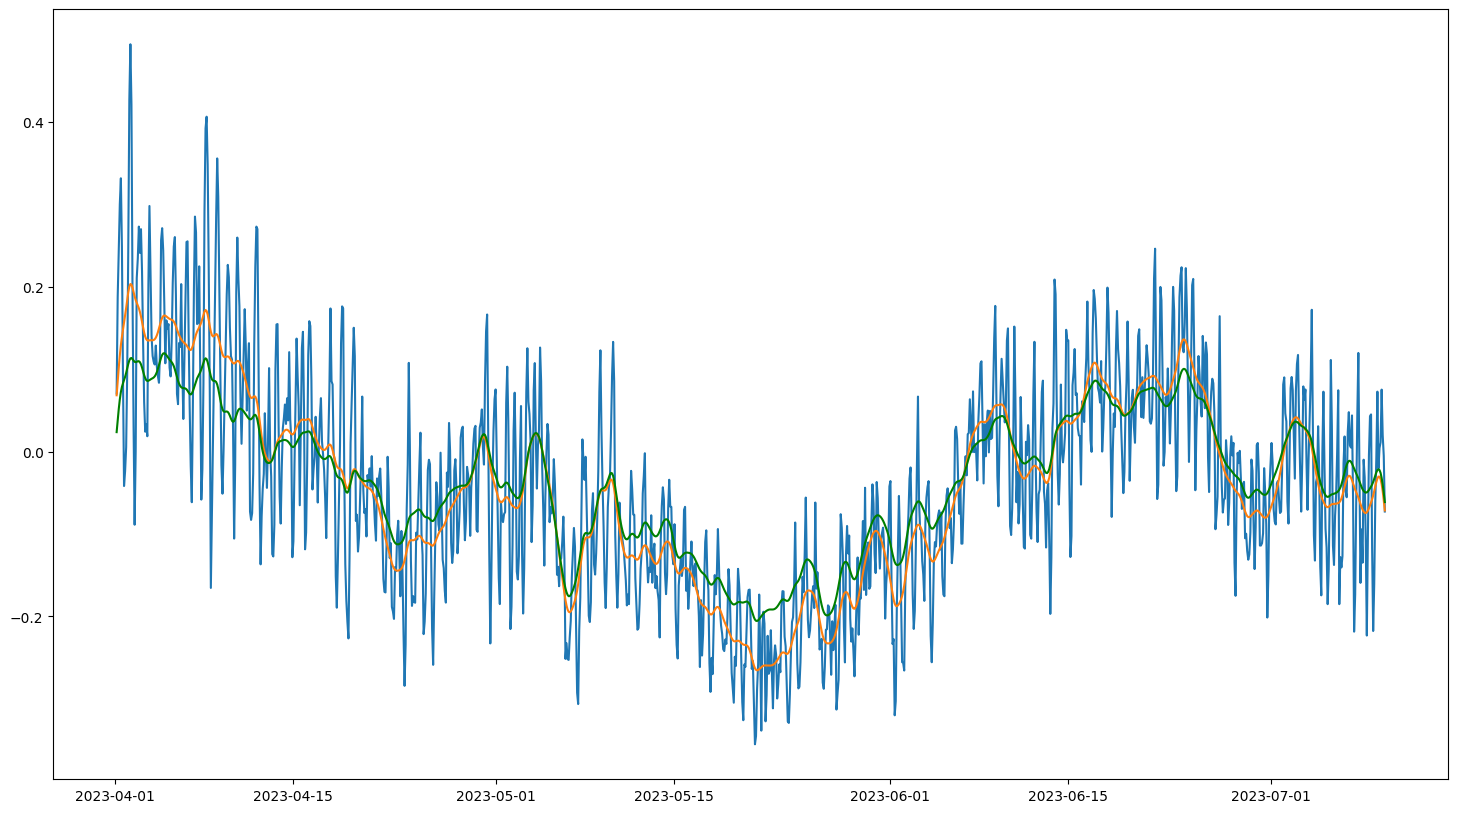

In [30]:
plt.figure(figsize=(18, 10))

plt.plot(ds_filtered.time,ds_filtered.velN_adj[:,50])
plt.plot(ds_filtered.time,ds_filtered.velN_adj_filt[:,50])
plt.plot(ds_filtered.time,ds_filtered.velN_filt[:,50],'g')



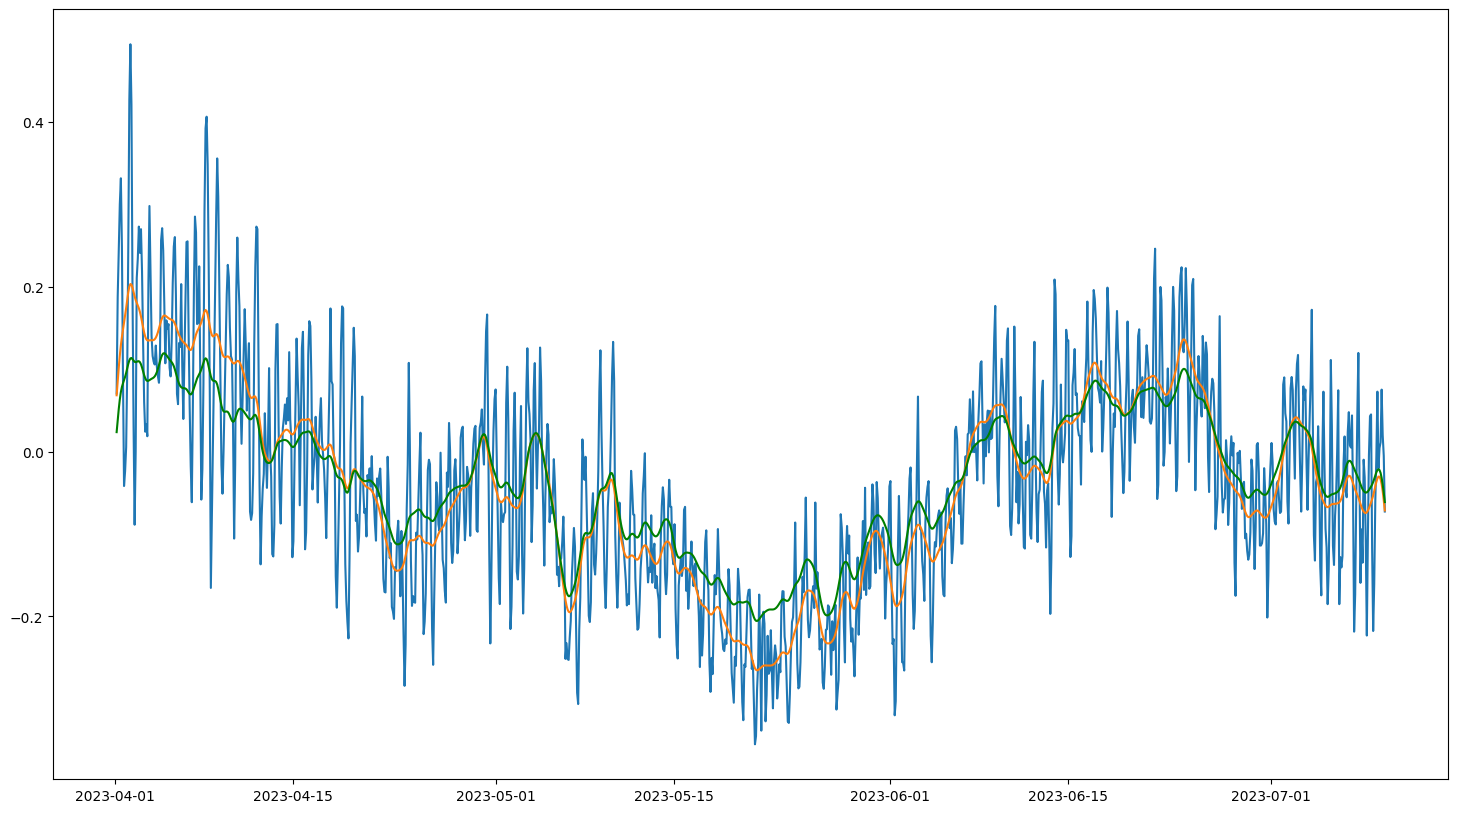

In [31]:
plt.figure(figsize=(18, 10))

plt.plot(ds_filtered.time,ds_filtered.velN_adj[:,50])
plt.plot(ds_filtered.time,ds_filtered.velN_adj_filt[:,50])
plt.plot(ds_filtered.time,ds_filtered.velN_filt[:,50],'g')



In [32]:
dz[50]

12.5

In [33]:
ds_filtered.velE[:,50]

<xarray.DataArray 'velE' (time: 1199)> Size: 10kB
array([-0.18552414, -0.26617124, -0.17822341, ...,  0.18346248,
        0.24182197,  0.18618293])
Coordinates:
    depth    float64 8B 12.5
  * time     (time) datetime64[ns] 10kB 2023-04-01T03:00:00 ... 2023-07-09T23...

In [34]:
ds_filtered

<xarray.Dataset> Size: 31MB
Dimensions:        (depth: 401, time: 1199)
Coordinates:
  * depth          (depth) float64 3kB -0.0 0.25 0.5 0.75 ... 99.5 99.75 100.0
  * time           (time) datetime64[ns] 10kB 2023-04-01T03:00:00 ... 2023-07...
Data variables:
    velE_adj       (time, depth) float64 4MB -0.08496 -0.1012 ... 0.07156
    velN_adj       (time, depth) float64 4MB 0.3288 0.3429 ... 0.05976 0.05954
    velE           (time, depth) float64 4MB -0.05931 -0.07557 ... 0.009385
    velN           (time, depth) float64 4MB 0.2839 0.298 ... 0.06998 0.06977
    velE_filt      (time, depth) float64 4MB -0.05674 -0.07184 ... 0.01076
    velN_filt      (time, depth) float64 4MB 0.2962 0.3168 ... 0.0685 0.06787
    velE_adj_filt  (time, depth) float64 4MB -0.08233 -0.09743 ... 0.07222
    velN_adj_filt  (time, depth) float64 4MB 0.3409 0.3615 ... 0.05836 0.05773

In [35]:
# directory = '/mnt/flow/swot/Matt_Analysis/CNES_L3_CalVal/version_V1_0/swot_aviso/'
# #############3 pass 13 
# nc_swot_13 = xr.open_dataset(directory+'SUBSET_Expert_SWOT_PASS_013_OVER_CALVAL_REGION_V1.0.nc') #xr.open_dataset(directory+'SUBSET_SWOT_UV_PASS_013_OVER_CALVAL_REGION_V1.0.nc')#.sel(time=slice(time_start, time_end))
# nc_avi_13 = xr.open_dataset(directory+'SUBSET_Expert_AVISO_PASS_013_OVER_CALVAL_REGION_V1.0.nc')#'SUBSET_AVISO_UV_PASS_013_OVER_CALVAL_REGION_V1.0.nc')#.sel(time=slice(time_start, time_end))

# #########3 pass 26
# nc_swot_26 = xr.open_dataset(directory+'SUBSET_Expert_SWOT_PASS_026_OVER_CALVAL_REGION_V1.0.nc')#'SUBSET_SWOT_UV_PASS_026_OVER_CALVAL_REGION_V1.0.nc')#.sel(time=slice(time_start, time_end))
# nc_avi_26 = xr.open_dataset(directory+'SUBSET_Expert_AVISO_PASS_026_OVER_CALVAL_REGION_V1.0.nc')#'SUBSET_AVISO_UV_PASS_026_OVER_CALVAL_REGION_V1.0.nc')#.sel(time=slice(time_start, time_end))

In [90]:
directory = '/mnt/flow/swot/Matt_Analysis/CNES_L3_CalVal/version_V1_0/swot_aviso/new/'
#############3 pass 13 
nc_swot_13_filt = xr.open_dataset(directory+'FILT2_20_KM_SUBSET_SWOT_UV_PASS_013_OVER_CALVAL_REGION_V1.0_Stencil.nc')#.sel(time=slice(time_start, time_end))
# nc_swot_13_filt = nc_swot_13_filt.rename({"num_pixels": "temp"})
# nc_swot_13_filt = nc_swot_13_filt.rename({"num_lines": "num_pixels"})
# nc_swot_13_filt = nc_swot_13_filt.rename({"temp": "num_lines"})

nc_swot_13_filt['ut_g_noiseless'] = np.sqrt(nc_swot_13_filt.u_east_noiseless**2+nc_swot_13_filt.v_north_noiseless**2)
#########3 pass 26
nc_swot_26_filt = xr.open_dataset(directory+'FILT2_20_KM_SUBSET_SWOT_UV_PASS_026_OVER_CALVAL_REGION_V1.0_Stencil.nc')#.sel(time=slice(time_start, time_end))
# nc_swot_26_filt = nc_swot_26_filt.rename({"num_pixels": "temp"})
# nc_swot_26_filt = nc_swot_26_filt.rename({"num_lines": "num_pixels"})
# nc_swot_26_filt = nc_swot_26_filt.rename({"temp": "num_lines"})

nc_swot_26_filt['ut_g_noiseless'] = np.sqrt(nc_swot_26_filt.u_east_noiseless**2+nc_swot_26_filt.v_north_noiseless**2)


In [91]:
nc_swot_13_filt

<xarray.Dataset> Size: 648MB
Dimensions:             (timec: 97, num_lines: 863, num_pixels: 69)
Coordinates:
    latitude            (num_lines, num_pixels) float64 476kB ...
    longitude           (num_lines, num_pixels) float64 476kB ...
  * timec               (timec) datetime64[ns] 776B 2023-03-29T08:40:47.66328...
Dimensions without coordinates: num_lines, num_pixels
Data variables: (12/14)
    ssha_hp_20km        (timec, num_lines, num_pixels) float64 46MB ...
    ugosa_hp_20km       (timec, num_lines, num_pixels) float64 46MB ...
    vgosa_hp_20km       (timec, num_lines, num_pixels) float64 46MB ...
    ssha_lp_20km        (timec, num_lines, num_pixels) float64 46MB ...
    ugosa_lp_20km       (timec, num_lines, num_pixels) float64 46MB ...
    vgosa_lp_20km       (timec, num_lines, num_pixels) float64 46MB ...
    ...                  ...
    uc_east_noiseless   (timec, num_lines, num_pixels) float64 46MB ...
    vc_north_noiseless  (timec, num_lines, num_pixels) float64 46MB ...
    zeta_csiro          (timec, num_lines, num_pixels) float64 46MB ...
    sr_csiro            (timec, num_lines, num_pixels) float64 46MB ...
    OW_csiro            (timec, num_lines, num_pixels) float64 46MB ...
    ut_g_noiseless      (timec, num_lines, num_pixels) float64 46MB nan ... nan

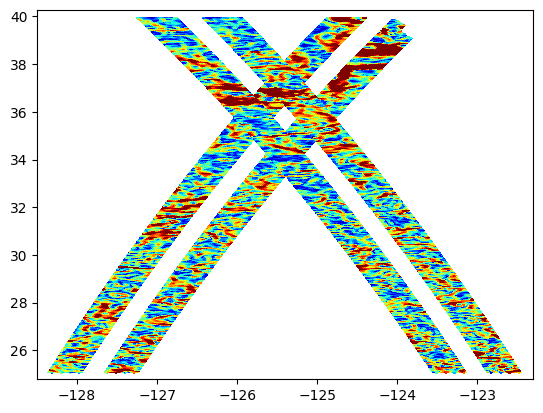

In [92]:
plt.pcolor(nc_swot_13_filt.longitude, nc_swot_13_filt.latitude,nc_swot_13_filt.ut_g_noiseless[50], vmin=0, vmax=.35, cmap='jet')
plt.pcolor(nc_swot_26_filt.longitude, nc_swot_26_filt.latitude,nc_swot_26_filt.ut_g_noiseless[51], vmin=0, vmax=.35, cmap='jet')

## 4 subplot

In [93]:
path = '/mnt/flow/swot/Matt_Analysis/calval_orbit_expert_v1.0/calval_v_2/cube/'
nc_avi = xr.open_dataset(path+'CCS_DUACS_U_V_computed_from_adt.nc').sel(time=slice('2023-04-01', '2023-07-10'))

nc_avi_13 = nc_avi.interp(time = nc_swot_13_filt.timec,longitude = nc_swot_13_filt.longitude, latitude = nc_swot_13_filt.latitude)

nc_avi_26 = nc_avi.interp(time = nc_swot_26_filt.timec,longitude = nc_swot_26_filt.longitude, latitude = nc_swot_26_filt.latitude)

In [94]:
nc_avi

<xarray.Dataset> Size: 40MB
Dimensions:     (time: 101, latitude: 56, longitude: 80)
Coordinates:
  * latitude    (latitude) float32 224B 28.12 28.38 28.62 ... 41.38 41.62 41.88
  * longitude   (longitude) float32 320B -134.9 -134.6 -134.4 ... -115.4 -115.1
  * time        (time) datetime64[ns] 808B 2023-04-01 2023-04-02 ... 2023-07-10
Data variables: (12/15)
    adt         (time, latitude, longitude) float32 2MB ...
    err_sla     (time, latitude, longitude) float32 2MB ...
    err_ugosa   (time, latitude, longitude) float32 2MB ...
    err_vgosa   (time, latitude, longitude) float32 2MB ...
    flag_ice    (time, latitude, longitude) float32 2MB ...
    sla         (time, latitude, longitude) float32 2MB ...
    ...          ...
    vgosa       (time, latitude, longitude) float64 4MB ...
    ucgosa      (time, latitude, longitude) float64 4MB ...
    vcgosa      (time, latitude, longitude) float64 4MB ...
    zeta_csiro  (time, latitude, longitude) float64 4MB ...
    sr_csiro    (time, latitude, longitude) float64 4MB ...
    OW_csiro    (time, latitude, longitude) float64 4MB ...
Attributes:
    Conventions:       CF-1.11
    title:             NRT merged all satellites Global Ocean Gridded SSALTO/...
    institution:       CLS, CNES
    source:            Altimetry measurements
    history:           2023-11-24 00:53:07Z: Creation
    contact:           servicedesk.cmems@mercator-ocean.eu
    references:        http://marine.copernicus.eu
    comment:           Sea Surface Height measured by Altimetry and derived v...
    subset:source:     ARCO data downloaded from the Marine Data Store using ...
    subset:productId:  SEALEVEL_GLO_PHY_L4_NRT_008_046
    subset:datasetId:  cmems_obs-sl_glo_phy-ssh_nrt_allsat-l4-duacs-0.25deg_P...
    subset:date:       2024-04-01T20:59:49.254Z

In [95]:
nc_swot_13_filt

<xarray.Dataset> Size: 648MB
Dimensions:             (timec: 97, num_lines: 863, num_pixels: 69)
Coordinates:
    latitude            (num_lines, num_pixels) float64 476kB 25.01 ... 39.99
    longitude           (num_lines, num_pixels) float64 476kB -128.5 ... -123.4
  * timec               (timec) datetime64[ns] 776B 2023-03-29T08:40:47.66328...
Dimensions without coordinates: num_lines, num_pixels
Data variables: (12/14)
    ssha_hp_20km        (timec, num_lines, num_pixels) float64 46MB ...
    ugosa_hp_20km       (timec, num_lines, num_pixels) float64 46MB ...
    vgosa_hp_20km       (timec, num_lines, num_pixels) float64 46MB ...
    ssha_lp_20km        (timec, num_lines, num_pixels) float64 46MB ...
    ugosa_lp_20km       (timec, num_lines, num_pixels) float64 46MB ...
    vgosa_lp_20km       (timec, num_lines, num_pixels) float64 46MB ...
    ...                  ...
    uc_east_noiseless   (timec, num_lines, num_pixels) float64 46MB ...
    vc_north_noiseless  (timec, num_lines, num_pixels) float64 46MB ...
    zeta_csiro          (timec, num_lines, num_pixels) float64 46MB ...
    sr_csiro            (timec, num_lines, num_pixels) float64 46MB ...
    OW_csiro            (timec, num_lines, num_pixels) float64 46MB ...
    ut_g_noiseless      (timec, num_lines, num_pixels) float64 46MB nan ... nan

## average swot avison on a cycle aroud s2 position

In [96]:
# Define the point of interest and radius
lon_s2 = -125.044
lat_s2 = 35.917
radius_km = 5  # Radius in kilometers
radius_km1 = 5  # Radius in kilometers

# Earth's radius in kilometers
earth_radius_km = 6371.0
variables_swot = ['u_east_noiseless', 'v_north_noiseless','uc_east_noiseless', 'vc_north_noiseless']#['u_g', 'v_g', 'u_east_noiseless', 'v_north_noiseless','ut_g','SSHA','SSHA_noiseless']#['ugosa', 'vgosa']#['u_g', 'v_g', 'u_g_noiseless', 'v_g_noiseless','ut_g']
# variables_swot = ['ug_east_noiseless', 'vg_north_noiseless', 'ucg_east_noiseless', 'vcg_north_noiseless','ut_g','SSHA','SSHA_noiseless']#['ugosa', 'vgosa']#['u_g', 'v_g', 'u_g_noiseless', 'v_g_noiseless','ut_g']

variables_avi = ['ugosa', 'vgosa']

# Apply the function to both datasets

########################################################### pass 13
averaged_nc_swot_13 = average_within_radius(nc_swot_13_filt, lon_s2, lat_s2, radius_km, earth_radius_km, variables_swot)
averaged_nc_avi_13 = average_within_radius(nc_avi_13, lon_s2, lat_s2, radius_km, earth_radius_km,variables_avi)

############################################################ pass 26
averaged_nc_swot_26 = average_within_radius(nc_swot_26_filt, lon_s2, lat_s2, radius_km, earth_radius_km, variables_swot)
averaged_nc_avi_26 = average_within_radius(nc_avi_26, lon_s2, lat_s2, radius_km, earth_radius_km,variables_avi)

# Print the averaged datasets
print("Averaged nc_swot dataset:")
print(averaged_nc_swot_13)

print("\nAveraged nc_avi dataset:")
print(averaged_nc_avi_13)

Averaged nc_swot dataset:
<xarray.Dataset> Size: 4kB
Dimensions:             (timec: 97)
Coordinates:
  * timec               (timec) datetime64[ns] 776B 2023-03-29T08:40:47.66328...
Data variables:
    u_east_noiseless    (timec) float64 776B -0.2256 nan ... 0.2484 0.115
    v_north_noiseless   (timec) float64 776B -0.09088 nan ... -0.003039 -0.09902
    uc_east_noiseless   (timec) float64 776B -0.1829 nan ... 0.2639 0.1092
    vc_north_noiseless  (timec) float64 776B -0.06953 nan ... -0.003508 -0.1049

Averaged nc_avi dataset:
<xarray.Dataset> Size: 3kB
Dimensions:  (timec: 97)
Coordinates:
    time     (timec) datetime64[ns] 776B 2023-03-29T08:40:47.663287936 ... 20...
  * timec    (timec) datetime64[ns] 776B 2023-03-29T08:40:47.663287936 ... 20...
Data variables:
    ugosa    (timec) float64 776B nan nan -0.0679 ... 0.2018 0.2074 0.2096
    vgosa    (timec) float64 776B nan nan 0.04562 ... -0.01602 -0.02541


In [97]:
averaged_nc_swot_13

<xarray.Dataset> Size: 4kB
Dimensions:             (timec: 97)
Coordinates:
  * timec               (timec) datetime64[ns] 776B 2023-03-29T08:40:47.66328...
Data variables:
    u_east_noiseless    (timec) float64 776B -0.2256 nan ... 0.2484 0.115
    v_north_noiseless   (timec) float64 776B -0.09088 nan ... -0.003039 -0.09902
    uc_east_noiseless   (timec) float64 776B -0.1829 nan ... 0.2639 0.1092
    vc_north_noiseless  (timec) float64 776B -0.06953 nan ... -0.003508 -0.1049

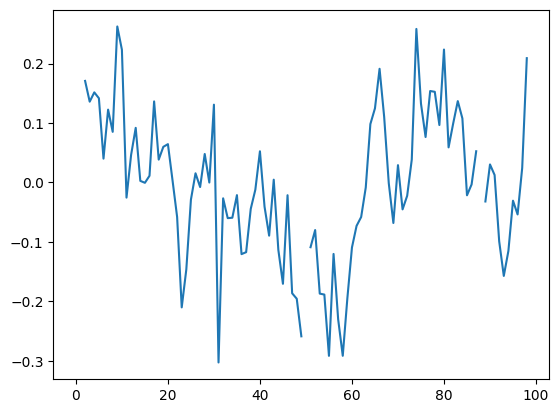

In [98]:
plt.plot(averaged_nc_swot_26.v_north_noiseless)

In [99]:
averaged_nc_swot_13

<xarray.Dataset> Size: 4kB
Dimensions:             (timec: 97)
Coordinates:
  * timec               (timec) datetime64[ns] 776B 2023-03-29T08:40:47.66328...
Data variables:
    u_east_noiseless    (timec) float64 776B -0.2256 nan ... 0.2484 0.115
    v_north_noiseless   (timec) float64 776B -0.09088 nan ... -0.003039 -0.09902
    uc_east_noiseless   (timec) float64 776B -0.1829 nan ... 0.2639 0.1092
    vc_north_noiseless  (timec) float64 776B -0.06953 nan ... -0.003508 -0.1049

## combine swot and aviso

In [100]:
time_start = ds_filtered.time[0].values
time_end = ds_filtered.time[-1].values
# selected_swot_combine = swot_combine.sel(time=slice(time_start, time_end))

In [101]:
swot_combine= xr.concat([averaged_nc_swot_13, averaged_nc_swot_26], dim='timec').sortby('timec').sel(timec=slice(time_start, time_end))
# aviso_combine= xr.concat([averaged_nc_avi_13, averaged_nc_avi_26], dim='time').sortby('time').sel(time=slice(time_start, time_end))

In [102]:
swot_combine.timec

<xarray.DataArray 'timec' (timec: 191)> Size: 2kB
array(['2023-04-01T19:16:51.131653376', '2023-04-02T08:03:18.109528320',
       '2023-04-02T19:07:28.908519168', '2023-04-03T07:53:55.868589824',
       '2023-04-03T18:58:06.654310016', '2023-04-04T07:44:33.593502464',
       '2023-04-04T18:48:44.366776704', '2023-04-05T07:35:11.289487872',
       '2023-04-05T18:39:22.045600128', '2023-04-06T07:25:49.249384192',
       '2023-04-06T18:30:00.263643136', '2023-04-07T07:16:27.474539520',
       '2023-04-07T18:20:38.473523200', '2023-04-08T07:07:05.663146240',
       '2023-04-08T18:11:16.646531712', '2023-04-09T06:57:43.816677760',
       '2023-04-09T18:01:54.784023424', '2023-04-10T06:48:21.936033664',
       '2023-04-10T17:52:32.887396608', '2023-04-11T06:39:00.021011840',
       '2023-04-11T17:43:10.957654272', '2023-04-12T06:29:38.074612096',
       '2023-04-12T17:33:48.998898176', '2023-04-13T06:20:16.099566720',
       '2023-04-13T17:24:27.011947776', '2023-04-14T06:10:54.097636096',
       '2023-04-14T17:15:04.997468928', '2023-04-15T06:01:32.349374592',
       '2023-04-15T17:05:42.952049792', '2023-04-16T05:52:10.003758208',
       '2023-04-16T16:56:20.872535296', '2023-04-17T05:42:47.906194944',
       '2023-04-17T16:46:58.758015744', '2023-04-18T05:33:25.771351552',
       '2023-04-18T16:37:36.605689344', '2023-04-19T05:24:03.598327552',
       '2023-04-19T16:28:14.414176512', '2023-04-20T05:14:41.384112128',
       '2023-04-20T16:18:52.182100224', '2023-04-21T05:05:19.132748288',
       '2023-04-21T16:09:29.914995584', '2023-04-22T04:55:56.960638464',
       '2023-04-22T16:00:07.877141888', '2023-04-23T04:46:34.960006272',
       '2023-04-23T15:50:45.863319040', '2023-04-24T04:37:12.929740288',
       '2023-04-24T15:41:23.810876416', '2023-04-25T04:27:50.854904064',
       '2023-04-25T15:32:01.720744448', '2023-04-26T04:18:28.754407680',
       '2023-04-26T15:22:39.608443904', '2023-04-27T04:09:06.631405440',
       '2023-04-27T15:13:17.471669760', '2023-04-28T03:59:44.482400384',
       '2023-04-28T15:03:55.308639232', '2023-04-29T03:50:22.306605696',
       '2023-04-29T14:54:33.118061696', '2023-04-30T03:41:00.102115840',
       '2023-04-30T14:45:10.897865728', '2023-05-01T03:31:37.868466816',
       '2023-05-01T14:35:48.649308032', '2023-05-02T03:22:15.604845184',
       '2023-05-02T14:26:26.367766912', '2023-05-03T03:12:53.308252288',
       '2023-05-03T14:17:04.053926528', '2023-05-04T03:03:30.979367808',
       '2023-05-04T14:07:41.707242752', '2023-05-05T02:54:08.618286208',
       '2023-05-05T13:58:19.329278976', '2023-05-06T02:44:46.310886144',
       '2023-05-06T13:48:57.145493120', '2023-05-07T02:35:24.180220032',
       '2023-05-07T13:39:34.998250240', '2023-05-08T02:26:02.020665088',
       '2023-05-08T13:30:12.824383232', '2023-05-09T02:16:39.834827008',
       '2023-05-09T13:20:50.623684352', '2023-05-10T02:07:17.622767360',
       '2023-05-10T13:11:28.395435648', '2023-05-11T01:57:55.381746176',
       '2023-05-11T13:02:06.135542912', '2023-05-12T01:48:33.109394304',
       '2023-05-12T12:52:43.843862016', '2023-05-13T01:39:10.803458048',
       '2023-05-13T12:43:21.517402752', '2023-05-14T01:29:48.408986496',
       '2023-05-14T12:33:59.104439424', '2023-05-15T01:20:26.034988288',
       '2023-05-15T12:24:36.711023872', '2023-05-16T01:11:03.627242752',
       '2023-05-16T12:15:14.285004672', '2023-05-17T01:01:41.188934144',
       '2023-05-17T12:05:51.829978240', '2023-05-18T00:52:18.807172992',
       '2023-05-18T11:56:29.706805120', '2023-05-19T00:42:56.890289152',
       '2023-05-22T11:19:01.687622656', '2023-05-23T00:05:28.971513984',
       '2023-05-23T11:09:39.789611392', '2023-05-23T23:56:06.924466048',
       '2023-05-24T11:00:17.725970432', '2023-05-25T10:50:55.634664320',
       '2023-05-25T23:37:22.746776832', '2023-05-26T10:41:33.514005888',
       '2023-05-26T23:28:00.614113408', '2023-05-27T10:32:11.363828480',
       '2023-05-27T23:18:38.452452096', '2023-05-28T10:22:49.184374272',
       '

In [103]:
aviso_combine = nc_avi.interp(longitude=lon_s2, latitude=lat_s2,time=swot_combine.timec)

In [104]:
aviso_combine

<xarray.Dataset> Size: 26kB
Dimensions:     (timec: 191)
Coordinates:
    longitude   float64 8B -125.0
    latitude    float64 8B 35.92
    time        (timec) datetime64[ns] 2kB 2023-04-01T19:16:51.131653376 ... ...
  * timec       (timec) datetime64[ns] 2kB 2023-04-01T19:16:51.131653376 ... ...
Data variables: (12/15)
    adt         (timec) float64 2kB 0.5302 0.5308 0.5313 ... 0.5311 0.5317
    err_sla     (timec) float64 2kB 0.01315 0.01333 0.01351 ... 0.01306 0.01329
    err_ugosa   (timec) float64 2kB 0.03392 0.03442 0.03488 ... 0.03317 0.0337
    err_vgosa   (timec) float64 2kB 0.04409 0.04454 0.04495 ... 0.04505 0.04561
    flag_ice    (timec) float64 2kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    sla         (timec) float64 2kB 0.004987 0.005605 ... 0.005868 0.006517
    ...          ...
    vgosa       (timec) float64 2kB 0.05174 0.04524 ... -0.02172 -0.02549
    ucgosa      (timec) float64 2kB -0.07051 -0.07087 -0.07151 ... 0.2037 0.2051
    vcgosa      (timec) float64 2kB 0.0535 0.04667 0.04158 ... -0.02156 -0.02518
    zeta_csiro  (timec) float64 2kB -0.03765 -0.03574 ... 0.06835 0.07226
    sr_csiro    (timec) float64 2kB 0.03211 0.03016 0.02938 ... 0.04108 0.04227
    OW_csiro    (timec) float64 2kB -0.001558 -0.001559 ... -0.003118 -0.003552
Attributes:
    Conventions:       CF-1.11
    title:             NRT merged all satellites Global Ocean Gridded SSALTO/...
    institution:       CLS, CNES
    source:            Altimetry measurements
    history:           2023-11-24 00:53:07Z: Creation
    contact:           servicedesk.cmems@mercator-ocean.eu
    references:        http://marine.copernicus.eu
    comment:           Sea Surface Height measured by Altimetry and derived v...
    subset:source:     ARCO data downloaded from the Marine Data Store using ...
    subset:productId:  SEALEVEL_GLO_PHY_L4_NRT_008_046
    subset:datasetId:  cmems_obs-sl_glo_phy-ssh_nrt_allsat-l4-duacs-0.25deg_P...
    subset:date:       2024-04-01T20:59:49.254Z

In [105]:
swot_combine

<xarray.Dataset> Size: 8kB
Dimensions:             (timec: 191)
Coordinates:
  * timec               (timec) datetime64[ns] 2kB 2023-04-01T19:16:51.131653...
Data variables:
    u_east_noiseless    (timec) float64 2kB 0.06118 -0.1084 ... 0.2541 0.115
    v_north_noiseless   (timec) float64 2kB 0.1709 0.1478 ... 0.02448 -0.09902
    uc_east_noiseless   (timec) float64 2kB 0.05862 -0.126 ... 0.2426 0.1092
    vc_north_noiseless  (timec) float64 2kB 0.1596 0.1818 ... 0.01929 -0.1049

## interp the nan values 

In [106]:
interp_swot = swot_combine.interpolate_na(dim='timec')
interp_aviso = aviso_combine.interpolate_na(dim='timec')

In [107]:
interp_swot.timec.shape

(191,)

### interp adcp on swot time 

In [108]:
lon_s2 = -125.044
lat_s2 = 35.917
####################### interpet adcp on swot time 

################################################
################## pass13 and pass 26 combine
interp_adcp_swot = ds_filtered.interp(time=interp_swot.timec, method='linear')
# interp_v_swot = ds_filtered.interp(time=interp_swot.timec, method='linear')

In [109]:
interp_adcp_swot

<xarray.Dataset> Size: 5MB
Dimensions:        (depth: 401, timec: 191)
Coordinates:
  * depth          (depth) float64 3kB -0.0 0.25 0.5 0.75 ... 99.5 99.75 100.0
    time           (timec) datetime64[ns] 2kB 2023-04-01T19:16:51.131653376 ....
  * timec          (timec) datetime64[ns] 2kB 2023-04-01T19:16:51.131653376 ....
Data variables:
    velE_adj       (timec, depth) float64 613kB 0.1733 0.2491 ... 0.06866
    velN_adj       (timec, depth) float64 613kB 0.1292 0.2816 ... 0.05869
    velE           (timec, depth) float64 613kB 0.1909 0.2667 ... 0.04285
    velN           (timec, depth) float64 613kB 0.08871 0.241 ... 0.0627 0.05712
    velE_filt      (timec, depth) float64 613kB 0.1541 0.1788 ... 0.0224 0.03063
    velN_filt      (timec, depth) float64 613kB 0.1632 0.21 ... 0.048 0.04689
    velE_adj_filt  (timec, depth) float64 613kB 0.1397 0.1644 ... 0.0717 0.07993
    velN_adj_filt  (timec, depth) float64 613kB 0.2378 0.2846 ... 0.03935

In [110]:
### select the depth to average and to plot the adcp

In [111]:
# Define the range of z values
z = ds_filtered.depth.values
idz = np.where((z >= 30) & (z <= 40))#np.where((z < -10) & (z > -40))

# Select the indices
selected_adcp = interp_adcp_swot.isel(depth=idz[0])
# selected_adcp_v = interp_v_swot.isel(depth=idz[0])

# Calculate the average over the selected indices
averaged_adcp = selected_adcp.mean(dim='depth')


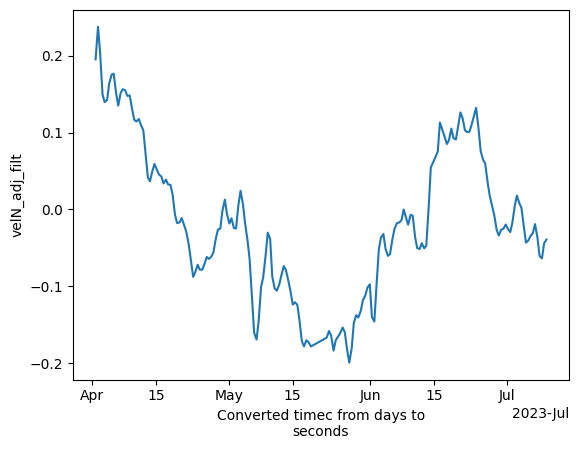

In [112]:
averaged_adcp.velN_adj_filt.plot()

# (averaged_adcp.velE_adj_filt+nc_intep.ue.values).plot()

In [113]:
# directory = '/mnt/flow/swot/Matt_Analysis/calval_orbit_expert_v1.0/calval_v_2/cube/FILT2_matlab/'
# nc = xr.open_dataset(directory+'cmems_obs-mob_glo_phy-cur_nrt_0.25deg_PT1H-i_1742259066150.nc')
# nc = nc.isel(depth=0, drop=True)

# nc['time'] = pd.to_datetime(nc['time'].values)

# nc_intep = nc.interp(time=averaged_adcp.time.values, longitude=lon_s2, latitude=lat_s2)

In [114]:
# nc_intep

In [115]:
z[idz]

array([30.  , 30.25, 30.5 , 30.75, 31.  , 31.25, 31.5 , 31.75, 32.  ,
       32.25, 32.5 , 32.75, 33.  , 33.25, 33.5 , 33.75, 34.  , 34.25,
       34.5 , 34.75, 35.  , 35.25, 35.5 , 35.75, 36.  , 36.25, 36.5 ,
       36.75, 37.  , 37.25, 37.5 , 37.75, 38.  , 38.25, 38.5 , 38.75,
       39.  , 39.25, 39.5 , 39.75, 40.  ])

In [116]:
averaged_adcp.velN_adj_filt

<xarray.DataArray 'velN_adj_filt' (timec: 191)> Size: 2kB
array([ 1.95427818e-01,  2.37893388e-01,  2.03823334e-01,  1.49671547e-01,
        1.39793243e-01,  1.42499393e-01,  1.63833758e-01,  1.75574791e-01,
        1.76812848e-01,  1.51210809e-01,  1.35170602e-01,  1.51843556e-01,
        1.56473015e-01,  1.55296367e-01,  1.47890380e-01,  1.48493015e-01,
        1.32551445e-01,  1.16709651e-01,  1.14516696e-01,  1.17723825e-01,
        1.10163526e-01,  1.03131144e-01,  7.46874763e-02,  4.17054723e-02,
        3.67026160e-02,  5.00135430e-02,  5.92541606e-02,  5.16187510e-02,
        4.54967314e-02,  4.28427143e-02,  3.39341106e-02,  3.89095067e-02,
        3.26283259e-02,  3.20621799e-02,  1.91921171e-02, -7.09132978e-03,
       -1.76661679e-02, -1.69289190e-02, -1.12006197e-02, -2.02745544e-02,
       -2.85888425e-02, -4.44516673e-02, -6.41585791e-02, -8.76823494e-02,
       -8.16508546e-02, -7.19002891e-02, -7.82841168e-02, -7.83393367e-02,
       -7.16026222e-02, -6.17965558e-02, -6.43735959e-02, -6.14575295e-02,
       -5.61187618e-02, -3.79773242e-02, -2.62319554e-02, -2.47396529e-02,
       -1.54029529e-03,  1.28779261e-02, -5.90285736e-03, -1.82401443e-02,
       -1.14787440e-02, -2.41712506e-02, -2.46900513e-02,  6.42138651e-03,
        2.42656108e-02,  6.69986825e-03, -1.80408847e-02, -3.99679763e-02,
       -6.47774268e-02, -1.15360153e-01, -1.60320968e-01, -1.69266230e-01,
       -1.44823644e-01, -1.00535811e-01, -8.80763465e-02, -5.97889426e-02,
       -3.01621634e-02, -3.82818716e-02, -8.71198246e-02, -1.02879900e-01,
...
       -1.11944039e-01, -1.01798720e-01, -9.72946730e-02, -1.39970930e-01,
       -1.45861304e-01, -9.99343511e-02, -5.12463550e-02, -3.64835332e-02,
       -3.18609909e-02, -5.11799247e-02, -6.03797434e-02, -5.78984933e-02,
       -3.80691264e-02, -2.48349816e-02, -1.76487422e-02, -1.70235161e-02,
       -1.38503001e-02,  3.43380500e-05, -1.08891352e-02, -1.98085310e-02,
       -6.90962833e-03, -8.11000366e-03, -3.61238596e-02, -5.03393019e-02,
       -5.14887503e-02, -4.38501753e-02, -5.05903653e-02, -4.69025892e-02,
        3.34662797e-03,  5.47742721e-02,  6.16574580e-02,  7.54188510e-02,
        1.13320409e-01,  9.57170893e-02,  8.52700445e-02,  9.01191862e-02,
        1.05347181e-01,  9.28635286e-02,  9.12453704e-02,  1.07065824e-01,
        1.26371963e-01,  1.19238378e-01,  1.03013207e-01,  1.00704440e-01,
        1.01283999e-01,  1.10316565e-01,  1.22259179e-01,  1.32301255e-01,
        1.05053274e-01,  7.62983871e-02,  6.47009747e-02,  6.00874713e-02,
        3.54946077e-02,  1.79009530e-02,  4.48177845e-03, -7.37853670e-03,
       -2.64163904e-02, -3.38937789e-02, -2.62139094e-02, -2.52954323e-02,
       -1.95288060e-02, -2.51398321e-02, -2.94966859e-02, -1.71303865e-02,
        4.84342610e-03,  1.81011071e-02,  8.16371038e-03,  2.22867781e-03,
       -2.16215885e-02, -4.32078997e-02, -4.02057342e-02, -3.46352784e-02,
       -3.04813058e-02, -1.89934323e-02, -3.64234896e-02, -6.04592340e-02,
       -6.36875654e-02, -4.41924739e-02, -3.90805362e-02])
Coordinates:
    time     (timec) datetime64[ns] 2kB 2023-04-01T19:16:51.131653376 ... 202...
  * timec    (timec) datetime64[ns] 2kB 2023-04-01T19:16:51.131653376 ... 202...

In [117]:
Uano_adcp = averaged_adcp.velE_adj_filt - np.nanmean(averaged_adcp.velE_adj_filt)
Vano_adcp = averaged_adcp.velN_adj_filt - np.nanmean(averaged_adcp.velN_adj_filt)

Uano_swot = interp_swot.u_east_noiseless - np.nanmean(interp_swot.u_east_noiseless) #swot_filt.u_g_noiseless - np.nanmean(swot_filt.u_g_noiseless) #
Vano_swot = interp_swot.v_north_noiseless - np.nanmean(interp_swot.v_north_noiseless) #swot_filt.v_g_noiseless - np.nanmean(swot_filt.v_g_noiseless)#interp_swot.v_g_noiseless - np.nanmean(interp_swot.v_g_noiseless)

Uano_avi = interp_aviso.ugosa - np.nanmean(interp_aviso.ugosa)
Vano_avi = interp_aviso.vgosa - np.nanmean(interp_aviso.vgosa)
detrend1_u_adcp = xrft.detrend(Uano_adcp, dim='timec', detrend_type='linear')
detrend1_u_swot = xrft.detrend(Uano_swot, dim='timec', detrend_type='linear')
detrend1_u_avi = xrft.detrend(Uano_avi, dim='timec', detrend_type='linear')

detrend1_v_adcp = xrft.detrend(Vano_adcp, dim='timec', detrend_type='linear')
detrend1_v_swot = xrft.detrend(Vano_swot, dim='timec', detrend_type='linear')
detrend1_v_avi = xrft.detrend(Vano_avi, dim='timec', detrend_type='linear')

print(100*np.std(detrend1_u_adcp).values)
print(100*np.std(detrend1_v_adcp).values)
# print(100*np.std(detrend_eke_adcp).values)
er1_u_swot = detrend1_u_adcp - detrend1_u_swot#(averaged_adcp_u - interp_swot.ugosa).values
er1_v_swot = detrend1_v_adcp - detrend1_v_swot
# er_eke_swot = detrend_eke_adcp - detrend_eke_swot

er1_u_avi = detrend1_u_adcp - detrend1_u_avi#(averaged_adcp_u - interp_swot.ugosa).values
er1_v_avi = detrend1_v_adcp - detrend1_v_avi
# er_eke_avi = detrend_eke_adcp - detrend_eke_avi
detrend1_u_swot = detrend1_u_swot.rename({'timec': 'time_uninterp'})
detrend1_v_swot = detrend1_v_swot.rename({'timec': 'time_uninterp'})


print(f'u for swot is {100*np.sqrt(np.nanmean(er1_u_swot**2))} m/s')
print(f'v for swot is {100*np.sqrt(np.nanmean(er1_v_swot**2))} m/s')
# print(f'eke for swot is {100*np.sqrt(np.nanmean(er_eke_swot**2))} m/s')

print(f'u for aviso is {100*np.sqrt(np.nanmean(er1_u_avi**2))} m/s')
print(f'v for aviso is {100*np.sqrt(np.nanmean(er1_v_avi**2))} m/s')
# print(f'eke for aviso is {100*np.sqrt(np.nanmean(er_eke_avi**2))} m/s')

5.590183511612961
9.40433058464559
u for swot is 8.478531919774348 m/s
v for swot is 7.7572628220317 m/s
u for aviso is 4.736154697388384 m/s
v for aviso is 5.636004634366189 m/s


In [118]:
Uano_adcp

<xarray.DataArray 'velE_adj_filt' (timec: 191)> Size: 2kB
array([-0.092402  , -0.0772739 , -0.11949015, -0.19050531, -0.21908044,
       -0.19137483, -0.16224452, -0.15095865, -0.13760032, -0.13429468,
       -0.13557023, -0.12433913, -0.0992115 , -0.07819369, -0.09192879,
       -0.13933776, -0.12934941, -0.11063977, -0.08438441, -0.08421021,
       -0.08698295, -0.09255654, -0.1184305 , -0.13990548, -0.11759958,
       -0.06692283, -0.03504608, -0.03312656, -0.03310479, -0.02795068,
       -0.00979653,  0.00492948,  0.0026245 , -0.00363933, -0.0224385 ,
       -0.02223414, -0.01923228, -0.0157282 , -0.00797857, -0.01044865,
       -0.00508113,  0.0075336 ,  0.01606676, -0.00149311, -0.02245544,
       -0.041254  , -0.06163638, -0.06454421, -0.05219516, -0.03937938,
       -0.0248611 , -0.02479767, -0.02851425, -0.01291187,  0.01733216,
        0.04673275,  0.0736182 ,  0.07552132,  0.0386024 , -0.00043934,
       -0.03834709, -0.03555058, -0.00442986,  0.01705277,  0.02959677,
        0.04307794,  0.04602535,  0.04892964,  0.0679068 ,  0.09537302,
        0.11169743,  0.10409728,  0.09977466,  0.09514311,  0.09360233,
        0.09096032,  0.10085824,  0.08944389,  0.02652443, -0.03925051,
       -0.03715957,  0.00098834,  0.02495791,  0.01090445, -0.00076629,
        0.00472359,  0.00266805,  0.01048903,  0.01429471,  0.013584  ,
        0.02001418,  0.04792959,  0.05735639,  0.04851754,  0.05605493,
        0.06246975,  0.00942139,  0.00988087,  0.00937282,  0.00741228,
        0.00785986,  0.04968034,  0.05936038,  0.05874639,  0.06020316,
        0.06362077,  0.0694974 ,  0.08057243,  0.12339589,  0.15671183,
        0.14917144,  0.13652796,  0.10683086,  0.07809464,  0.0616623 ,
        0.03707336,  0.03544385,  0.02334514, -0.01248404, -0.03504269,
       -0.04453125, -0.05935385, -0.06580891, -0.0593646 , -0.04214503,
       -0.03595558, -0.03522268, -0.03767376, -0.03520682, -0.03774202,
       -0.03906586, -0.03610363, -0.02122681, -0.01157247, -0.01898978,
       -0.01380169, -0.00357409, -0.00989501, -0.01915562, -0.01429411,
       -0.00485026, -0.00854513,  0.01171096,  0.02559041,  0.00186451,
        0.0145783 ,  0.02096736,  0.01688301,  0.01898224,  0.02311616,
        0.02605052,  0.01923416,  0.01782673,  0.01490775,  0.01991409,
        0.02335829,  0.02378629,  0.01626611,  0.00021999, -0.01833673,
       -0.01931863, -0.0063403 ,  0.00114212, -0.00274274, -0.01009932,
       -0.00188195,  0.01990466,  0.0264407 ,  0.01521849,  0.00947803,
        0.02091664,  0.02959315,  0.03537876,  0.04252305,  0.05541187,
        0.05983811,  0.04463707,  0.0305651 ,  0.01775688,  0.00891112,
        0.01707297,  0.02531696,  0.03624653,  0.03944598,  0.05317865,
        0.0757542 ,  0.0959874 ,  0.11389125,  0.1075033 ,  0.0965491 ,
        0.12512225])
Coordinates:
    time     (timec) datetime64[ns] 2kB 2023-04-01T19:16:51.131653376 ... 202...
  * timec    (timec) datetime64[ns] 2kB 2023-04-01T19:16:51.131653376 ... 202...

## put the adcp, swot and aviso on a regular time

In [119]:
# Define start and end datetime
start = np.datetime64('2023-04-01T20:06:32.383560960')
end = np.datetime64('2023-07-02T17:51:40.707652608')

# Create datetime range with a step of 30 minutes
time_range = pd.date_range(start=start, end=end, freq='12H')

# Convert the datetime range to a numpy array with dtype='datetime64[ns]'
time_array = time_range.values.astype('datetime64[ns]')

/tmp/ipykernel_28389/375260886.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start, end=end, freq='12H')


In [120]:
# averaged_adcp_u.time

In [121]:
time_array.shape

(184,)

In [122]:
averaged_adcp = averaged_adcp.interp(timec=time_array, method='linear')

interp_swot = interp_swot.interp(timec=time_array, method='linear')
interp_aviso = interp_aviso.interp(timec=time_array, method='linear')

In [123]:
# averaged_adcp_u

In [124]:
len(time_array)

184

In [125]:
# Create a DataFrame
df = pd.DataFrame({
    'datetime': time_range,
    'averaged_adcp_u': averaged_adcp.velE_adj_filt,
    'interp_swot_u': interp_swot.u_east_noiseless.values,
    'interp_avi_u': interp_aviso.ugosa.values
})

# Ensure the 'datetime' column is in datetime format and set it as the index
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

# Compute the 5-day running mean for 'averaged_adcp_u' and 'interp_swot_u'
# Assuming you have data at 12-hour intervals, you need 5 days * 2 intervals per day = 10 intervals window
df['running_mean_averaged_adcp_u'] = df['averaged_adcp_u'].rolling(window=10, min_periods=1).mean()
df['running_mean_interp_swot_u'] = df['interp_swot_u'].rolling(window=10, min_periods=1).mean()
df['running_mean_interp_avi_u'] = df['interp_avi_u'].rolling(window=10, min_periods=1).mean()

# Display the resulting DataFrame
# import ace_tools as tools; tools.display_dataframe_to_user(name="5-Day Running Mean for averaged_adcp_u and interp_swot_u", dataframe=df)

df.head()

averaged_adcp_u  interp_swot_u  interp_avi_u  \
datetime                                                                      
2023-04-01 20:06:32.383560960        -0.022366       0.050191     -0.068780   
2023-04-02 08:06:32.383560960        -0.008424      -0.108473     -0.069277   
2023-04-02 20:06:32.383560960        -0.055907      -0.118610     -0.069805   
2023-04-03 08:06:32.383560960        -0.121992       0.002227     -0.065605   
2023-04-03 20:06:32.383560960        -0.147551      -0.219520     -0.058675   

                               running_mean_averaged_adcp_u  \
datetime                                                      
2023-04-01 20:06:32.383560960                     -0.022366   
2023-04-02 08:06:32.383560960                     -0.015395   
2023-04-02 20:06:32.383560960                     -0.028899   
2023-04-03 08:06:32.383560960                     -0.052172   
2023-04-03 20:06:32.383560960                     -0.071248   

                               running_mean_interp_swot_u  \
datetime                                                    
2023-04-01 20:06:32.383560960                    0.050191   
2023-04-02 08:06:32.383560960                   -0.029141   
2023-04-02 20:06:32.383560960                   -0.058964   
2023-04-03 08:06:32.383560960                   -0.043666   
2023-04-03 20:06:32.383560960                   -0.078837   

                               running_mean_interp_avi_u  
datetime                                                  
2023-04-01 20:06:32.383560960                  -0.068780  
2023-04-02 08:06:32.383560960                  -0.069029  
2023-04-02 20:06:32.383560960                  -0.069287  
2023-04-03 08:06:32.383560960                  -0.068367  
2023-04-03 20:06:32.383560960                  -0.066428

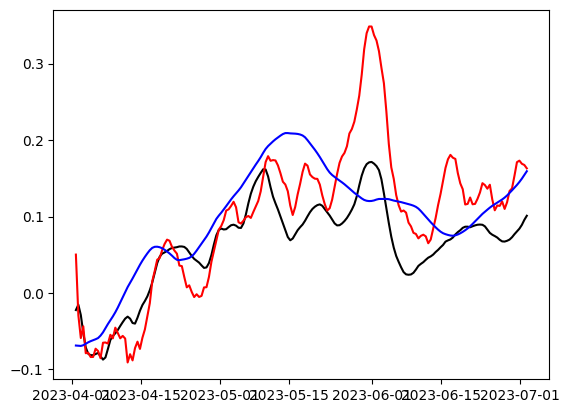

In [126]:
plt.plot(df['running_mean_averaged_adcp_u'],'k')
plt.plot(df['running_mean_interp_swot_u'],'r')
plt.plot(df['running_mean_interp_avi_u'],'b')

# plt.plot(interp_aviso.time, interp_aviso.vgosa,'b')

In [127]:
from scipy.signal import butter, filtfilt
import numpy as np
import xarray as xr

def butter_lowpass_xr(da, dt_hours, cutoff_hours, order=2):
    """
    Apply Butterworth low-pass filter along 'time' dimension of an xarray DataArray.
    """
    fs = 1 / dt_hours  # Sampling frequency in 1/hour
    fc = 1 / cutoff_hours  # Cutoff frequency in 1/hour
    b, a = butter(order, fc / (0.5 * fs), btype='low')

    # Apply filter along time axis
    filtered = filtfilt(b, a, da.values, axis=0)
    
    # Return as DataArray
    return xr.DataArray(filtered, dims=da.dims, coords=da.coords, attrs=da.attrs)


In [128]:
dt_hours = 12
cutoff_hours = 48

# Filter along time axis
swot_filt_u = butter_lowpass_xr(interp_swot.u_east_noiseless,dt_hours, cutoff_hours)
swot_filt_v = butter_lowpass_xr(interp_swot.v_north_noiseless,dt_hours, cutoff_hours)
swot_filt_uc = butter_lowpass_xr(interp_swot.uc_east_noiseless,dt_hours, cutoff_hours)
swot_filt_vc = butter_lowpass_xr(interp_swot.vc_north_noiseless,dt_hours, cutoff_hours)
interp_swot['u_east_noiseless']=swot_filt_u
interp_swot['v_north_noiseless']=swot_filt_v
interp_swot['uc_east_noiseless']=swot_filt_uc
interp_swot['vc_north_noiseless']=swot_filt_vc


In [129]:
swot_filt_u

<xarray.DataArray (timec: 184)> Size: 1kB
array([ 0.05018313, -0.07284123, -0.09707656, -0.09290473, -0.1207107 ,
       -0.1309003 , -0.10037536, -0.06070399, -0.04858028, -0.0514421 ,
       -0.02127808,  0.00442297, -0.02446644, -0.06958174, -0.0893931 ,
       -0.07720965, -0.06599497, -0.07835344, -0.07755643, -0.07592124,
       -0.11328878, -0.13519548, -0.09105605, -0.02457565,  0.00195641,
       -0.02570471, -0.05106202, -0.01600463,  0.05136371,  0.09095576,
        0.09470398,  0.0921945 ,  0.09115062,  0.0823335 ,  0.06898102,
        0.05101158,  0.03519361,  0.03321686,  0.03499015,  0.03480236,
        0.03232747,  0.02117398,  0.00981358, -0.00852307, -0.03832898,
       -0.03993645, -0.01753379, -0.01317364, -0.00731953,  0.01604383,
        0.03392488,  0.04830259,  0.05903194,  0.05978294,  0.0800761 ,
        0.12723783,  0.15143648,  0.13070079,  0.10147727,  0.09602225,
        0.1142994 ,  0.12786383,  0.11910922,  0.11011154,  0.09429283,
        0.04753576,  0.02357556,  0.07267424,  0.13393102,  0.14129429,
        0.12576799,  0.13684376,  0.16453247,  0.18072544,  0.17983963,
        0.18048778,  0.21202691,  0.24315502,  0.20419358,  0.12955141,
        0.10768179,  0.12091747,  0.10595889,  0.08168926,  0.09293225,
        0.11403163,  0.10337186,  0.08567695,  0.11320967,  0.18964648,
        0.26428389,  0.29040295,  0.25464339,  0.16647547,  0.07274669,
        0.03142255,  0.04448524,  0.07302772,  0.09626093,  0.11632141,
        0.13777613,  0.16278736,  0.18474246,  0.18966543,  0.18520904,
        0.19647838,  0.21609458,  0.20913425,  0.17888766,  0.18053584,
        0.23430771,  0.28003176,  0.28312055,  0.28538657,  0.321883  ,
        0.40104188,  0.49513325,  0.50994589,  0.40367785,  0.27545296,
        0.21729323,  0.20272447,  0.17900261,  0.14909098,  0.13969865,
        0.14559788,  0.13910593,  0.11934888,  0.0978258 ,  0.06896531,
        0.04574654,  0.06323556,  0.11345662,  0.13501334,  0.10123234,
        0.0612071 ,  0.05289466,  0.05755949,  0.0540082 ,  0.04900748,
        0.05833908,  0.07312169,  0.07722199,  0.09003542,  0.13204041,
        0.18266253,  0.21138826,  0.21558968,  0.2130405 ,  0.21716898,
        0.21909795,  0.18959365,  0.12933778,  0.08113028,  0.05880439,
        0.05540401,  0.06891591,  0.07604487,  0.10656206,  0.19409806,
        0.23734155,  0.17571934,  0.11834027,  0.13630761,  0.16058994,
        0.13000887,  0.08427308,  0.06321758,  0.05350949,  0.07228904,
        0.13006949,  0.16763111,  0.15568338,  0.13654502,  0.14971056,
        0.17919167,  0.1819171 ,  0.1756903 ,  0.19620233,  0.20841315,
        0.18036596,  0.13839675,  0.11862403,  0.12802707])
Coordinates:
  * timec    (timec) datetime64[ns] 1kB 2023-04-01T20:06:32.383560960 ... 202...

In [130]:
Uano_adcp = averaged_adcp.velE_adj_filt - np.nanmean(averaged_adcp.velE_adj_filt)
Vano_adcp = averaged_adcp.velN_adj_filt - np.nanmean(averaged_adcp.velN_adj_filt)

Ugano_swot = interp_swot.u_east_noiseless - np.nanmean(interp_swot.u_east_noiseless) #swot_filt.u_g_noiseless - np.nanmean(swot_filt.u_g_noiseless) #
Vgano_swot = interp_swot.v_north_noiseless - np.nanmean(interp_swot.v_north_noiseless) #swot_filt.v_g_noiseless - np.nanmean(swot_filt.v_g_noiseless)#interp_swot.v_g_noiseless - np.nanmean(interp_swot.v_g_noiseless)

Ucgano_swot = interp_swot.uc_east_noiseless - np.nanmean(interp_swot.uc_east_noiseless) #swot_filt.u_g_noiseless - np.nanmean(swot_filt.u_g_noiseless) #
Vcgano_swot = interp_swot.vc_north_noiseless - np.nanmean(interp_swot.vc_north_noiseless) #swot_filt.v_g_noiseless - np.nanmean(swot_filt.v_g_noiseless)#interp_swot.v_g_noiseless - np.nanmean(interp_swot.v_g_noiseless)

Uano_avi = interp_aviso.ugosa - np.nanmean(interp_aviso.ugosa)
Vano_avi = interp_aviso.vgosa - np.nanmean(interp_aviso.vgosa)
eke_adcp = 1/2*(np.sqrt(Uano_adcp**2+Vano_adcp**2))
eke_avi = 1/2*(np.sqrt(Uano_avi**2+Vano_avi**2))
ekeg_swot = 1/2*(np.sqrt(Ugano_swot**2+Vgano_swot**2))
ekecg_swot = 1/2*(np.sqrt(Ucgano_swot**2+Vcgano_swot**2))

In [131]:
interp_swot

<xarray.Dataset> Size: 7kB
Dimensions:             (timec: 184)
Coordinates:
  * timec               (timec) datetime64[ns] 1kB 2023-04-01T20:06:32.383560...
Data variables:
    u_east_noiseless    (timec) float64 1kB 0.05018 -0.07284 ... 0.1186 0.128
    v_north_noiseless   (timec) float64 1kB 0.1694 0.1503 ... 0.01815 0.03337
    uc_east_noiseless   (timec) float64 1kB 0.04664 -0.08141 ... 0.14 0.143
    vc_north_noiseless  (timec) float64 1kB 0.161 0.1653 ... 0.02716 0.03389

In [132]:
detrend_u_adcp = xrft.detrend(Uano_adcp, dim='timec', detrend_type='linear')
detrend_ug_swot = xrft.detrend(Ugano_swot, dim='timec', detrend_type='linear')
detrend_ucg_swot = xrft.detrend(Ucgano_swot, dim='timec', detrend_type='linear')
detrend_u_avi = xrft.detrend(Uano_avi, dim='timec', detrend_type='linear')

detrend_v_adcp = xrft.detrend(Vano_adcp, dim='timec', detrend_type='linear')
detrend_vg_swot = xrft.detrend(Vgano_swot, dim='timec', detrend_type='linear')
detrend_vcg_swot = xrft.detrend(Vcgano_swot, dim='timec', detrend_type='linear')
detrend_v_avi = xrft.detrend(Vano_avi, dim='timec', detrend_type='linear')


Uano_adcp1 = detrend_u_adcp - np.nanmean(detrend_u_adcp)
Vano_adcp1 = detrend_v_adcp - np.nanmean(detrend_v_adcp)

Ugano_swot1 = detrend_ug_swot - np.nanmean(detrend_ug_swot)
Vgano_swot1 = detrend_vg_swot - np.nanmean(detrend_vg_swot)

Ucgano_swot1 = detrend_ucg_swot - np.nanmean(detrend_ucg_swot)
Vcgano_swot1 = detrend_vcg_swot - np.nanmean(detrend_vcg_swot)

Uano_avi1 = detrend_u_avi - np.nanmean(detrend_u_avi)
Vano_avi1 = detrend_v_avi - np.nanmean(detrend_v_avi)
detrend_eke_adcp = 1/2*(np.sqrt(Uano_adcp1**2+Vano_adcp1**2))
detrend_ekeg_swot = 1/2*(np.sqrt(Ugano_swot1**2+Vgano_swot1**2))
detrend_ekecg_swot = 1/2*(np.sqrt(Ucgano_swot1**2+Vcgano_swot1**2))
detrend_eke_avi = 1/2*(np.sqrt(Uano_avi1**2+Vano_avi1**2))

In [133]:
print(100*np.std(detrend_u_adcp).values)
print(100*np.std(detrend_v_adcp).values)
print(100*np.std(detrend_eke_adcp).values)
er_ug_swot = detrend_u_adcp - detrend_ug_swot#(averaged_adcp_u - interp_swot.ugosa).values
er_vg_swot = detrend_v_adcp - detrend_vg_swot
er_ekeg_swot = detrend_eke_adcp - detrend_ekeg_swot

er_ucg_swot = detrend_u_adcp - detrend_ucg_swot#(averaged_adcp_u - interp_swot.ugosa).values
er_vcg_swot = detrend_v_adcp - detrend_vcg_swot
er_ekecg_swot = detrend_eke_adcp - detrend_ekecg_swot

er_u_avi = detrend_u_adcp - detrend_u_avi#(averaged_adcp_u - interp_swot.ugosa).values
er_v_avi = detrend_v_adcp - detrend_v_avi
er_eke_avi = detrend_eke_adcp - detrend_eke_avi

print(f'ug for swot is {100*np.sqrt(np.nanmean(er_ug_swot**2))} m/s')
print(f'vg for swot is {100*np.sqrt(np.nanmean(er_vg_swot**2))} m/s')
print(f'ekeg for swot is {100*np.sqrt(np.nanmean(er_ekeg_swot**2))} m/s')

print(f'ucg for swot is {100*np.sqrt(np.nanmean(er_ucg_swot**2))} m/s')
print(f'vcg for swot is {100*np.sqrt(np.nanmean(er_vcg_swot**2))} m/s')
print(f'ekecg for swot is {100*np.sqrt(np.nanmean(er_ekecg_swot**2))} m/s')


print(f'u for aviso is {100*np.sqrt(np.nanmean(er_u_avi**2))} m/s')
print(f'v for aviso is {100*np.sqrt(np.nanmean(er_v_avi**2))} m/s')
print(f'eke for aviso is {100*np.sqrt(np.nanmean(er_eke_avi**2))} m/s')

5.62787716644139
10.046580862930238
2.599900502456147
ug for swot is 6.164111479471692 m/s
vg for swot is 5.598855728134203 m/s
ekeg for swot is 2.978975953978214 m/s
ucg for swot is 6.456358005887365 m/s
vcg for swot is 6.185317353732761 m/s
ekecg for swot is 3.212132660106874 m/s
u for aviso is 4.7047843018062645 m/s
v for aviso is 5.766334448931915 m/s
eke for aviso is 2.394006108812562 m/s


In [134]:
print("Correlation coefficient:", np.corrcoef(detrend_u_adcp, detrend_ug_swot)[0, 1])
print("Correlation coefficient:", np.corrcoef(detrend_v_adcp, detrend_vg_swot)[0, 1])
print("Correlation coefficient:", np.corrcoef(detrend_eke_adcp, detrend_ekeg_swot)[0, 1])


print("Correlation coefficient:", np.corrcoef(detrend_u_adcp, detrend_ucg_swot)[0, 1])
print("Correlation coefficient:", np.corrcoef(detrend_v_adcp, detrend_vcg_swot)[0, 1])
print("Correlation coefficient:", np.corrcoef(detrend_eke_adcp, detrend_ekecg_swot)[0, 1])



print("Correlation coefficient:", np.corrcoef(detrend_u_adcp, detrend_u_avi)[0, 1])
print("Correlation coefficient:", np.corrcoef(detrend_v_adcp, detrend_v_avi)[0, 1])
print("Correlation coefficient:", np.corrcoef(detrend_eke_adcp, detrend_eke_avi)[0, 1])


Correlation coefficient: 0.7212718718212798
Correlation coefficient: 0.886171316348966
Correlation coefficient: 0.6954980942851517
Correlation coefficient: 0.7274867310810414
Correlation coefficient: 0.8776039302055866
Correlation coefficient: 0.7067235834791876
Correlation coefficient: 0.6554103705000285
Correlation coefficient: 0.8426416567762668
Correlation coefficient: 0.6109801717193721


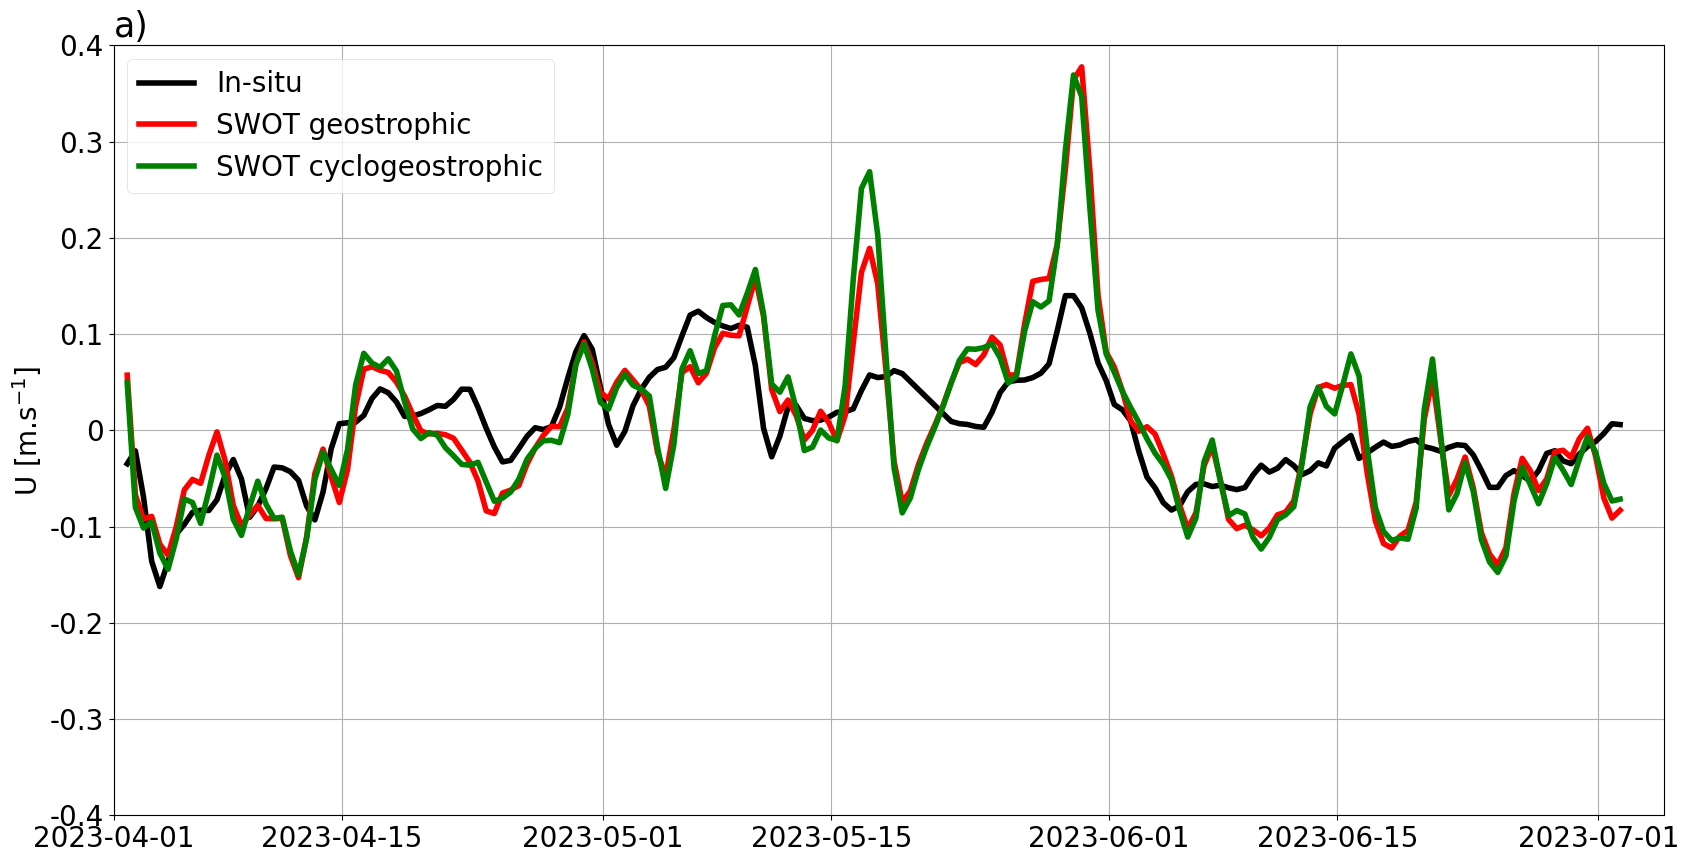

In [135]:
dmin, dmax = -.4,.4#-.25,.25
lw = 4; loc = 'upper left';
############################################################
#############################3 prepare the plot
ifont = 25; unit = '$m$'
sizz = 20; colors = 'gray'; pts = 15
xyfont = 25
xtick = ['2023-04-01','2023-01-15','2023-05-01','2023-05-15',
         '2023-06-01','2023-06-15','2023-07-01','2023-07-05']
xlabel = ['04/01','04/15','05/01','05/15','06/01','06/15','07/01','07/05']
#### set up xlim an y lim
xlim1 = np.datetime64('2023-04-01')
xlim2 = np.datetime64('2023-07-05')
# xticklabels = ['2023-04-01T16', '2023-04-20', '2023-05-09', '2023-05-29','2023-06-18','2023-07-10T23']  # Specify the corresponding tick labels
xmin,xmax = 1E-2, 1/2
ymin1,ymax1 = 1E-6, 1E0
locs = 'left'

ytick = [-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4]
         
ylabel = ['-0.4','-0.3','-0.2','-0.1','0','0.1','0.2','0.3','0.4']

indz = -20

# ##### compute the phase
# phase_u1 = np.angle(psd_u12,deg=True)
# phase_u2 = np.angle(psd_u13,deg=True)

###################################################
# Create subplots
fig = plt.figure(figsize=(20, 10))
gs = GridSpec(1, 3, figure=fig)
# gs = GridSpec(2, 1, height_ratios=[1, 2])

# First row, first column plot
ax1 = fig.add_subplot(gs[0,:])
ax1.plot(interp_aviso.timec,detrend_u_adcp,'k',lw=lw, label='In-situ')
ax1.plot(interp_aviso.timec, detrend_ug_swot,'r',lw=lw, label='SWOT geostrophic')#-np.nanmean(nc_interp.ugosa),'--b')
ax1.plot(interp_aviso.timec, detrend_ucg_swot,'g',lw=lw, label='SWOT cyclogeostrophic')#-np.nanmean(nc_interp.ugosa),'--b')
ax1.set_title(f"a)",loc=locs,fontsize=sizz+5)
ax1.xaxis.set_tick_params(labelsize=sizz)
ax1.yaxis.set_tick_params(labelsize=sizz)
ax1.set_xlim([xlim1, xlim2])
ax1.set_ylim(dmin,dmax)
ax1.xaxis.set_tick_params(labelsize=sizz)
ax1.yaxis.set_tick_params(labelsize=sizz)
# ax.set_xticks(xticks)
# ax.set_xticklabels(xlabel)
ax1.set_yticks(ytick)
ax1.set_yticklabels(ylabel)
legend_properties = {'size':sizz}
lg = plt.legend(loc=loc,prop=legend_properties)
lg.get_frame().set_ec('lightgray')
lg.get_frame().set_lw(0.5)
# ax.set_title('(a)', loc='left',fontsize=sizz,
#          fontweight='bold', color = colors)
# ax.set_xlabel('$Time$',fontsize=sizz)
ax1.set_ylabel('U [m.s$^{-1}$]',fontsize=sizz) # regex: ($10log10$)
#title_text = r'$\bf{Standard\ deviation\ computed\ over\ along\ and\ cross\ track}$'
#title = fig.suptitle(title_text, y=0.97, fontsize=sizz)
# title.set_color('blue')
# title.set_bbox(dict(facecolor='white', edgecolor='red', boxstyle='round'))
# plt.tight_layout()
ax1.grid()


## plot the dataset

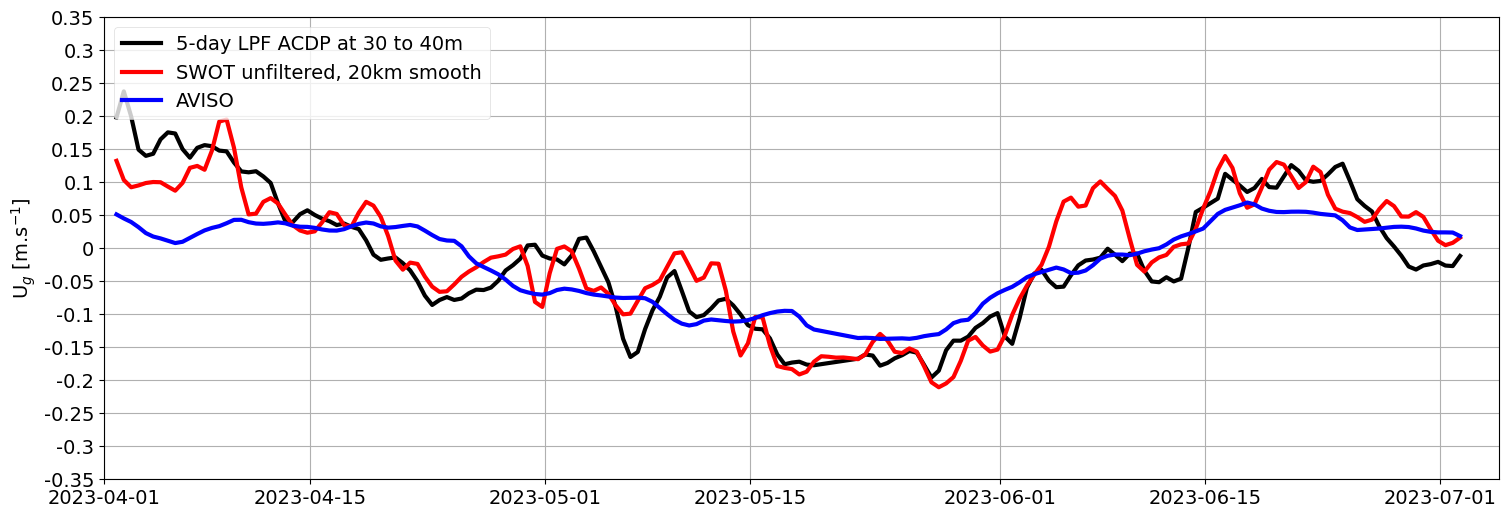

In [888]:
dmin, dmax = -.35,.35#-.25,.25
lw = 3; loc = 'upper left'; locs = 'center left'
############################################################
#############################3 prepare the plot
ifont = 25; unit = '$m$'
sizz = 14; colors = 'gray'; pts = 15
xyfont = 25
xtick = ['2023-04-01','2023-01-15','2023-05-01','2023-05-15',
         '2023-06-01','2023-06-15','2023-07-01','2023-07-05']
xlabel = ['04/01','04/15','05/01','05/15','06/01','06/15','07/01','07/05']
#### set up xlim an y lim
xlim1 = np.datetime64('2023-04-01')
xlim2 = np.datetime64('2023-07-05')
# xticklabels = ['2023-04-01T16', '2023-04-20', '2023-05-09', '2023-05-29','2023-06-18','2023-07-10T23']  # Specify the corresponding tick labels


ytick = [-0.35,-0.3,-0.25,-0.2,-0.15,-0.1,-0.05,0,0.05,0.1,0.15,0.2,0.25,0.3,0.35]
         
ylabel = ['-0.35','-0.3','-0.25','-0.2','-0.15','-0.1','-0.05','0','0.05','0.1','0.15','0.2','0.25','0.3','0.35']

indz = -20
###################################################
fig, ax = plt.subplots(figsize=(18,6))  
####### old
ax = plt.subplot(111)
ax.plot(interp_aviso.timec,averaged_adcp.velN_adj_filt,'k',lw=lw, label='5-day LPF ACDP at '+str(int(z[idz][0]))+' to '+str(int(z[idz][-1]))+'m')
ax.plot(interp_aviso.timec, interp_swot.v_north_noiseless,'r',lw=lw, label='SWOT unfiltered, 20km smooth')#-np.nanmean(nc_interp.ugosa),'--b')
ax.plot(interp_aviso.timec, interp_aviso.vgosa,'b',lw=lw, label='AVISO')#-np.nanmean(nc_interp.ugosa),'--b')

ax.xaxis.set_tick_params(labelsize=sizz)
ax.yaxis.set_tick_params(labelsize=sizz)
ax.set_xlim([xlim1, xlim2])
ax.set_ylim(dmin,dmax)
ax.xaxis.set_tick_params(labelsize=sizz)
ax.yaxis.set_tick_params(labelsize=sizz)
# ax.set_xticks(xticks)
# ax.set_xticklabels(xlabel)
ax.set_yticks(ytick)
ax.set_yticklabels(ylabel)
legend_properties = {'size':sizz}
lg = plt.legend(loc=loc,prop=legend_properties)
lg.get_frame().set_ec('lightgray')
lg.get_frame().set_lw(0.5)
# ax.set_title('(a)', loc='left',fontsize=sizz,
#          fontweight='bold', color = colors)
# ax.set_xlabel('$Time$',fontsize=sizz)
ax.set_ylabel('U$_g$ [m.s$^{-1}$]',fontsize=sizz) # regex: ($10log10$)
#title_text = r'$\bf{Standard\ deviation\ computed\ over\ along\ and\ cross\ track}$'
#title = fig.suptitle(title_text, y=0.97, fontsize=sizz)
# title.set_color('blue')
# title.set_bbox(dict(facecolor='white', edgecolor='red', boxstyle='round'))
# plt.tight_layout()
ax.grid()


In [889]:
e1 = Uano_adcp - Uano_swot
e2 = Uano_adcp - Uano_avi
print(100*np.sqrt(e1**2).mean())
print(100*np.sqrt(e2**2).mean())


<xarray.DataArray ()> Size: 8B
array(4.15674213)
<xarray.DataArray ()> Size: 8B
array(3.75143444)
Coordinates:
    longitude  float64 8B -125.0
    latitude   float64 8B 35.92


In [890]:
e1 = averaged_adcp.velN_adj_filt - interp_swot.v_north_noiseless
e2 = averaged_adcp.velN_adj_filt - interp_aviso.vgosa
print(100*np.sqrt(e1**2).mean())
print(100*np.sqrt(e2**2).mean())

<xarray.DataArray ()> Size: 8B
array(3.58800536)
<xarray.DataArray ()> Size: 8B
array(4.92166852)
Coordinates:
    longitude  float64 8B -125.0
    latitude   float64 8B 35.92


In [891]:
Uano_adcp = averaged_adcp.velE_adj_filt - np.nanmean(averaged_adcp.velE_adj_filt)
Vano_adcp = averaged_adcp.velN_adj_filt - np.nanmean(averaged_adcp.velN_adj_filt)

Uano_swot = interp_swot.u_east_noiseless - np.nanmean(interp_swot.u_east_noiseless) #swot_filt.u_g_noiseless - np.nanmean(swot_filt.u_g_noiseless) #
Vano_swot = interp_swot.v_north_noiseless - np.nanmean(interp_swot.v_north_noiseless) #swot_filt.v_g_noiseless - np.nanmean(swot_filt.v_g_noiseless)#interp_swot.v_g_noiseless - np.nanmean(interp_swot.v_g_noiseless)

Uano_avi = interp_aviso.ugosa - np.nanmean(interp_aviso.ugosa)
Vano_avi = interp_aviso.vgosa - np.nanmean(interp_aviso.vgosa)
eke_adcp = 1/2*(np.sqrt(Uano_adcp**2+Vano_adcp**2))
eke_avi = 1/2*(np.sqrt(Uano_avi**2+Vano_avi**2))
eke_swot = 1/2*(np.sqrt(Uano_swot**2+Vano_swot**2))

## detrent u velocity

In [892]:
detrend_u_adcp = xrft.detrend(Uano_adcp, dim='timec', detrend_type='linear')
detrend_u_swot = xrft.detrend(Uano_swot, dim='timec', detrend_type='linear')
detrend_u_avi = xrft.detrend(Uano_avi, dim='timec', detrend_type='linear')

detrend_v_adcp = xrft.detrend(Vano_adcp, dim='timec', detrend_type='linear')
detrend_v_swot = xrft.detrend(Vano_swot, dim='timec', detrend_type='linear')
detrend_v_avi = xrft.detrend(Vano_avi, dim='timec', detrend_type='linear')

# detrend_ut_adcp = xrft.detrend(np.sqrt(Uano_adcp**2+Vano_adcp**2), dim='timec', detrend_type='linear')
# detrend_ut_swot = xrft.detrend(np.sqrt(Uano_swot**2+Vano_swot**2), dim='timec', detrend_type='linear')
# detrend_ut_avi = xrft.detrend(np.sqrt(Uano_avi**2+Vano_avi**2), dim='timec', detrend_type='linear')


Uano_adcp1 = detrend_u_adcp - np.nanmean(detrend_u_adcp)
Vano_adcp1 = detrend_v_adcp - np.nanmean(detrend_v_adcp)

Uano_swot1 = detrend_u_swot - np.nanmean(detrend_u_swot)
Vano_swot1 = detrend_v_swot - np.nanmean(detrend_v_swot)

Uano_avi1 = detrend_u_avi - np.nanmean(detrend_u_avi)
Vano_avi1 = detrend_v_avi - np.nanmean(detrend_v_avi)
detrend_eke_adcp = 1/2*(np.sqrt(Uano_adcp1**2+Vano_adcp1**2))
detrend_eke_swot = 1/2*(np.sqrt(Uano_swot1**2+Vano_swot1**2))
detrend_eke_avi = 1/2*(np.sqrt(Uano_avi1**2+Vano_avi1**2))

detrend_ut_adcp = (np.sqrt(detrend_u_adcp**2+detrend_v_adcp**2))
detrend_ut_swot = (np.sqrt(detrend_u_swot**2+detrend_v_swot**2))
detrend_ut_avi = (np.sqrt(detrend_u_avi**2+detrend_v_avi**2))

# shps_u = xrft.power_spectrum(detrend_u_t, dim=['time'], window='hann')

In [893]:
detrend_ut_adcp.min()

<xarray.DataArray ()> Size: 8B
array(0.01087909)

In [895]:
print(100*np.std(detrend_u_swot).values)
print(100*np.std(detrend_v_swot).values)
print(100*np.std(detrend_eke_swot).values)
print(100*np.std(detrend_ut_swot).values)

6.610320092101789
9.70214598465451
2.755270085297597
5.510540170595194


In [896]:
print(100*np.std(detrend_u_avi).values)
print(100*np.std(detrend_v_avi).values)
print(100*np.std(detrend_eke_avi).values)
print(100*np.std(detrend_ut_avi).values)

5.705382294413871
6.469583152569262
1.7780891809948833
3.5561783619897667


In [894]:
print(100*np.std(detrend_u_adcp).values)
print(100*np.std(detrend_v_adcp).values)
print(100*np.std(detrend_eke_adcp).values)
print(100*np.std(detrend_ut_adcp).values)
er_u_swot = detrend_u_adcp - detrend_u_swot#(averaged_adcp_u - interp_swot.ugosa).values
er_v_swot = detrend_v_adcp - detrend_v_swot
er_eke_swot = detrend_eke_adcp - detrend_eke_swot
er_ut_swot = detrend_ut_adcp - detrend_ut_swot

er_u_avi = detrend_u_adcp - detrend_u_avi#(averaged_adcp_u - interp_swot.ugosa).values
er_v_avi = detrend_v_adcp - detrend_v_avi
er_eke_avi = detrend_eke_adcp - detrend_eke_avi
er_ut_avi = detrend_ut_adcp - detrend_ut_avi

print(f'u for swot is {100*np.sqrt(np.nanmean(er_u_swot**2))} m/s')
print(f'v for swot is {100*np.sqrt(np.nanmean(er_v_swot**2))} m/s')
print(f'eke for swot is {100*np.sqrt(np.nanmean(er_eke_swot**2))} m/s')
print(f'ut for swot is {100*np.sqrt(np.nanmean(er_ut_swot**2))} m/s')

print(f'u for aviso is {100*np.sqrt(np.nanmean(er_u_avi**2))} m/s')
print(f'v for aviso is {100*np.sqrt(np.nanmean(er_v_avi**2))} m/s')
print(f'eke for aviso is {100*np.sqrt(np.nanmean(er_eke_avi**2))} m/s')
print(f'ut for aviso is {100*np.sqrt(np.nanmean(er_ut_avi**2))} m/s')

5.62787716644139
10.046580862930238
2.599900502456147
5.199801004912294
u for swot is 4.297249323057047 m/s
v for swot is 4.281184298044308 m/s
eke for swot is 2.0182899598270345 m/s
ut for swot is 4.036579919654069 m/s
u for aviso is 4.7047843018062645 m/s
v for aviso is 5.766334448931915 m/s
eke for aviso is 2.394006108812562 m/s
ut for aviso is 4.788012217625124 m/s


In [814]:
5.62787716644139
10.046580862930238
2.599900502456147
5.199801004912294
u for swot is 4.332497702948775 m/s
v for swot is 4.3269700416014585 m/s
eke for swot is 2.04695324340325 m/s
ut for swot is 4.0939064868065 m/s
u for aviso is 4.714582497003445 m/s
v for aviso is 5.801119427222374 m/s
eke for aviso is 2.3953254008000817 m/s
ut for aviso is 4.790650801600163 m/s

SyntaxError: invalid syntax (2737289674.py, line 5)

In [131]:
100*(100*np.std(detrend_v_adcp).values - 100*np.sqrt(np.nanmean(er_v_swot**2)))/100*np.std(detrend_v_adcp).values

0.5712399997789369

In [ ]:
#20
5.62787716644139
10.046580862930238
2.599900502456147
5.199801004912294
u for swot is 6.184024478785404 m/s
v for swot is 5.7352108101197565 m/s
eke for swot is 3.054995753974829 m/s
ut for swot is 6.109991507949658 m/s
u for aviso is 4.714582497003445 m/s
v for aviso is 5.801119427222374 m/s
eke for aviso is 2.3953254008000817 m/s
ut for aviso is 4.790650801600163 m/s

In [ ]:
#40
5.62787716644139
10.046580862930238
2.599900502456147
5.199801004912294
u for swot is 4.911404427883208 m/s
v for swot is 4.793151060856326 m/s
eke for swot is 2.4107711842883854 m/s
ut for swot is 4.821542368576771 m/s
u for aviso is 4.714582497003445 m/s
v for aviso is 5.801119427222374 m/s
eke for aviso is 2.3953254008000817 m/s
ut for aviso is 4.790650801600163 m/s

In [ ]:
# 50 km
5.62787716644139
10.046580862930238
2.599900502456147
5.199801004912294
u for swot is 4.583109209864729 m/s
v for swot is 4.525923470105685 m/s
eke for swot is 2.212693741226643 m/s
ut for swot is 4.425387482453286 m/s
u for aviso is 4.714582497003445 m/s
v for aviso is 5.801119427222374 m/s
eke for aviso is 2.3953254008000817 m/s
ut for aviso is 4.790650801600163 m/s

In [ ]:
# 60km#
5.62787716644139
10.046580862930238
2.599900502456147
5.199801004912294
u for swot is 4.332497702948775 m/s
v for swot is 4.3269700416014585 m/s
eke for swot is 2.04695324340325 m/s
ut for swot is 4.0939064868065 m/s
u for aviso is 4.714582497003445 m/s
v for aviso is 5.801119427222374 m/s
eke for aviso is 2.3953254008000817 m/s
ut for aviso is 4.790650801600163 m/s

In [ ]:
# 70 km 
5.62787716644139
10.046580862930238
2.599900502456147
5.199801004912294
u for swot is 4.137597158869163 m/s
v for swot is 4.23465155489408 m/s
eke for swot is 1.9521429767475147 m/s
ut for swot is 3.9042859534950294 m/s
u for aviso is 4.714582497003445 m/s
v for aviso is 5.801119427222374 m/s
eke for aviso is 2.3953254008000817 m/s
ut for aviso is 4.790650801600163 m/s

In [ ]:
# 80 km
5.62787716644139
10.046580862930238
2.599900502456147
5.199801004912294
u for swot is 3.9978857445884057 m/s
v for swot is 4.319355515461314 m/s
eke for swot is 1.9767493462118293 m/s
ut for swot is 3.9534986924236586 m/s
u for aviso is 4.714582497003445 m/s
v for aviso is 5.801119427222374 m/s
eke for aviso is 2.3953254008000817 m/s
ut for aviso is 4.790650801600163 m/s

In [897]:
print("Correlation coefficient:", np.corrcoef(detrend_u_adcp, detrend_u_swot)[0, 1])
print("Correlation coefficient:", np.corrcoef(detrend_v_adcp, detrend_v_swot)[0, 1])
print("Correlation coefficient:", np.corrcoef(detrend_eke_adcp, detrend_eke_swot)[0, 1])
print("Correlation coefficient:", np.corrcoef(detrend_ut_adcp, detrend_ut_swot)[0, 1])




print("Correlation coefficient:", np.corrcoef(detrend_u_adcp, detrend_u_avi)[0, 1])
print("Correlation coefficient:", np.corrcoef(detrend_v_adcp, detrend_v_avi)[0, 1])
print("Correlation coefficient:", np.corrcoef(detrend_eke_adcp, detrend_eke_avi)[0, 1])
print("Correlation coefficient:", np.corrcoef(detrend_ut_adcp, detrend_ut_avi)[0, 1])



Correlation coefficient: 0.7647824721417429
Correlation coefficient: 0.9065903892961407
Correlation coefficient: 0.7175059356067435
Correlation coefficient: 0.7175059356067435
Correlation coefficient: 0.6554103705000285
Correlation coefficient: 0.8426416567762668
Correlation coefficient: 0.6109801717193721
Correlation coefficient: 0.6109801717193722


In [ ]:
Correlation coefficient: 0.7608496601008572
Correlation coefficient: 0.9069273205999515
Correlation coefficient: 0.7184650870208518
Correlation coefficient: 0.718465087020852
Correlation coefficient: 0.6541192244665992
Correlation coefficient: 0.8390408056550529
Correlation coefficient: 0.6085925266536916
Correlation coefficient: 0.6085925266536915



In [ ]:
#20 
Correlation coefficient: 0.7192620855076973
Correlation coefficient: 0.8879288145452117
Correlation coefficient: 0.699170828676624
Correlation coefficient: 0.699170828676624
Correlation coefficient: 0.6541192244665992
Correlation coefficient: 0.8390408056550529
Correlation coefficient: 0.6085925266536916
Correlation coefficient: 0.6085925266536915

In [ ]:
#40
Correlation coefficient: 0.7600857794693706
Correlation coefficient: 0.905126505922454
Correlation coefficient: 0.7270703259718241
Correlation coefficient: 0.7270703259718237
Correlation coefficient: 0.6541192244665992
Correlation coefficient: 0.8390408056550529
Correlation coefficient: 0.6085925266536916
Correlation coefficient: 0.6085925266536915



In [ ]:
#50
Correlation coefficient: 0.7624120790118784
Correlation coefficient: 0.9068750055620659
Correlation coefficient: 0.7234802809369963
Correlation coefficient: 0.7234802809369963
Correlation coefficient: 0.6541192244665992
Correlation coefficient: 0.8390408056550529
Correlation coefficient: 0.6085925266536916
Correlation coefficient: 0.6085925266536915

In [ ]:
#60
Correlation coefficient: 0.7608496601008572
Correlation coefficient: 0.9069273205999515
Correlation coefficient: 0.7184650870208518
Correlation coefficient: 0.718465087020852
Correlation coefficient: 0.6541192244665992
Correlation coefficient: 0.8390408056550529
Correlation coefficient: 0.6085925266536916
Correlation coefficient: 0.6085925266536915

In [ ]:
#70
Correlation coefficient: 0.7571758813659899
Correlation coefficient: 0.9068519614281068
Correlation coefficient: 0.7147248723291433
Correlation coefficient: 0.7147248723291433
Correlation coefficient: 0.6541192244665992
Correlation coefficient: 0.8390408056550529
Correlation coefficient: 0.6085925266536916
Correlation coefficient: 0.6085925266536915

In [ ]:
#80
Correlation coefficient: 0.7525453849865246
Correlation coefficient: 0.9062284207871871
Correlation coefficient: 0.7103676368256302
Correlation coefficient: 0.71036763682563
Correlation coefficient: 0.6541192244665992
Correlation coefficient: 0.8390408056550529
Correlation coefficient: 0.6085925266536916
Correlation coefficient: 0.6085925266536915

(0.0, 0.2)

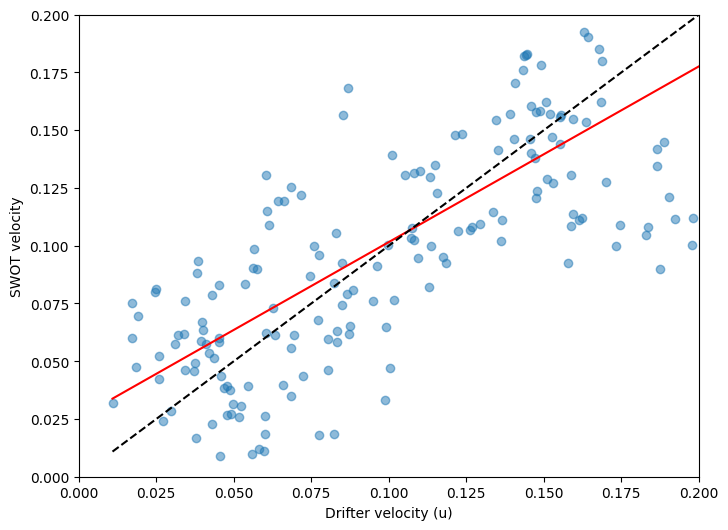

In [898]:
# Fit a linear regression
coeffs = np.polyfit(detrend_ut_adcp, detrend_ut_swot, 1)
fit_line = np.poly1d(coeffs)

# Evaluate the fit line at your x-values
x_vals = detrend_ut_adcp
y_fit = fit_line(x_vals)

# Plot the scatter and regression line
plt.figure(figsize=(8,6))
plt.scatter(x_vals, detrend_ut_swot, label='Data', alpha=0.5)
plt.plot(np.sort(x_vals), fit_line(np.sort(x_vals)), color='red',
         label=f'Fit: y = {coeffs[0]:.2f}x + {coeffs[1]:.2f}')

plt.plot(
    [x_vals.min(), x_vals.max()],
    [x_vals.min(), x_vals.max()],
    linestyle="--",
    color="k",
    label="1:1 Line",
)

plt.xlabel('Drifter velocity (u)')
plt.ylabel('SWOT velocity')
plt.xlim([0,0.2])
plt.ylim([0,0.2])

# plt.xlim([-0.2,0.2])
# plt.ylim([-0.2,0.2])

(-0.2, 0.2)

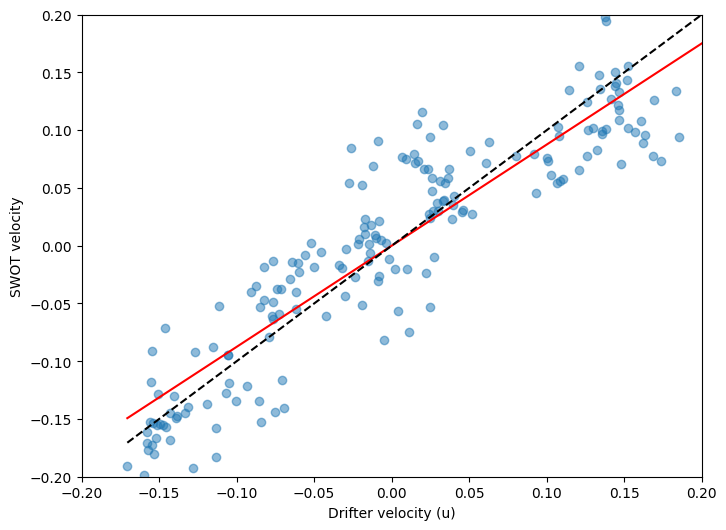

In [899]:
# Fit a linear regression
coeffs = np.polyfit(detrend_v_adcp, detrend_v_swot, 1)
fit_line = np.poly1d(coeffs)

# Evaluate the fit line at your x-values
x_vals = detrend_v_adcp
y_fit = fit_line(x_vals)

# Plot the scatter and regression line
plt.figure(figsize=(8,6))
plt.scatter(x_vals, detrend_v_swot, label='Data', alpha=0.5)
plt.plot(np.sort(x_vals), fit_line(np.sort(x_vals)), color='red',
         label=f'Fit: y = {coeffs[0]:.2f}x + {coeffs[1]:.2f}')

plt.plot(
    [x_vals.min(), x_vals.max()],
    [x_vals.min(), x_vals.max()],
    linestyle="--",
    color="k",
    label="1:1 Line",
)

plt.xlabel('Drifter velocity (u)')
plt.ylabel('SWOT velocity')
plt.xlim([-0.2,0.2])
plt.ylim([-0.2,0.2])

In [900]:
# Combine them into a Dataset
dataset = xr.Dataset({
    'detrend_u_adcp': detrend_u_adcp,
    'detrend_u_swot': detrend_u_swot,
    'detrend_u_swot_uninterp': detrend1_u_swot,
    'detrend_u_avi': detrend_u_avi,
    'detrend_v_adcp': detrend_v_adcp,
    'detrend_v_swot': detrend_v_swot,
    'detrend_v_swot_uninterp': detrend1_v_swot,
    'detrend_v_avi': detrend_v_avi
})

# Print the Dataset
print(dataset)

<xarray.Dataset> Size: 15kB
Dimensions:                  (timec: 184, time_uninterp: 191)
Coordinates:
  * timec                    (timec) datetime64[ns] 1kB 2023-04-01T20:06:32.3...
  * time_uninterp            (time_uninterp) datetime64[ns] 2kB 2023-04-01T19...
    longitude                float64 8B -125.0
    latitude                 float64 8B 35.92
Data variables:
    detrend_u_adcp           (timec) float64 1kB -0.03479 -0.02143 ... 0.00591
    detrend_u_swot           (timec) float64 1kB 0.01449 -0.05177 ... -0.05263
    detrend_u_swot_uninterp  (time_uninterp) float64 2kB 0.02195 ... 0.004298
    detrend_u_avi            (timec) float64 1kB -0.1128 -0.114 ... 0.01966
    detrend_v_adcp           (timec) float64 1kB 0.1832 0.2231 ... 0.0397
    detrend_v_swot           (timec) float64 1kB 0.1338 0.1048 ... 0.03543
    detrend_v_swot_uninterp  (time_uninterp) float64 2kB 0.1252 ... -0.03869
    detrend_v_avi            (timec) float64 1kB 0.07767 0.07155 ... 0.04135


In [901]:
# dataset.to_netcdf('/mnt/flow/swot/calval/Data/NRL/ftp7320.nrlssc.navy.mil/pub/SATELLITE/SSH/detrended_adcp_aviso_swot_timeseries.nc')

In [902]:
detrend1_u_swot

<xarray.DataArray 'u_east_noiseless' (time_uninterp: 191)> Size: 2kB
array([ 2.19496981e-02, -7.74832048e-02, -6.21297160e-02, -2.29703494e-02,
       -1.01225029e-01, -9.75114416e-02, -9.32868224e-02, -9.35885720e-02,
       -2.05713837e-02, -6.54891611e-02, -5.24061171e-02,  1.92017878e-02,
       -1.02971020e-01,  4.54630158e-05, -7.49914256e-02, -9.00475478e-02,
       -6.50393366e-02, -1.23494298e-01, -1.29235976e-01, -1.04763793e-01,
       -7.48883312e-02, -1.62236924e-01, -3.19131686e-02, -6.03083176e-02,
        4.15576431e-03, -3.61367884e-02,  2.41368557e-02,  3.11965711e-02,
        3.71852409e-02,  2.77271100e-02,  5.20168190e-02, -3.60670511e-02,
        3.27372520e-02, -3.69209646e-03,  7.22743569e-03,  1.80613757e-02,
       -2.84474771e-02,  3.27130241e-02, -2.76051784e-02, -5.20134589e-02,
       -2.78850652e-02, -1.38999913e-02, -8.14469062e-02, -1.16463718e-02,
       -9.11632340e-02, -1.01923855e-01,  5.67595864e-03, -5.57034597e-02,
       -2.81755216e-02,  7.77974207e-03, -2.33731150e-02, -2.20004296e-02,
        2.42797135e-02, -2.30883448e-02, -2.59767010e-02, -1.31523632e-03,
        4.34809144e-02,  3.73467951e-02, -5.21723687e-02,  2.20752201e-02,
       -8.47170221e-03,  1.17689732e-01,  2.17795536e-02,  3.63180360e-02,
        1.07509262e-02,  8.04327200e-02, -2.14249309e-02,  1.70012123e-02,
        9.77791610e-02,  8.12780204e-02,  2.29795201e-02,  3.37426607e-02,
        9.27540102e-02,  7.11543882e-02,  8.77795414e-02,  1.22002450e-01,
        8.39998250e-02,  7.84114696e-02,  1.25914700e-01,  4.01292729e-02,
...
        2.18689332e-01,  1.28156588e-01,  9.14503993e-02,  5.95115374e-02,
        3.48123218e-02,  3.45592222e-02,  1.21024952e-02,  1.98826558e-02,
       -1.05716128e-02,  5.54695737e-03, -2.72378151e-02, -5.11120810e-02,
       -1.05671047e-01, -2.35944289e-02, -5.98434018e-02, -1.99571436e-02,
       -6.96586550e-02, -7.52364484e-02, -3.85982023e-02, -9.72788071e-02,
       -6.79620003e-02, -4.85156373e-02, -4.16757508e-02, -4.77790085e-02,
       -4.77648314e-02, -6.92332920e-02,  1.17583647e-02,  4.18843721e-03,
       -3.47984297e-02,  1.95736266e-02, -1.97324863e-02,  1.99690742e-02,
        1.19966668e-02, -5.33362751e-02, -2.78456861e-02, -1.39354016e-01,
       -1.57951912e-02,  3.67857207e-03, -9.44026202e-02,  1.73546027e-03,
        2.88016699e-03, -4.09208349e-02, -2.77479410e-02, -1.95385188e-02,
       -4.94363525e-02, -7.61264572e-03, -7.00519536e-02, -7.21989431e-02,
       -7.05219094e-02, -9.09030109e-02, -7.84817467e-02, -1.80682185e-02,
       -6.88628239e-02, -1.34242527e-02, -5.23980923e-02, -8.58684753e-03,
       -4.84092642e-02, -8.77675915e-02, -7.17148275e-03, -2.45530460e-02,
       -4.44613568e-02, -6.18430749e-02, -8.47159099e-02, -4.46567068e-02,
       -4.91190855e-02, -8.40213403e-02, -5.61847165e-02, -4.23257706e-02,
       -3.13620088e-02, -2.19902002e-02, -5.27102855e-02,  4.39043867e-03,
       -4.11311188e-02, -1.35694914e-02,  1.17784403e-02, -3.49112063e-03,
        3.33381506e-02,  2.42058596e-02,  4.29755655e-03])
Coordinates:
  * time_uninterp  (time_uninterp) datetime64[ns] 2kB 2023-04-01T19:16:51.131...

In [903]:
# Function to compute PSD and confidence intervals
def compute_psd_with_ci(x, fs,nfft,nperseg,noverlap,alpha):
    f, Pxx = welch(x, fs=fs, window = 'hann',nfft=nfft,detrend = 'linear',nperseg=nperseg,scaling='density',axis = 0)
    dof = 2 * (len(x) // nperseg)
    alpha = alpha
    ci_lower = chi2.ppf(alpha / 2, dof) / dof
    ci_upper = chi2.ppf(1 - alpha / 2, dof) / dof
    Pxx_lower = Pxx * ci_lower
    Pxx_upper = Pxx * ci_upper
    return f, Pxx, Pxx_lower, Pxx_upper

In [904]:
# from scipy.signal import welch,csd, coherence
# from scipy.stats import chi2
# fs = 1 / 0.5  # Sampling frequency in Hz (1 sample per 1800 seconds)
# nfft=len(interp_swot.time)
# nperseg = int(nfft/1)
# noverlap = int(nperseg/2)
# scaling = 'density'
# detrend='linear'
# window = 'hann'
# alpha = 0.05
# freq_u, psd_u1,psd_u1_low,psd_u1_up = compute_psd_with_ci(interp_swot.SSHA_noiseless.values, fs ,nfft,nperseg,noverlap,alpha)
# # freq_u, psd_u2,psd_u2_low,psd_u2_up = compute_psd_with_ci(interp_swot.ugosa.values, fs ,nfft,nperseg,noverlap,alpha)
# freq_u, psd_u3,psd_u3_low,psd_u3_up = compute_psd_with_ci(interp_aviso.ugosa.values, fs ,nfft,nperseg,noverlap,alpha)

# freq_u, psd_eke1,psd_eke1_low,psd_eke1_up = compute_psd_with_ci(eke_adcp, fs ,nfft,nperseg,noverlap,alpha)
# freq_u, psd_eke2,psd_u2_low,psd_eke2_up = compute_psd_with_ci(eke_swot, fs ,nfft,nperseg,noverlap,alpha)
# freq_u, psd_eke3,psd_eke3_low,psd_eke3_up = compute_psd_with_ci(eke_avi, fs ,nfft,nperseg,noverlap,alpha)

# freq_v, psd_v1,psd_v1_low,psd_v1_up = compute_psd_with_ci(averaged_adcp_v.values, fs ,nfft,nperseg,noverlap,alpha)
# freq_v, psd_v2,psd_v2_low,psd_v2_up = compute_psd_with_ci(interp_swot.vgosa.values, fs ,nfft,nperseg,noverlap,alpha)
# freq_v, psd_v3,psd_v3_low,psd_v3_up = compute_psd_with_ci(interp_aviso.vgosa.values, fs ,nfft,nperseg,noverlap,alpha)
# f,coh = coherence(averaged_adcp_u.values, interp_swot.ugosa.values, fs=fs, window='hann', nperseg=nperseg, noverlap=noverlap, nfft=nfft, detrend=detrend, axis=0)
# f,coh1 = coherence(averaged_adcp_u.values, interp_aviso.ugosa.values, fs=fs, window='hann', nperseg=nperseg, noverlap=noverlap, nfft=nfft, detrend=detrend, axis=0)

In [905]:
from scipy.stats import chi2# fig, ax = plt.subplots(figsize=(30,20))
# for k, mooring in enumerate(moorings):   

title = '(C) south mooring '
# sh_min, sh_max = -494.4, -494.10
dt = 0.5
sizz = 16; col = 'black';  loc = 'upper right'; lw = 2
######################### spectral analysis
iter1, iter2 = 'ITER10','ITER0'
index = len(interp_aviso.timec)
nw    = 3.0
kspec = 5
nfft = int(index)+1#/2)+1
no = int(index/2) +1
s1_u, s2_u, s3_u = detrend_u_adcp.values, detrend_u_swot.values, detrend_u_avi.values#averaged_adcp_u.data, interp_swot.ugosa.data, interp_aviso.ugosa.data  
s1_v, s2_v, s3_v = detrend_v_adcp.values, detrend_v_swot.values, detrend_v_avi.values#averaged_adcp_v.data, interp_swot.vgosa.data, interp_aviso.vgosa.data  

s1_eke, s2_eke, s3_eke = detrend_eke_adcp.values, detrend_eke_swot.values, detrend_eke_avi.values#averaged_adcp_v.data, interp_swot.vgosa.data, interp_aviso.vgosa.data  

# s1_v, s2_v, s3_v = averaged_adcp_v.data, interp_swot.vgosa.data, interp_aviso.vgosa.data  

# PSD for each signal
Py1_u = MTSpec(s1_u,nw,kspec,dt,nfft=nfft)
Py2_u = MTSpec(s2_u,nw,kspec,dt,nfft=nfft)
Py3_u = MTSpec(s3_u,nw,kspec,dt,nfft=nfft)

Py1_v = MTSpec(s1_v,nw,kspec,dt,nfft=nfft)
Py2_v = MTSpec(s2_v,nw,kspec,dt,nfft=nfft)
Py3_v = MTSpec(s3_v,nw,kspec,dt,nfft=nfft)

Py1_eke = MTSpec(s1_eke,nw,kspec,dt,nfft=nfft)
Py2_eke = MTSpec(s2_eke,nw,kspec,dt,nfft=nfft)
Py3_eke = MTSpec(s3_eke,nw,kspec,dt,nfft=nfft)


freq_u ,psd_u1 = Py1_u.rspec()
freqq ,psd_u2 = Py2_u.rspec()
freqq ,psd_u3 = Py3_u.rspec()

freq ,psd_v1 = Py1_v.rspec()
freqq ,psd_v2 = Py2_v.rspec()
freqq ,psd_v3 = Py3_v.rspec()


freq ,psd_eke1 = Py1_eke.rspec()
freqq ,psd_eke2 = Py2_eke.rspec()
freqq ,psd_eke3 = Py3_eke.rspec()


############ cross SD
P12_u  = MTCross(Py1_u,Py2_u,nw=nw,kspec=kspec,dt=dt,nfft=nfft)
P13_u  = MTCross(Py1_u,Py3_u,nw=nw,kspec=kspec,dt=dt,nfft=nfft)


P12_v  = MTCross(Py1_v,Py2_v,nw=nw,kspec=kspec,dt=dt,nfft=nfft)
P13_v  = MTCross(Py1_v,Py3_v,nw=nw,kspec=kspec,dt=dt,nfft=nfft)


P12_eke  = MTCross(Py1_eke,Py2_eke,nw=nw,kspec=kspec,dt=dt,nfft=nfft)
P13_eke  = MTCross(Py1_eke,Py3_eke,nw=nw,kspec=kspec,dt=dt,nfft=nfft)

coh_u1, phase_u1 = P12_u.mt_corr()
coh_u2, phase_u2 = P13_u.mt_corr()

coh_v1, phase_v1 = P12_v.mt_corr()
coh_v2, phase_v2 = P13_v.mt_corr()

coh_eke1, phase_eke1 = P12_eke.mt_corr()
coh_eke2, phase_eke2 = P13_eke.mt_corr()
freq_u = np.squeeze(freq_u)

# Degrees of freedom for the multitaper method
dof = 2 * nw
alpha = 0.05

# Calculate the 95% confidence intervals
ci_lower = chi2.ppf(alpha / 2, dof) / dof
ci_upper = chi2.ppf(1 - alpha / 2, dof) / dof

psd_u1_low = psd_u1 * ci_lower
psd_u1_up = psd_u1 * ci_upper

psd_u2_low = psd_u2 * ci_lower
psd_u2_up = psd_u2 * ci_upper

psd_u3_low = psd_u3 * ci_lower
psd_u3_up = psd_u3 * ci_upper

psd_v1_low = psd_v1 * ci_lower
psd_v1_up = psd_v1 * ci_upper

psd_v2_low = psd_v2 * ci_lower
psd_v2_up = psd_v2 * ci_upper

psd_v3_low = psd_v3 * ci_lower
psd_v3_up = psd_v3 * ci_upper

psd_eke1_low = psd_eke1 * ci_lower
psd_eke1_up = psd_eke1 * ci_upper

psd_eke2_low = psd_eke2 * ci_lower
psd_eke2_up = psd_eke2 * ci_upper

psd_eke3_low = psd_eke3 * ci_lower
psd_eke3_up = psd_eke3 * ci_upper


In [906]:
coh_u1 = P12_u.cohe
coh_u2 = P13_u.cohe

coh_v1 = P12_v.cohe
coh_v2 = P13_v.cohe

coh_eke1 = P12_eke.cohe
coh_eke2 = P13_eke.cohe


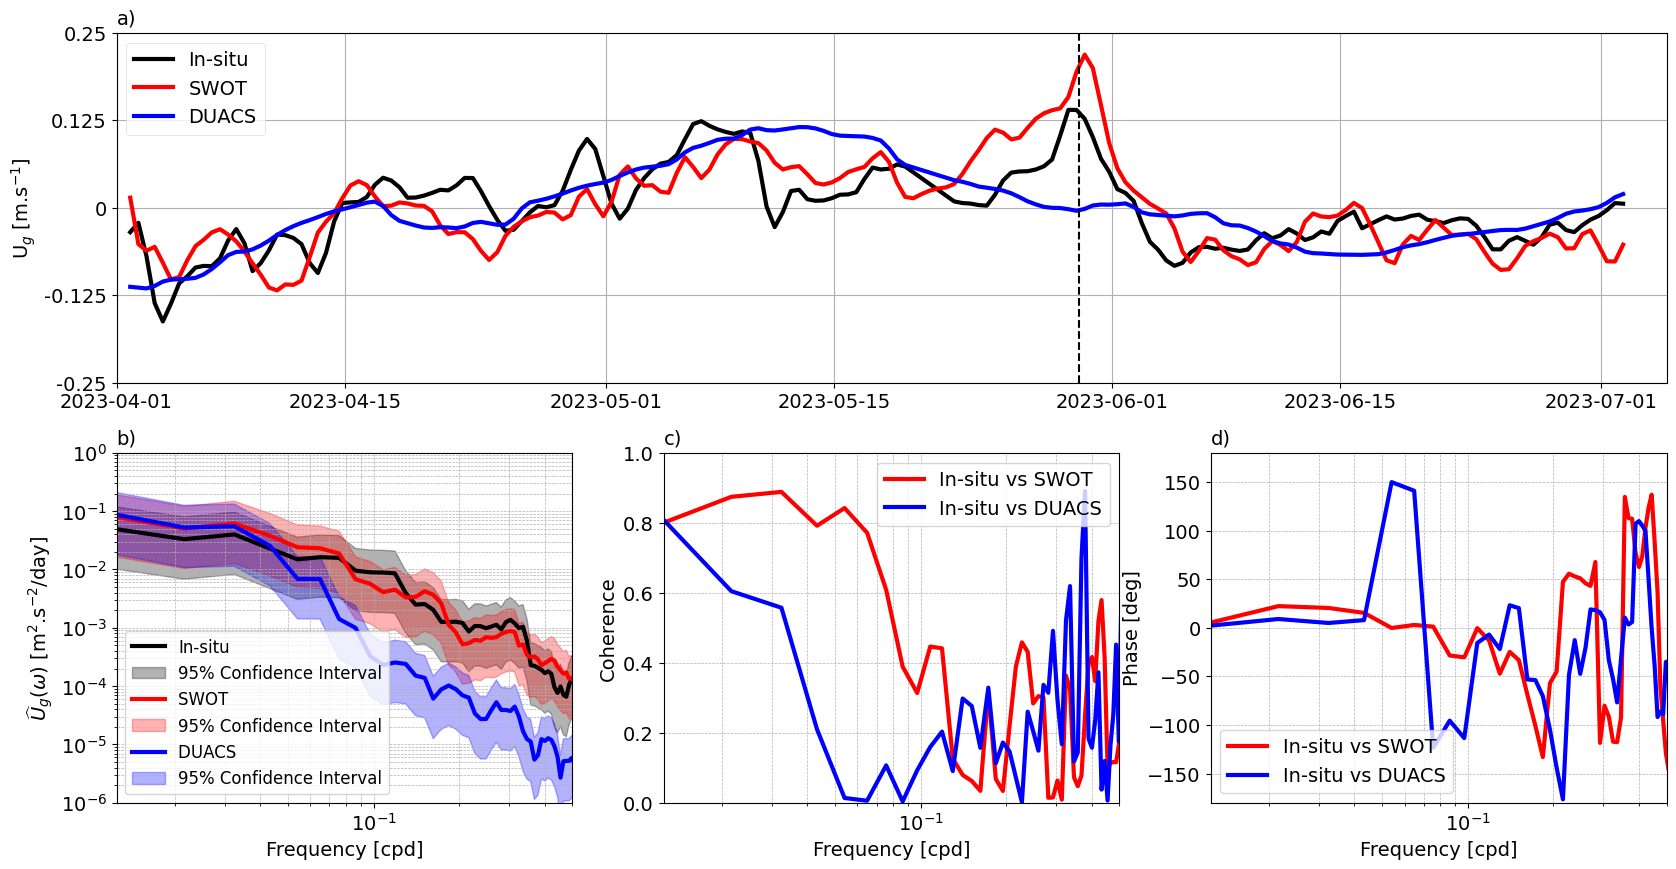

In [909]:

dmin, dmax = -.25,.25#-.25,.25
lw = 3; loc = 'upper left';
############################################################
#############################3 prepare the plot
ifont = 25; unit = '$m$'
sizz = 14; colors = 'gray'; pts = 15
xyfont = 25
xtick = ['2023-04-01','2023-01-15','2023-05-01','2023-05-15',
         '2023-06-01','2023-06-15','2023-07-01','2023-07-05']
xlabel = ['04/01','04/15','05/01','05/15','06/01','06/15','07/01','07/05']
#### set up xlim an y lim
xlim1 = np.datetime64('2023-04-01')
xlim2 = np.datetime64('2023-07-05')
# xticklabels = ['2023-04-01T16', '2023-04-20', '2023-05-09', '2023-05-29','2023-06-18','2023-07-10T23']  # Specify the corresponding tick labels
xmin,xmax = 1/80, 1/2
ymin1,ymax1 = 1E-6, 1E0
locs = 'left'

ytick = [-0.25,-0.125,0,0.125,0.25]
         
ylabel = ['-0.25','-0.125','0','0.125','0.25']

indz = -20

# ##### compute the phase
# phase_u1 = np.angle(psd_u12,deg=True)
# phase_u2 = np.angle(psd_u13,deg=True)

###################################################
# Create subplots
fig = plt.figure(figsize=(20, 10))
gs = GridSpec(2, 3, figure=fig)
# gs = GridSpec(2, 1, height_ratios=[1, 2])

# First row, first column plot
ax1 = fig.add_subplot(gs[0,:])
ax1.plot(interp_aviso.timec,detrend_u_adcp,'k',lw=lw, label='In-situ')
ax1.plot(interp_aviso.timec, detrend_u_swot,'r',lw=lw, label='SWOT')#-np.nanmean(nc_interp.ugosa),'--b')
ax1.plot(interp_aviso.timec, detrend_u_avi,'b',lw=lw, label='DUACS')#-np.nanmean(nc_interp.ugosa),'--b')
ax1.axvline(x=np.datetime64('2023-05-30'), color='k', linestyle='--')

ax1.set_title(f"a)",loc=locs,fontsize=sizz)
ax1.xaxis.set_tick_params(labelsize=sizz)
ax1.yaxis.set_tick_params(labelsize=sizz)
ax1.set_xlim([xlim1, xlim2])
ax1.set_ylim(dmin,dmax)
ax1.xaxis.set_tick_params(labelsize=sizz)
ax1.yaxis.set_tick_params(labelsize=sizz)
# ax.set_xticks(xticks)
# ax.set_xticklabels(xlabel)
ax1.set_yticks(ytick)
ax1.set_yticklabels(ylabel)
legend_properties = {'size':sizz}
lg = plt.legend(loc=loc,prop=legend_properties)
lg.get_frame().set_ec('lightgray')
lg.get_frame().set_lw(0.5)
# ax.set_title('(a)', loc='left',fontsize=sizz,
#          fontweight='bold', color = colors)
# ax.set_xlabel('$Time$',fontsize=sizz)
ax1.set_ylabel('U$_g$ [m.s$^{-1}$]',fontsize=sizz) # regex: ($10log10$)
#title_text = r'$\bf{Standard\ deviation\ computed\ over\ along\ and\ cross\ track}$'
#title = fig.suptitle(title_text, y=0.97, fontsize=sizz)
# title.set_color('blue')
# title.set_bbox(dict(facecolor='white', edgecolor='red', boxstyle='round'))
# plt.tight_layout()
ax1.grid()



# First row, second column plot
ax2 = fig.add_subplot(gs[1, 0])
ax2.loglog(freq_u, psd_u1,'k',lw = lw, label='In-situ')
plt.fill_between(freq_u, np.squeeze(psd_u1_low), np.squeeze(psd_u1_up), color='black', alpha=0.3, label='95% Confidence Interval')
ax2.loglog(freq_u, psd_u2,'r',lw = lw, label='SWOT ')
plt.fill_between(freq_u, np.squeeze(psd_u2_low), np.squeeze(psd_u2_up), color='red', alpha=0.3, label='95% Confidence Interval')
ax2.loglog(freq_u, psd_u3,'b',lw = lw, label='DUACS ')
plt.fill_between(freq_u, np.squeeze(psd_u3_low), np.squeeze(psd_u3_up), color='blue', alpha=0.3, label='95% Confidence Interval')


# plt.semilogy(frequencies_r*3600, power_r, label='Power Spectrum')
# ax2.axvline(x=f_inertial_cph, color='r', linestyle='--', label=f'Inertial Frequency ~{f_inertial_cph:.2f} cph')
# ax2.axvline(x=1/12.4, color='k', linestyle='--', label=f'Semi-diurnal Frequency ~{1/12.4:.2f} cph')
ax2.set_xlim([xmin,xmax])
ax2.set_ylim([ymin1, ymax1])
plt.legend(fontsize=sizz-2)
ax2.set_title(f"b)",loc=locs,fontsize=sizz)
ax2.set_xlabel('Frequency [cpd]',fontsize=sizz)
ax2.set_ylabel(r'$\widehat{U}_g$($\omega$) [m$^2$.s$^{-2}$/day]',fontsize=sizz)
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=sizz)
ax2.yaxis.set_tick_params(labelsize=sizz)
# # Second row, spanning both columns
# First row, second column plot
ax3 = fig.add_subplot(gs[1, 1])
ax3.semilogx(freq_u, coh_u1[:no],'r',lw = lw, label='In-situ vs SWOT')
ax3.semilogx(freq_u, coh_u2[:no],'b',lw = lw, label='In-situ vs DUACS')

# plt.semilogy(frequencies_r*3600, power_r, label='Power Spectrum')
# ax2.axvline(x=f_inertial_cph, color='r', linestyle='--', label=f'Inertial Frequency ~{f_inertial_cph:.2f} cph')
# ax2.axvline(x=1/12.4, color='k', linestyle='--', label=f'Semi-diurnal Frequency ~{1/12.4:.2f} cph')
ax3.set_xlim([xmin,xmax])
ax3.set_ylim([0, 1])
plt.legend(fontsize=sizz)
ax3.set_title(f"c)",loc=locs,fontsize=sizz)
ax3.set_xlabel('Frequency [cpd]',fontsize=sizz)
ax3.set_ylabel(r'Coherence',fontsize=sizz)
ax3.grid(True, which='both', linestyle='--', linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=sizz)
ax3.yaxis.set_tick_params(labelsize=sizz)
# #

# First row, second column plot
ax4 = fig.add_subplot(gs[1, 2])
ax4.semilogx(freq_u, phase_u1[:no],'r',lw = lw, label='In-situ vs SWOT')
ax4.semilogx(freq_u, phase_u2[:no],'b',lw = lw, label='In-situ vs DUACS')

# plt.semilogy(frequencies_r*3600, power_r, label='Power Spectrum')
# ax2.axvline(x=f_inertial_cph, color='r', linestyle='--', label=f'Inertial Frequency ~{f_inertial_cph:.2f} cph')
# ax2.axvline(x=1/12.4, color='k', linestyle='--', label=f'Semi-diurnal Frequency ~{1/12.4:.2f} cph')
ax4.set_xlim([xmin,xmax])
ax4.set_ylim([-180, 180])
plt.legend(fontsize=sizz)
ax4.set_title(f"d)",loc=locs,fontsize=sizz)
ax4.set_xlabel('Frequency [cpd]',fontsize=sizz)
ax4.set_ylabel(r'Phase [deg]',fontsize=sizz)
ax4.grid(True, which='both', linestyle='--', linewidth=0.5)
ax4.xaxis.set_tick_params(labelsize=sizz)
ax4.yaxis.set_tick_params(labelsize=sizz)
# #

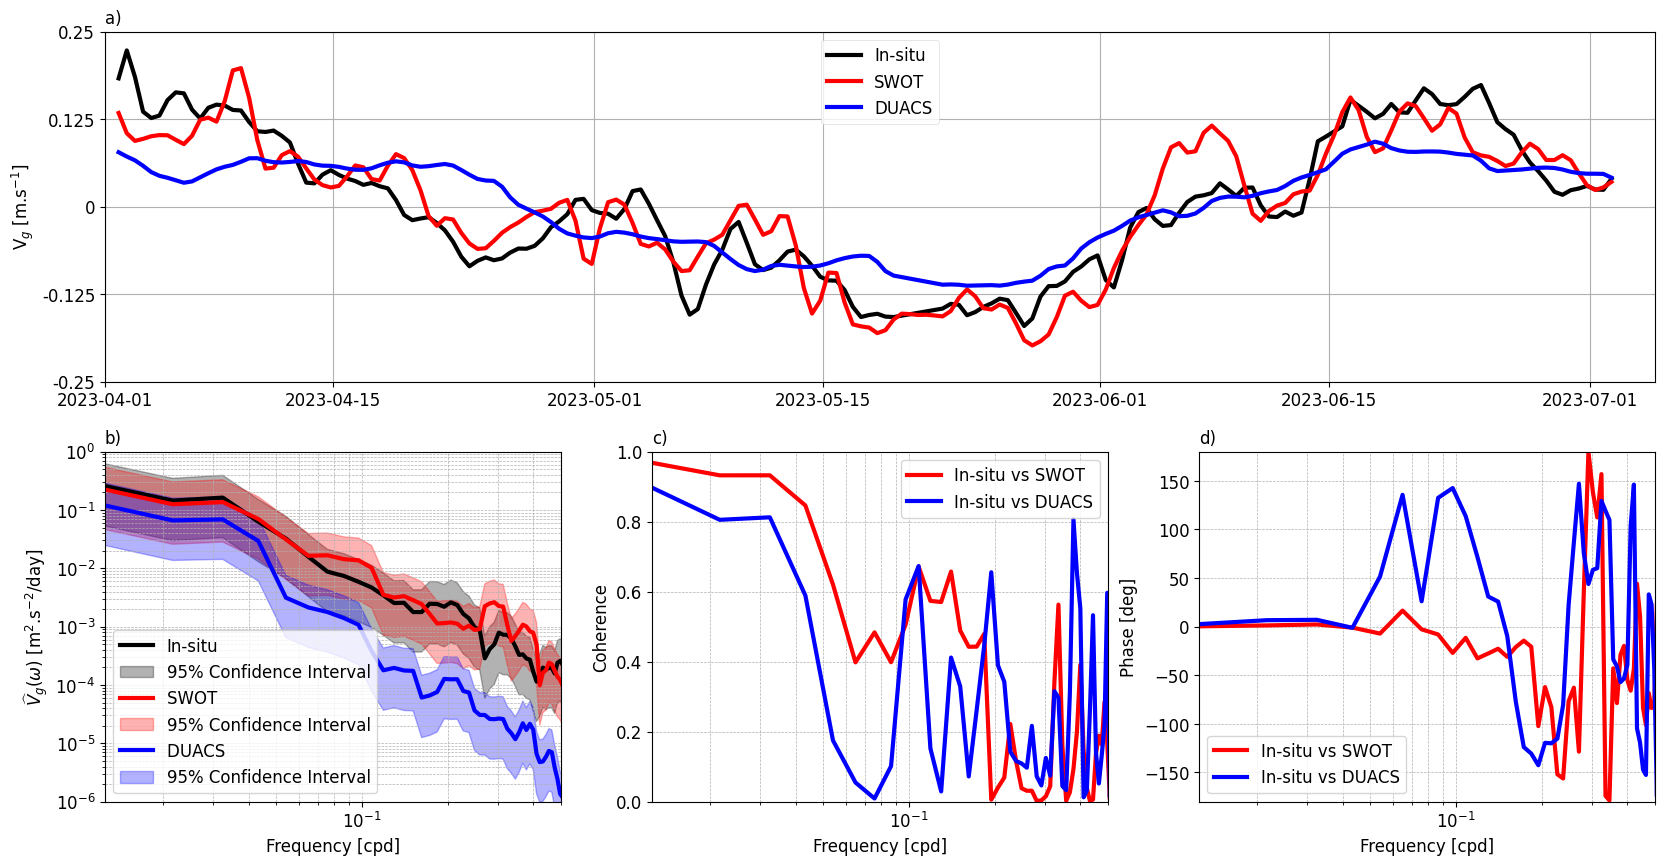

In [910]:
dmin, dmax = -.25,.25#-.25,.25
lw = 3; loc = 'upper left';
############################################################
#############################3 prepare the plot
ifont = 25; unit = '$m$'
sizz = 12; colors = 'gray'; pts = 15
xyfont = 25
xtick = ['2023-04-01','2023-01-15','2023-05-01','2023-05-15',
         '2023-06-01','2023-06-15','2023-07-01','2023-07-05']
xlabel = ['04/01','04/15','05/01','05/15','06/01','06/15','07/01','07/05']
#### set up xlim an y lim
xlim1 = np.datetime64('2023-04-01')
xlim2 = np.datetime64('2023-07-05')
# xticklabels = ['2023-04-01T16', '2023-04-20', '2023-05-09', '2023-05-29','2023-06-18','2023-07-10T23']  # Specify the corresponding tick labels
xmin,xmax = 1/80, 1/2
ymin1,ymax1 = 1E-6, 1E0
locs = 'left'

ytick = [-0.25,-0.125,0,0.125,0.25]
         
ylabel = ['-0.25','-0.125','0','0.125','0.25']


indz = -20
###################################################
# Create subplots
##### compute the phase
# phase_v1 = np.angle(psd_v12,deg=True)
# phase_v2 = np.angle(psd_v13,deg=True)

###################################################
# Create subplots
fig = plt.figure(figsize=(20, 10))
gs = GridSpec(2, 3, figure=fig)
# gs = GridSpec(2, 1, height_ratios=[1, 2])

# gs = GridSpec(2, 1, height_ratios=[1, 2])

# First row, first column plot
ax1 = fig.add_subplot(gs[0,:])
ax1.plot(interp_aviso.timec,detrend_v_adcp,'k',lw=lw, label='In-situ')
ax1.plot(interp_aviso.timec, detrend_v_swot,'r',lw=lw, label='SWOT')#-np.nanmean(nc_interp.ugosa),'--b')
ax1.plot(interp_aviso.timec, detrend_v_avi,'b',lw=lw, label='DUACS')#-np.nanmean(nc_interp.ugosa),'--b')
ax1.set_title(f"a)",loc=locs,fontsize=sizz)
ax1.xaxis.set_tick_params(labelsize=sizz)
ax1.yaxis.set_tick_params(labelsize=sizz)
ax1.set_xlim([xlim1, xlim2])
ax1.set_ylim(dmin,dmax)
ax1.xaxis.set_tick_params(labelsize=sizz)
ax1.yaxis.set_tick_params(labelsize=sizz)
# ax.set_xticks(xticks)
# ax.set_xticklabels(xlabel)
ax1.set_yticks(ytick)
ax1.set_yticklabels(ylabel)
legend_properties = {'size':sizz}
lg = plt.legend(loc='upper center',prop=legend_properties)
lg.get_frame().set_ec('lightgray')
lg.get_frame().set_lw(0.5)
# ax.set_title('(a)', loc='left',fontsize=sizz,
#          fontweight='bold', color = colors)
# ax.set_xlabel('$Time$',fontsize=sizz)
ax1.set_ylabel('V$_g$ [m.s$^{-1}$]',fontsize=sizz) # regex: ($10log10$)
#title_text = r'$\bf{Standard\ deviation\ computed\ over\ along\ and\ cross\ track}$'
#title = fig.suptitle(title_text, y=0.97, fontsize=sizz)
# title.set_color('blue')
# title.set_bbox(dict(facecolor='white', edgecolor='red', boxstyle='round'))
# plt.tight_layout()
ax1.grid()



# First row, second column plot
ax2 = fig.add_subplot(gs[1, 0])
ax2.loglog(freq_u, psd_v1,'k',lw = lw, label='In-situ')
plt.fill_between(freq_u, np.squeeze(psd_v1_low), np.squeeze(psd_v1_up), color='black', alpha=0.3, label='95% Confidence Interval')
ax2.loglog(freq_u, psd_v2,'r',lw = lw, label='SWOT ')
plt.fill_between(freq_u, np.squeeze(psd_v2_low), np.squeeze(psd_v2_up), color='red', alpha=0.3, label='95% Confidence Interval')
ax2.loglog(freq_u, psd_v3,'b',lw = lw, label='DUACS ')
plt.fill_between(freq_u, np.squeeze(psd_v3_low), np.squeeze(psd_v3_up), color='blue', alpha=0.3, label='95% Confidence Interval')


# plt.semilogy(frequencies_r*3600, power_r, label='Power Spectrum')
# ax2.axvline(x=f_inertial_cph, color='r', linestyle='--', label=f'Inertial Frequency ~{f_inertial_cph:.2f} cph')
# ax2.axvline(x=1/12.4, color='k', linestyle='--', label=f'Semi-diurnal Frequency ~{1/12.4:.2f} cph')
ax2.set_xlim([xmin,xmax])
ax2.set_ylim([ymin1, ymax1])
plt.legend(fontsize=sizz)
ax2.set_title(f"b)",loc=locs,fontsize=sizz)
ax2.set_xlabel('Frequency [cpd]',fontsize=sizz)
ax2.set_ylabel(r'$\widehat{V}_g$($\omega$) [m$^2$.s$^{-2}$/day]',fontsize=sizz)
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=sizz)
ax2.yaxis.set_tick_params(labelsize=sizz)
# # Second row, spanning both columns
# First row, second column plot
ax3 = fig.add_subplot(gs[1, 1])
ax3.semilogx(freq_u, coh_v1[:no],'r',lw = lw, label='In-situ vs SWOT')
ax3.semilogx(freq_u, coh_v2[:no],'b',lw = lw, label='In-situ vs DUACS')

# plt.semilogy(frequencies_r*3600, power_r, label='Power Spectrum')
# ax2.axvline(x=f_inertial_cph, color='r', linestyle='--', label=f'Inertial Frequency ~{f_inertial_cph:.2f} cph')
# ax2.axvline(x=1/12.4, color='k', linestyle='--', label=f'Semi-diurnal Frequency ~{1/12.4:.2f} cph')
ax3.set_xlim([xmin,xmax])
ax3.set_ylim([0, 1])
plt.legend(fontsize=sizz)
ax3.set_title(f"c)",loc=locs,fontsize=sizz)
ax3.set_xlabel('Frequency [cpd]',fontsize=sizz)
ax3.set_ylabel(r'Coherence',fontsize=sizz)
ax3.grid(True, which='both', linestyle='--', linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=sizz)
ax3.yaxis.set_tick_params(labelsize=sizz)
# #
# First row, second column plot
ax4 = fig.add_subplot(gs[1, 2])
ax4.semilogx(freq_u, phase_v1[:no],'r',lw = lw, label='In-situ vs SWOT')
ax4.semilogx(freq_u, phase_v2[:no],'b',lw = lw, label='In-situ vs DUACS')

# plt.semilogy(frequencies_r*3600, power_r, label='Power Spectrum')
# ax2.axvline(x=f_inertial_cph, color='r', linestyle='--', label=f'Inertial Frequency ~{f_inertial_cph:.2f} cph')
# ax4.axvline(x=1/6, color='k', linestyle='--')
ax4.set_xlim([xmin,xmax])
ax4.set_ylim([-180, 180])
plt.legend(fontsize=sizz)
ax4.set_title(f"d)",loc=locs,fontsize=sizz)
ax4.set_xlabel('Frequency [cpd]',fontsize=sizz)
ax4.set_ylabel(r'Phase [deg]',fontsize=sizz)
ax4.grid(True, which='both', linestyle='--', linewidth=0.5)
ax4.xaxis.set_tick_params(labelsize=sizz)
ax4.yaxis.set_tick_params(labelsize=sizz)
# #

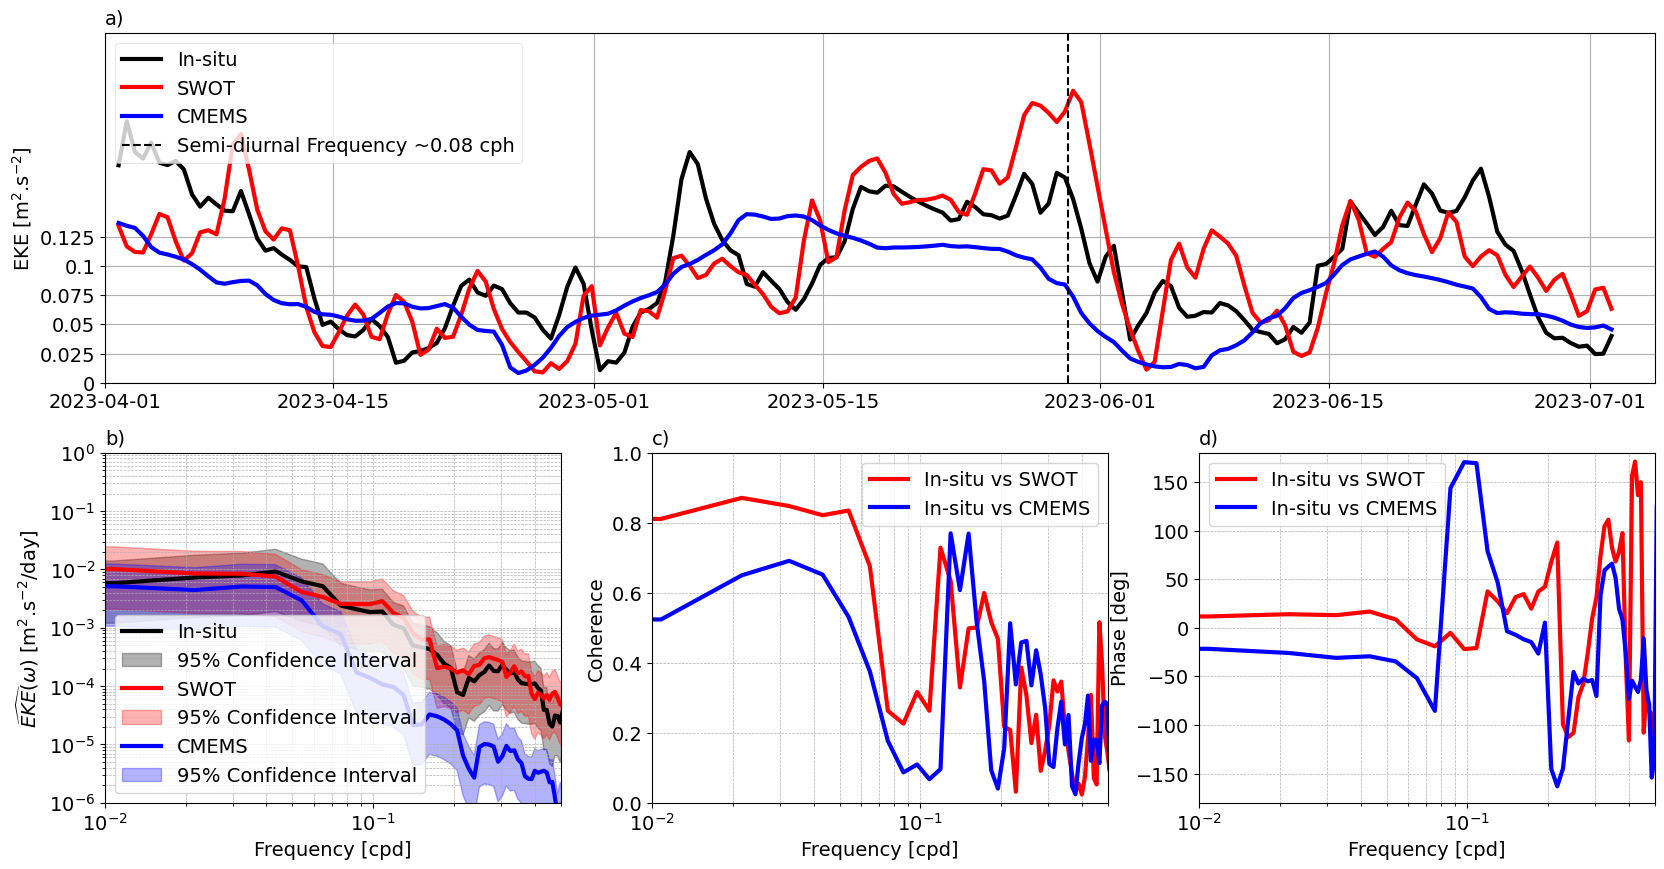

In [843]:

dmin, dmax = 0,.3#-.25,.25
lw = 3; loc = 'upper left';
############################################################
#############################3 prepare the plot
ifont = 25; unit = '$m$'
sizz = 14; colors = 'gray'; pts = 15
xyfont = 25
xtick = ['2023-04-01','2023-01-15','2023-05-01','2023-05-15',
         '2023-06-01','2023-06-15','2023-07-01','2023-07-05']
xlabel = ['04/01','04/15','05/01','05/15','06/01','06/15','07/01','07/05']
#### set up xlim an y lim
xlim1 = np.datetime64('2023-04-01')
xlim2 = np.datetime64('2023-07-05')
# xticklabels = ['2023-04-01T16', '2023-04-20', '2023-05-09', '2023-05-29','2023-06-18','2023-07-10T23']  # Specify the corresponding tick labels
xmin,xmax = 1E-2, 1/2
ymin1,ymax1 = 1E-6, 1E0
locs = 'left'

ytick = [0,0.025,0.05,0.075,0.1,0.125]
         
ylabel = ['0','0.025','0.05','0.075','0.1','0.125']

indz = -20

# ##### compute the phase
# phase_u1 = np.angle(psd_u12,deg=True)
# phase_u2 = np.angle(psd_u13,deg=True)

###################################################
# Create subplots
fig = plt.figure(figsize=(20, 10))
gs = GridSpec(2, 3, figure=fig)
# gs = GridSpec(2, 1, height_ratios=[1, 2])

# First row, first column plot
ax1 = fig.add_subplot(gs[0,:])
ax1.plot(interp_aviso.timec,detrend_ut_adcp,'k',lw=lw, label='In-situ')
ax1.plot(interp_aviso.timec, detrend_ut_swot,'r',lw=lw, label='SWOT')#-np.nanmean(nc_interp.ugosa),'--b')
ax1.plot(interp_aviso.timec, detrend_ut_avi,'b',lw=lw, label='CMEMS')#-np.nanmean(nc_interp.ugosa),'--b')
ax1.axvline(x=np.datetime64('2023-05-30'), color='k', linestyle='--', label=f'Semi-diurnal Frequency ~{1/12.4:.2f} cph')

ax1.set_title(f"a)",loc=locs,fontsize=sizz)
ax1.xaxis.set_tick_params(labelsize=sizz)
ax1.yaxis.set_tick_params(labelsize=sizz)
ax1.set_xlim([xlim1, xlim2])
ax1.set_ylim(dmin,dmax)
ax1.xaxis.set_tick_params(labelsize=sizz)
ax1.yaxis.set_tick_params(labelsize=sizz)
# ax.set_xticks(xticks)
# ax.set_xticklabels(xlabel)
ax1.set_yticks(ytick)
ax1.set_yticklabels(ylabel)
legend_properties = {'size':sizz}
lg = plt.legend(loc=loc,prop=legend_properties)
lg.get_frame().set_ec('lightgray')
lg.get_frame().set_lw(0.5)
# ax.set_title('(a)', loc='left',fontsize=sizz,
#          fontweight='bold', color = colors)
# ax.set_xlabel('$Time$',fontsize=sizz)
ax1.set_ylabel('EKE [m$^{2}$.s$^{-2}$]',fontsize=sizz) # regex: ($10log10$)
#title_text = r'$\bf{Standard\ deviation\ computed\ over\ along\ and\ cross\ track}$'
#title = fig.suptitle(title_text, y=0.97, fontsize=sizz)
# title.set_color('blue')
# title.set_bbox(dict(facecolor='white', edgecolor='red', boxstyle='round'))
# plt.tight_layout()
ax1.grid()



# First row, second column plot
ax2 = fig.add_subplot(gs[1, 0])
ax2.loglog(freq_u, psd_eke1,'k',lw = lw, label='In-situ')
plt.fill_between(freq_u, np.squeeze(psd_eke1_low), np.squeeze(psd_eke1_up), color='black', alpha=0.3, label='95% Confidence Interval')
ax2.loglog(freq_u, psd_eke2,'r',lw = lw, label='SWOT ')
plt.fill_between(freq_u, np.squeeze(psd_eke2_low), np.squeeze(psd_eke2_up), color='red', alpha=0.3, label='95% Confidence Interval')
ax2.loglog(freq_u, psd_eke3,'b',lw = lw, label='CMEMS')
plt.fill_between(freq_u, np.squeeze(psd_eke3_low), np.squeeze(psd_eke3_up), color='blue', alpha=0.3, label='95% Confidence Interval')


# plt.semilogy(frequencies_r*3600, power_r, label='Power Spectrum')
# ax2.axvline(x=f_inertial_cph, color='r', linestyle='--', label=f'Inertial Frequency ~{f_inertial_cph:.2f} cph')
# ax2.axvline(x=1/12.4, color='k', linestyle='--', label=f'Semi-diurnal Frequency ~{1/12.4:.2f} cph')
ax2.set_xlim([xmin,xmax])
ax2.set_ylim([ymin1, ymax1])
plt.legend(fontsize=sizz)
ax2.set_title(f"b)",loc=locs,fontsize=sizz)
ax2.set_xlabel('Frequency [cpd]',fontsize=sizz)
ax2.set_ylabel(r'$\widehat{EKE}$($\omega$) [m$^2$.s$^{-2}$/day]',fontsize=sizz)
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=sizz)
ax2.yaxis.set_tick_params(labelsize=sizz)
# # Second row, spanning both columns
# First row, second column plot
ax3 = fig.add_subplot(gs[1, 1])
ax3.semilogx(freq_u, coh_eke1[:no],'r',lw = lw, label='In-situ vs SWOT')
ax3.semilogx(freq_u, coh_eke2[:no],'b',lw = lw, label='In-situ vs CMEMS')

# plt.semilogy(frequencies_r*3600, power_r, label='Power Spectrum')
# ax2.axvline(x=f_inertial_cph, color='r', linestyle='--', label=f'Inertial Frequency ~{f_inertial_cph:.2f} cph')
# ax2.axvline(x=1/12.4, color='k', linestyle='--', label=f'Semi-diurnal Frequency ~{1/12.4:.2f} cph')
ax3.set_xlim([xmin,xmax])
ax3.set_ylim([0, 1])
plt.legend(fontsize=sizz)
ax3.set_title(f"c)",loc=locs,fontsize=sizz)
ax3.set_xlabel('Frequency [cpd]',fontsize=sizz)
ax3.set_ylabel(r'Coherence',fontsize=sizz)
ax3.grid(True, which='both', linestyle='--', linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=sizz)
ax3.yaxis.set_tick_params(labelsize=sizz)
# #

# First row, second column plot
ax4 = fig.add_subplot(gs[1, 2])
ax4.semilogx(freq_u, phase_eke1[:no],'r',lw = lw, label='In-situ vs SWOT')
ax4.semilogx(freq_u, phase_eke2[:no],'b',lw = lw, label='In-situ vs CMEMS')

# plt.semilogy(frequencies_r*3600, power_r, label='Power Spectrum')
# ax2.axvline(x=f_inertial_cph, color='r', linestyle='--', label=f'Inertial Frequency ~{f_inertial_cph:.2f} cph')
# ax2.axvline(x=1/12.4, color='k', linestyle='--', label=f'Semi-diurnal Frequency ~{1/12.4:.2f} cph')
ax4.set_xlim([xmin,xmax])
ax4.set_ylim([-180, 180])
plt.legend(fontsize=sizz)
ax4.set_title(f"d)",loc=locs,fontsize=sizz)
ax4.set_xlabel('Frequency [cpd]',fontsize=sizz)
ax4.set_ylabel(r'Phase [deg]',fontsize=sizz)
ax4.grid(True, which='both', linestyle='--', linewidth=0.5)
ax4.xaxis.set_tick_params(labelsize=sizz)
ax4.yaxis.set_tick_params(labelsize=sizz)
# #

In [2878]:
print(100*np.std(detrend_u_adcp).values)
print(100*np.std(detrend_v_adcp).values)
print(100*np.std(detrend_eke_adcp).values)
er_u_swot = detrend_u_adcp - detrend_u_swot#(averaged_adcp_u - interp_swot.ugosa).values
er_v_swot = detrend_v_adcp - detrend_v_swot
er_eke_swot = detrend_eke_adcp - detrend_eke_swot

er_u_avi = detrend_u_adcp - detrend_u_avi#(averaged_adcp_u - interp_swot.ugosa).values
er_v_avi = detrend_v_adcp - detrend_v_avi
er_eke_avi = detrend_eke_adcp - detrend_eke_avi

print(f'u std for swot is {100*np.std(detrend_u_swot).values} m/s')
print(f'v std for swot is {100*np.std(detrend_v_swot).values} m/s')
print(f'eke std for swot is {100*np.std(detrend_eke_swot).values} m/s')

print(f'u for swot is {100*np.sqrt(np.nanmean(er_u_swot**2))} m/s')
print(f'v for swot is {100*np.sqrt(np.nanmean(er_v_swot**2))} m/s')
print(f'eke for swot is {100*np.sqrt(np.nanmean(er_eke_swot**2))} m/s')

print(f'u std for aviso is {100*np.std(detrend_u_avi).values} m/s')
print(f'v std for aviso is {100*np.std(detrend_v_avi).values} m/s')
print(f'eke std for aviso is {100*np.std(detrend_eke_avi).values} m/s')

print(f'u for aviso is {100*np.sqrt(np.nanmean(er_u_avi**2))} m/s')
print(f'v for aviso is {100*np.sqrt(np.nanmean(er_v_avi**2))} m/s')
print(f'eke for aviso is {100*np.sqrt(np.nanmean(er_eke_avi**2))} m/s')

5.62787716644139
10.046580862930238
2.599900502456147
u std for swot is 6.612802737737663 m/s
v std for swot is 10.010771161402705 m/s
eke std for swot is 2.8133703898728726 m/s
u for swot is 4.332497702948775 m/s
v for swot is 4.3269700416014585 m/s
eke for swot is 2.04695324340325 m/s
u std for aviso is 5.707697451840216 m/s
v std for aviso is 6.486420748709609 m/s
eke std for aviso is 1.7800908766209065 m/s
u for aviso is 4.714582497003445 m/s
v for aviso is 5.801119427222374 m/s
eke for aviso is 2.3953254008000817 m/s


In [ ]:
5.851036386270922
10.676653569683497
2.7988806268604116
u std for swot is 6.704085242531438 m/s
v std for swot is 10.085090250372945 m/s
eke std for swot is 2.8461870894782444 m/s
u for swot is 4.450783274816876 m/s
v for swot is 4.962815991383942 m/s
eke for swot is 2.3001033876251338 m/s
u std for aviso is 5.707697451840216 m/s
v std for aviso is 6.486420748709609 m/s
eke std for aviso is 1.7800908766209065 m/s
u for aviso is 4.742405526103035 m/s
v for aviso is 6.460934142049251 m/s
eke for aviso is 2.696418335544062 m/s

In [ ]:
print("Correlation coefficient:", np.corrcoef(detrend_u_adcp, detrend_u_swot)[0, 1])
print("Correlation coefficient:", np.corrcoef(detrend_v_adcp, detrend_v_swot)[0, 1])
print("Correlation coefficient:", np.corrcoef(detrend_eke_adcp, detrend_eke_swot)[0, 1])




print("Correlation coefficient:", np.corrcoef(detrend_u_adcp, detrend_u_avi)[0, 1])
print("Correlation coefficient:", np.corrcoef(detrend_v_adcp, detrend_v_avi)[0, 1])
print("Correlation coefficient:", np.corrcoef(detrend_eke_adcp, detrend_eke_avi)[0, 1])



In [ ]:
plt.plot(averaged_adcp_u.time, averaged_adcp_u)
plt.plot(averaged_adcp_u.time, interp_swot.ugosa)

In [ ]:
averaged_adcp_u

## plot the dataset

In [ ]:
dmin, dmax = -.3,.3#-.25,.25
lw = 3; loc = 'upper left'; locs = 'center left'
############################################################
#############################3 prepare the plot
ifont = 25; unit = '$m$'
sizz = 14; colors = 'gray'; pts = 15
xyfont = 25
xtick = ['2023-04-01','2023-01-15','2023-05-01','2023-05-15',
         '2023-06-01','2023-06-15','2023-07-01','2023-07-05']
xlabel = ['04/01','04/15','05/01','05/15','06/01','06/15','07/01','07/05']
#### set up xlim an y lim
xlim1 = np.datetime64('2023-04-01')
xlim2 = np.datetime64('2023-07-05')
# xticklabels = ['2023-04-01T16', '2023-04-20', '2023-05-09', '2023-05-29','2023-06-18','2023-07-10T23']  # Specify the corresponding tick labels


ytick = [-0.3,-0.2,-0.1,0,0.1,0.2,0.3]
         
ylabel = ['-0.3','-0.2','-0.1','0','0.1','0.2','0.3']

indz = -20
###################################################
fig, ax = plt.subplots(figsize=(15,6))  
####### old
ax = plt.subplot(111)
ax.plot(interp_aviso.time,detrend_u_adcp,'k',lw=lw, label='5-day LPF ACDP at '+str(int(z[idz][0]))+' to '+str(int(z[idz][-1]))+'m')
ax.plot(interp_aviso.time, detrend_u_swot,'r',lw=lw, label='SWOT unfiltered, 20km smooth')#-np.nanmean(nc_interp.ugosa),'--b')
ax.plot(interp_aviso.time, detrend_u_avi,'b',lw=lw, label='AVISO')#-np.nanmean(nc_interp.ugosa),'--b')

ax.xaxis.set_tick_params(labelsize=sizz)
ax.yaxis.set_tick_params(labelsize=sizz)
ax.set_xlim([xlim1, xlim2])
ax.set_ylim(dmin,dmax)
ax.xaxis.set_tick_params(labelsize=sizz)
ax.yaxis.set_tick_params(labelsize=sizz)
# ax.set_xticks(xticks)
# ax.set_xticklabels(xlabel)
ax.set_yticks(ytick)
ax.set_yticklabels(ylabel)
legend_properties = {'size':sizz}
lg = plt.legend(loc=loc,prop=legend_properties)
lg.get_frame().set_ec('lightgray')
lg.get_frame().set_lw(0.5)
# ax.set_title('(a)', loc='left',fontsize=sizz,
#          fontweight='bold', color = colors)
# ax.set_xlabel('$Time$',fontsize=sizz)
ax.set_ylabel('U$_g$ [m.s$^{-1}$]',fontsize=sizz) # regex: ($10log10$)
#title_text = r'$\bf{Standard\ deviation\ computed\ over\ along\ and\ cross\ track}$'
#title = fig.suptitle(title_text, y=0.97, fontsize=sizz)
# title.set_color('blue')
# title.set_bbox(dict(facecolor='white', edgecolor='red', boxstyle='round'))
# plt.tight_layout()
ax.grid()


In [ ]:
dmin, dmax = -.3,.3#-.25,.25
lw = 3; loc = 'upper left'; locs = 'center left'
############################################################
#############################3 prepare the plot
ifont = 25; unit = '$m$'
sizz = 14; colors = 'gray'; pts = 15
xyfont = 25
xtick = ['2023-04-01','2023-01-15','2023-05-01','2023-05-15',
         '2023-06-01','2023-06-15','2023-07-01','2023-07-05']
xlabel = ['04/01','04/15','05/01','05/15','06/01','06/15','07/01','07/05']
#### set up xlim an y lim
xlim1 = np.datetime64('2023-04-01')
xlim2 = np.datetime64('2023-07-05')
# xticklabels = ['2023-04-01T16', '2023-04-20', '2023-05-09', '2023-05-29','2023-06-18','2023-07-10T23']  # Specify the corresponding tick labels


ytick = [-0.3,-0.2,-0.1,0,0.1,0.2,0.3]
         
ylabel = ['-0.3','-0.2','-0.1','0','0.1','0.2','0.3']

indz = -20
###################################################
fig, ax = plt.subplots(figsize=(15,6))  
####### old
ax = plt.subplot(111)
ax.plot(interp_aviso.time,detrend_v_adcp,'k',lw=lw, label='5-day LPF ACDP at '+str(int(z[idz][0]))+' to '+str(int(z[idz][-1]))+'m')
ax.plot(interp_aviso.time, detrend_v_swot,'r',lw=lw, label='SWOT unfiltered, 20km smooth')#-np.nanmean(nc_interp.ugosa),'--b')
ax.plot(interp_aviso.time, detrend_v_avi,'b',lw=lw, label='AVISO')#-np.nanmean(nc_interp.ugosa),'--b')

ax.xaxis.set_tick_params(labelsize=sizz)
ax.yaxis.set_tick_params(labelsize=sizz)
ax.set_xlim([xlim1, xlim2])
ax.set_ylim(dmin,dmax)
ax.xaxis.set_tick_params(labelsize=sizz)
ax.yaxis.set_tick_params(labelsize=sizz)
# ax.set_xticks(xticks)
# ax.set_xticklabels(xlabel)
ax.set_yticks(ytick)
ax.set_yticklabels(ylabel)
legend_properties = {'size':sizz}
lg = plt.legend(loc=loc,prop=legend_properties)
lg.get_frame().set_ec('lightgray')
lg.get_frame().set_lw(0.5)
# ax.set_title('(a)', loc='left',fontsize=sizz,
#          fontweight='bold', color = colors)
# ax.set_xlabel('$Time$',fontsize=sizz)
ax.set_ylabel('V$_g$ [m.s$^{-1}$]',fontsize=sizz) # regex: ($10log10$)
#title_text = r'$\bf{Standard\ deviation\ computed\ over\ along\ and\ cross\ track}$'
#title = fig.suptitle(title_text, y=0.97, fontsize=sizz)
# title.set_color('blue')
# title.set_bbox(dict(facecolor='white', edgecolor='red', boxstyle='round'))
# plt.tight_layout()
ax.grid()


In [ ]:
# print("Correlation coefficient:", np.corrcoef(detrend_u_adcp, detrend_u_swot)[0, 1])


print("Correlation coefficient:", np.corrcoef(detrend_u_adcp, detrend_u_swot)[0, 1])
print("Correlation coefficient:", np.corrcoef(detrend_v_adcp, detrend_v_swot)[0, 1])



print(100*(np.nanstd((averaged_adcp_v - interp_aviso.vgosa))))

print("Correlation coefficient:", np.corrcoef(detrend_u_adcp, interp_aviso.ugosa)[0, 1])
print("Correlation coefficient:", np.corrcoef(detrend_v_adcp, detrend_v_avi)[0, 1])



In [ ]:
print(100*(np.nanstd((averaged_adcp_v - interp_swot.vgosa))))


In [ ]:
# print("Correlation coefficient:", np.corrcoef(detrend_u_adcp, detrend_u_swot)[0, 1])


print("Correlation coefficient:", np.corrcoef(averaged_adcp_u, interp_swot.ugosa)[0, 1])
print("Correlation coefficient:", np.corrcoef(averaged_adcp_v, interp_swot.vgosa)[0, 1])




print("Correlation coefficient:", np.corrcoef(detrend_u_adcp, detrend_u_avi)[0, 1])
print("Correlation coefficient:", np.corrcoef(detrend_v_adcp, detrend_v_avi)[0, 1])



In [ ]:
cross_spectrum = xrft.cross_spectrum(detrend_u_adcp, detrend_u_swot, dim=['time'], window='hann')

# Compute the power spectral densities
psd_data1 = xrft.power_spectrum(detrend_u_adcp, dim=['time'], window='hann')
psd_data2 = xrft.power_spectrum(detrend_u_swot, dim=['time'], window='hann')
psd_data3 = xrft.power_spectrum(detrend_u_avi, dim=['time'], window='hann')

# Compute the coherence
coherence = np.abs(cross_spectrum) ** 2 / (psd_data1 * psd_data2)


In [ ]:
# Now you can use flattened_K and flattened_P for plotting
plt.figure(figsize=(8, 5))

plt.loglog(psd_data1.freq_time*3600*24,psd_data1, '-k', label='ADCP')
plt.loglog(psd_data1.freq_time*3600*24,psd_data2, '-r', label='SWOT')
plt.loglog(psd_data1.freq_time*3600*24,psd_data3, '-b', label='AVISO')
plt.title('U velocity')
# plt.axvline(x=1/15, color='k', linestyle='--')
# Adding grid lines
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.ylim([1E-5, 1E4])
plt.xlim([1E-2, 1E0])
plt.xlabel("Wavenumber (cpd)")
plt.ylabel("Power Density")
# plt.title("Power Density vs. Wavenumber")
plt.legend()
plt.show()

In [ ]:
plt.loglog(psd_data1.freq_time*3600*24,psd_data1,'k')
plt.loglog(psd_data1.freq_time*3600*24,psd_data2,'r')
plt.loglog(psd_data1.freq_time*3600*24,psd_data3,'b')

In [ ]:
# Detrend and window the time series
detrend_u_adcp = detrend_u_adcp - np.mean(detrend_u_adcp)
detrend_u_swot = detrend_u_swot - np.mean(detrend_u_swot)
detrend_u_avi = detrend_u_avi - np.mean(detrend_u_avi)

# Compute the cross-spectrum
cross_spectrum = xrft.cross_spectrum(detrend_u_adcp, detrend_u_swot, dim=['time'], window='hann')

# Compute the power spectral densities
psd_data1 = xrft.power_spectrum(detrend_u_adcp, dim=['time'], window='hann')
psd_data2 = xrft.power_spectrum(detrend_u_swot, dim=['time'], window='hann')
psd_data3 = xrft.power_spectrum(detrend_u_avi, dim=['time'], window='hann')

In [ ]:
Uano_adcp = averaged_adcp_u - np.nanmean(averaged_adcp_u)
Vano_adcp = averaged_adcp_v - np.nanmean(averaged_adcp_v)

Uano_swot = interp_swot.ugosa - np.nanmean(interp_swot.ugosa)
Vano_swot = interp_swot.vgosa - np.nanmean(interp_swot.vgosa)

Uano_avi = interp_aviso.ugosa - np.nanmean(interp_aviso.ugosa)
Vano_avi = interp_aviso.vgosa - np.nanmean(interp_aviso.vgosa)
eke_adcp = 1/2*(np.sqrt(Uano_adcp**2+Vano_adcp**2))
eke_avi = 1/2*(np.sqrt(Uano_avi**2+Vano_avi**2))
eke_swot = 1/2*(np.sqrt(Uano_swot**2+Vano_swot**2))

In [ ]:
Uano_adcp = detrend_u_adcp - np.nanmean(detrend_u_adcp)
Vano_adcp = detrend_v_adcp - np.nanmean(detrend_v_adcp)

Uano_swot = detrend_u_swot - np.nanmean(detrend_u_swot)
Vano_swot = detrend_v_swot - np.nanmean(detrend_v_swot)

Uano_avi = detrend_u_avi - np.nanmean(detrend_u_avi)
Vano_avi = detrend_v_avi - np.nanmean(detrend_v_avi)

In [ ]:
eke_adcp = 1/2*(np.sqrt(Uano_adcp**2+Vano_adcp**2))
eke_avi = 1/2*(np.sqrt(Uano_avi**2+Vano_avi**2))
eke_swot = 1/2*(np.sqrt(Uano_swot**2+Vano_swot**2))

In [ ]:
print(100*np.std(eke_adcp).values)
print(100*np.std(eke_avi).values)
print(100*np.std(eke_swot).values)



In [ ]:
dmin, dmax = -.3,.3#-.25,.25
lw = 3; loc = 'upper left'; locs = 'center left'
############################################################
#############################3 prepare the plot
ifont = 25; unit = '$m$'
sizz = 14; colors = 'gray'; pts = 15
xyfont = 25
xtick = ['2023-04-01','2023-01-15','2023-05-01','2023-05-15',
         '2023-06-01','2023-06-15','2023-07-01','2023-07-05']
xlabel = ['04/01','04/15','05/01','05/15','06/01','06/15','07/01','07/05']
#### set up xlim an y lim
xlim1 = np.datetime64('2023-04-01')
xlim2 = np.datetime64('2023-07-05')
# xticklabels = ['2023-04-01T16', '2023-04-20', '2023-05-09', '2023-05-29','2023-06-18','2023-07-10T23']  # Specify the corresponding tick labels


ytick = [-0.3,-0.2,-0.1,0,0.1,0.2,0.3]
         
ylabel = ['-0.3','-0.2','-0.1','0','0.1','0.2','0.3']

indz = -20
###################################################
fig, ax = plt.subplots(figsize=(15,6))  
####### old
ax = plt.subplot(111)
ax.plot(interp_aviso.time,eke_adcp,'k',lw=lw, label='5-day LPF ACDP at '+str(int(z[idz][0]))+' to '+str(int(z[idz][-1]))+'m')
ax.plot(interp_aviso.time, eke_swot,'r',lw=lw, label='SWOT unfiltered, 20km smooth')#-np.nanmean(nc_interp.ugosa),'--b')
ax.plot(interp_aviso.time, eke_avi,'b',lw=lw, label='AVISO')#-np.nanmean(nc_interp.ugosa),'--b')

# ax.xaxis.set_tick_params(labelsize=sizz)
# ax.yaxis.set_tick_params(labelsize=sizz)
ax.set_xlim([xlim1, xlim2])
# ax.set_ylim(dmin,dmax)
# ax.xaxis.set_tick_params(labelsize=sizz)
# ax.yaxis.set_tick_params(labelsize=sizz)
# ax.set_xticks(xticks)
# ax.set_xticklabels(xlabel)
# ax.set_yticks(ytick)
# ax.set_yticklabels(ylabel)
legend_properties = {'size':sizz}
lg = plt.legend(loc=loc,prop=legend_properties)
lg.get_frame().set_ec('lightgray')
lg.get_frame().set_lw(0.5)
# ax.set_title('(a)', loc='left',fontsize=sizz,
#          fontweight='bold', color = colors)
# ax.set_xlabel('$Time$',fontsize=sizz)
ax.set_ylabel('V$_g$ [m.s$^{-1}$]',fontsize=sizz) # regex: ($10log10$)
#title_text = r'$\bf{Standard\ deviation\ computed\ over\ along\ and\ cross\ track}$'
#title = fig.suptitle(title_text, y=0.97, fontsize=sizz)
# title.set_color('blue')
# title.set_bbox(dict(facecolor='white', edgecolor='red', boxstyle='round'))
# plt.tight_layout()
ax.grid()


In [ ]:
# print("Correlation coefficient:", np.corrcoef(detrend_u_adcp, detrend_u_swot)[0, 1])


print("Correlation coefficient:", np.corrcoef(eke_adcp, eke_swot)[0, 1])
print("Correlation coefficient:", np.corrcoef(eke_adcp, eke_avi)[0, 1])



In [ ]:
100*np.sqrt(np.nanmean((eke_adcp - eke_avi)**2))

In [ ]:
100*(np.nanstd((eke_adcp - eke_avi)))

In [ ]:
100*np.sqrt(np.nanmean((eke_adcp - eke_swot)**2))

In [ ]:
from scipy.signal import coherence, welch, get_window
# Define parameters for Welch method
fs = 1 / 0.5  # Sampling frequency
nperseg = len(detrend_u_adcp)  # Length of each segment

# Choose a window function
window = 'hann'  # You can also use 'hamming', 'bartlett', 'blackman', etc.

# Compute coherence using Welch's method with the chosen window function
f, Cxy = coherence(detrend_u_adcp, detrend_u_swot, fs=fs, nperseg=nperseg, window=window)


In [ ]:
Cxy

In [ ]:
print("Correlation coefficient:", np.corrcoef(detrend_u_adcp, detrend_u_swot)[0, 1])


print("Correlation coefficient:", np.corrcoef(averaged_adcp_u, interp_swot.ugosa)[0, 1])


100*(np.nanstd((detrend_v_adcp - detrend_v_swot)))

print("Correlation coefficient:", np.corrcoef(detrend_u_adcp, detrend_u_avi)[0, 1])


In [ ]:
len(detrend_u_adcp)

In [ ]:
scipy.signal.coherence(detrend_u_adcp, detrend_u_swot, fs=1/0.5, window='hann', nperseg=int(len(detrend_u_adcp)/2), noverlap=int(len(detrend_u_adcp)/4), nfft=len(detrend_u_adcp), detrend='linear', axis=-1)

In [ ]:
sub=[1,2,3]
# fig, ax = plt.subplots(figsize=(30,20))
# for k, mooring in enumerate(moorings):   

title = '(C) south mooring '
# sh_min, sh_max = -494.4, -494.10
dt = 0.5
sizz = 16; col = 'black';  loc = 'upper right'; lw = 2
######################### spectral analysis
iter1, iter2 = 'ITER10','ITER0'
index = len(interp_aviso.time)
nw    = 4.0
kspec = 8
nfft = int(index)+1#/2)+1
no = int(index/2) +1
s1, s2, s3 = averaged_adcp_v.data, interp_swot.vgosa.data, interp_aviso.vgosa.data  

# PSD for each signal
Py1 = MTSpec(s1,nw,kspec,dt,nfft=nfft)
Py2 = MTSpec(s2,nw,kspec,dt,nfft=nfft)
Py3 = MTSpec(s3,nw,kspec,dt,nfft=nfft)

freq ,psd_adcp = Py1.rspec()
freqq ,psd_swot = Py2.rspec()
freqq ,psd_avi = Py3.rspec()

############ cross SD
P12  = MTCross(Py1,Py2,nw=nw,kspec=kspec,dt=dt,nfft=nfft)
P13  = MTCross(Py1,Py3,nw=nw,kspec=kspec,dt=dt,nfft=nfft)
P23  = MTCross(Py2,Py3,nw=nw,kspec=kspec,dt=dt,nfft=nfft)
coh_swot, ph_swot = P12.mt_corr()
coh_avi, ph_avi = P13.mt_corr()
# #coh_mo23[mooring], ph_mo23[mooring] = P23.mt_corr()
#     if len(coh_mo[mooring][:no])< len(freq[mooring]):
#         no = no+1
#     else:
#         no = no
# ########### plot

#     axis_values = [50,10,1,1/2, 0.25]
#     label = ['50','10','1','0.5','0.25']
#     xticks = 1./np.array(axis_values)
#     xlabel = label  
#     ch_yticks = [0,0.2,0.4,0.6,0.8,1]
#     ch_ylabel = ['0','0.2','0.4','0.6','0.8','1']
#     ch_xticks = [1/50,1/10,1,1/2,1/0.25]
#     ch_xlabel = ['50','10','1','0.5','0.25']

#     def add_second_axis2(ax1, axis_values):
#          """ Add a x-axis at the top of the spectra figures """
#          ax2 = ax1.twinx() 
#          ax2.set_xscale('log')
#          ax2.set_xlim(ax1.axis()[0], ax1.axis()[1])
#          kp = 1./np.array(axis_values)
#          lp= label#np.array(axis_values)

#          ax2.set_xticks(kp)
#          ax2.set_xticklabels(lp)
#     #     ax2.axes.xaxis.set_ticks([])
#     #     ax2.set_xticks([])
#          # ax2.set_xticks([], minor=True)
#          ax2.axes.yaxis.set_ticks([])

#          # ax2.axes.xaxis.set_ticklabels([]) 
#          # ax2.axes.yaxis.set_ticklabels([])    


#     def add_second_axis(ax1,axis_values):
#          """ Add a x-axis at the top of the spectra figures """
#          ax2 = ax1.twinx() 
#          ax2.set_xscale('log')
#          ax2.set_xlim(ax1.axis()[0], ax1.axis()[1])
#          kp = 1./np.array(axis_values)
#          lp=np.array(axis_values)
#          ax2.set_xticks(kp)
#          ax2.set_xticklabels(lp)
#     #     ax2.axes.xaxis.set_ticks([])
#          # ax2.set_xticks([], minor=True)     
#          ax2.axes.yaxis.set_ticks([])
#     if (mooring == 'north') or (mooring == 'south'):
        
#         xmin, xmax = 1/50, 1/0.25
#     else:
#         xmin, xmax = 1/50, 1/0.25
#     size = 30    
#     ymin, ymax = 1.e-8,1.e0  
#     lw = 4
#     #fig, ax = plt.subplots(figsize=(12, 6))
#     ax = plt.subplot(230+sub[k])
#     ax.loglog(freq[mooring], psd_o[mooring][:no], linestyle='-', lw = lw, marker='',color='k',label ='observations')
#     ax.loglog(freq[mooring], psd_mo[mooring][:no], linestyle='-', lw = lw, marker='',color='r',label ='optimized solution')
#     ax.loglog(freq[mooring], psd_mo1[mooring][:no], linestyle='-', lw = lw, marker='',color='b',label ='first-guess solution')
    
#     ax.set_xlim([xmin, xmax])
#     ax.set_ylim([ymin, ymax])
#     ax.set_xticks(xticks)
#     ax.set_xticklabels(xlabel,fontsize=size)
# #     ax.xaxis.set_tick_params(labelsize=size)
#     if ((mooring == 'middle') or (mooring == 'south')):
#         ax.set_yticks([])
#     ax.yaxis.set_tick_params(labelsize=size)
#     legend_properties = {'size':size-3}
#     lg = plt.legend(loc='upper right',prop=legend_properties,fontsize=14)
#     lg.get_frame().set_ec('lightgray')
#     lg.get_frame().set_lw(0.5)
#     ax.set_xlabel('Time (Days)', fontsize=size)
#     if sub[k]==1:
#         ax.set_ylabel('Power Spectral Density', fontsize=size)
#     plt.title(title, loc='left',fontsize=size,
#              fontweight='bold', color = 'k')
# #     add_second_axis1(ax,axis_values, mooring)    
#     ax.grid() 
#     #plt.show()
#     ################ coherence        
# ymin, ymax = 0,1
# xmin, xmax = 1/50, 3
# lw = 6
# ax = plt.subplot(212)
# ###north mooring
# mooring = 'north'
# index = len(time_concat[mooring])
# no = int(index/2) +1
# print('maman')
# if len(coh_mo[mooring][:no])< len(freq[mooring]):
#     no = no+1
# else:
#     no = no
# ax.semilogx(freq[mooring], abs(coh_mo[mooring][:no]), linestyle='-', lw = lw, marker='',color='darkorange',label ='observations vs '+ iter1)
# ax.semilogx(freq[mooring], abs(coh_mo1[mooring][:no]), linestyle='--', lw = lw, marker='',color='darkorange',label ='observations vs '+ iter2)
# del mooring
# ## middle
# mooring = 'middle'
# index = len(time_concat[mooring])
# no = int(index/2) +1
# if len(coh_mo[mooring][:no])< len(freq[mooring]):
#     no = no+1
# else:
#     no = no
# ax.semilogx(freq[mooring], abs(coh_mo[mooring][:no]), linestyle='-', lw = lw, marker='',color='yellowgreen',label ='observations vs '+ iter1)
# ax.semilogx(freq[mooring], abs(coh_mo1[mooring][:no]), linestyle='--', lw = lw, marker='',color='yellowgreen',label ='observations vs '+ iter2)
# del mooring
# ### south mooring
# mooring = 'south'
# index = len(time_concat[mooring])
# no = int(index/2) +1
# if len(coh_mo[mooring][:no])< len(freq[mooring]):
#     no = no+1
# else:
#     no = no
# ax.semilogx(freq[mooring], abs(coh_mo[mooring][:no]), linestyle='-', lw = lw, marker='',color='m',label ='observations vs '+ iter1)
# ax.semilogx(freq[mooring], abs(coh_mo1[mooring][:no]), linestyle='--', lw = lw, marker='',color='m',label ='observations vs '+ iter2)
# ####################################
# # add_second_axis2(ax,axis_values)
# ax.set_xlim([xmin, xmax])
# ax.set_ylim([ymin, ymax])
# ax.set_xticks(ch_xticks)
# ax.set_xticklabels(ch_xlabel,fontsize=size)
# ax.set_yticks(ch_yticks)
# ax.set_yticklabels(ch_ylabel,fontsize=size)
# # ax.xaxis.set_tick_params(labelsize=size)
# # ax.yaxis.set_tick_params(labelsize=size)
# ax.set_xlabel('Time (Days)', fontsize=size)
# ax.set_ylabel('Coherence to mooring', fontsize=size)
# plt.title('(D)', loc='left',fontsize=size,
#              fontweight='bold', color = 'k')
# ######################
# ### legend for name only
# labels = ['north', 'middle', 'south']
# legend1 = plt.legend(labels, handlelength=0,loc='best', labelcolor=['darkorange', 'yellowgreen', 'm'], prop={'weight':'bold','size': size}, ncol=3)

# ### legend for line
# # Create custom legend items with different colors and markers
# import matplotlib.lines as mlines
# legend_items = [
#     mlines.Line2D([], [], color='k',lw = lw, label='optimized solution'),
#     mlines.Line2D([], [], linestyle='--',lw = lw,color='k', label='first-guess solution')]
# # Add a legend with the custom legend items
# legend2 = plt.legend(handles=legend_items, loc = (1/60, 0.2), prop={'weight':'normal','size': size-4})
# # Add the custom legends to the plot
# plt.gca().add_artist(legend1)
# plt.gca().add_artist(legend2)
# ################
# ax.grid()
# path_fig = r'C:/ECCO_projet/figures/'
# plt.savefig(path_fig+'steric_h/spectral_analysis_optimized_campaign_DA.png',
#          transparent = True, bbox_inches = 'tight', dpi = 300)
# plt.semilogx(freq[mooring], ph_mo[mooring], linestyle='-', lw = lw, marker='',color='k',label ='Obs vs '+ iter1)
# plt.plot(freq[mooring], coh_mo[mooring], linestyle='-', lw = lw, marker='',color='k',label ='Obs vs '+ iter1)

# edof = (len(s1)/(nfft/2)) * abs(coh_mo[mooring]).mean()

# gamma95 = 1.-(0.05)**(1./(edof-1.))
# conf95 = np.where(abs(coh_mo[mooring])>gamma95)

# print('gamma95',gamma95, 'edof',edof)

# # Plot twin plot
# fig, ax1 = plt.subplots(figsize=(12, 6))
# # plot on ax1 the coherence
# p1 = ax1.semilogx(freq[mooring], abs(coh_mo[mooring])[:no], 'k-', lw = lw)
# ax1.set_xlabel('Frequency (Days)')
# ax1.set_ylim([0,1])
# ax1.set_xlim([xmin, xmax])
# add_second_axis1(ax1,axis_values)
# # Make the y-axis label and tick labels match the line color.
# ax1.set_ylabel('Coherence', color='k')
# for tl in ax1.get_yticklabels():
#     tl.set_color('k')

# # plot on ax2 the phase
# ax2 = ax1.twinx()
# p2 = ax2.semilogx(freq[mooring], ph_mo[mooring][:no], 'darkgreen', lw = lw)
# ax2.set_ylabel('Phase (degrees)', color='darkgreen')
# ax2.set_yticks([-180,-135,-90,-45,0,45,90,135,180])
# ax2.set_yticklabels([r'$-\pi$',r'$\frac{-3}{4}\pi$', r'$\frac{-1}{2}\pi$',r'$\frac{-1}{4}\pi$', 
#                      r'$0$', r'$\frac{1}{4}\pi$', r'$\frac{\pi}{2}$', r'$\frac{3}{4}\pi$', r'$\pi$'])
# ax2.set_ylim(-180,180)

# lg = plt.legend([p1,p2], ['cohence: obs. vs '+iter1,'phase: obs. vs '+iter1], ncol=1)
# lg.get_frame().set_ec('lightgray')
# lg.get_frame().set_lw(0.5)
# plt.title(mooring +' Mooring (obs. vs '+iter1+')', loc='left',fontsize=sizz+4,
#          fontweight='bold', color = 'black')
# add_second_axis1(ax1,axis_values)
# for tl in ax2.get_yticklabels():
#     tl.set_color('darkgreen')
# ax1.grid(True)
    


In [ ]:
plt.semilogx(freq, (P12.cohe[:no]),'r')
plt.semilogx(freq, (P13.cohe[:no][:no]),'b')

In [ ]:
# Now you can use flattened_K and flattened_P for plotting
plt.figure(figsize=(8, 5))

# plt.loglog(psd_data1.freq_time*3600*24,psd_data1, '-k', label='ADCP')
plt.semilogx(freq,(P12.cohe[:no]), '-r', label='SWOT')
plt.semilogx(freq,(P13.cohe[:no][:no]), '-b', label='AVISO')
plt.title('U velocity')
# plt.axvline(x=1/15, color='k', linestyle='--')
# Adding grid lines
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.ylim([0, 1])
plt.xlim([1E-2, 1E0])
plt.xlabel("Wavenumber (cpd)")
plt.ylabel("Coherence")
# plt.title("Power Density vs. Wavenumber")
plt.legend()
plt.show()

In [ ]:
plt.semilogx(freq, (P12.cohe[:no]),'r')
plt.semilogx(freq, (P13.cohe[:no][:no]),'b')

In [ ]:
np.abs(cross_spectrum) ** 2 / (psd_data1 * psd_data2)

In [ ]:
plt.loglog(freq, psd_adcp,'k')

plt.loglog(freq, psd_swot,'r')
plt.loglog(freq, psd_avi,'b')

In [ ]:
plt.semilogx(freq, abs(coh_swot[:no]),'r')
plt.semilogx(freq, abs(coh_avi[:no]),'b')

In [ ]:
coh_swot[:no]

In [ ]:
plt.figure(figsize=(10, 5))

plt.plot(swot_combine.time,detrend_u_adcp,'k', label='ACDP at '+str(int(z[indz]))+'m')
# plt.plot(interp_u_aviso.time,(interp_u_aviso[-4,:]**2+interp_u_aviso[-4,:]**2),'r', label='ACDP at 31 m')

# plt.plot(daily_average.time,(interp_u_aviso[-20,:]),'b', label='ACDP at 31 m')
# plt.plot(nc.time, np.nanmean(interp_u_aviso[indz,:],0),'--r')
plt.plot(swot_combine.time, detrend_u_swot,'r', label='SWOT 100km filtered')#-np.nanmean(nc_interp.ugosa),'--b')
plt.plot(swot_combine.time, detrend_u_avi,'b', label='AVISO')#-np.nanmean(nc_interp.ugosa),'--b')

plt.title('zonal velocity at 48 m')
plt.ylim([-.3,.3])
plt.legend()
plt.grid(True)

In [ ]:
interp_u_swot.u_g

In [ ]:
dmin, dmax = -.35,.35#-.25,.25
lw = 3; loc = 'upper left'; locs = 'center left'
############################################################
#############################3 prepare the plot
ifont = 25; unit = '$m$'
sizz = 14; colors = 'gray'; pts = 15
levels = np.linspace(vmin, vmax, pts)
xyfont = 25
xtick = ['2023-04-01','2023-01-15','2023-05-01','2023-05-15',
         '2023-06-01','2023-06-15','2023-07-01','2023-07-15']
xlabel = ['04/01','04/15','05/01','05/15','06/01','06/15','07/01','07/15']
#### set up xlim an y lim
xlim1 = np.datetime64('2023-04-01')
xlim2 = np.datetime64('2023-07-15')
# xticklabels = ['2023-04-01T16', '2023-04-20', '2023-05-09', '2023-05-29','2023-06-18','2023-07-10T23']  # Specify the corresponding tick labels


ytick = [-0.35,-0.3,-0.25,-0.2,-0.15,-0.1,-0.05,0,0.05,0.1,0.15,0.2,0.25,0.3,0.35]
         
ylabel = ['-0.35','-0.3','-0.25','-0.2','-0.15','-0.1','-0.05','0','0.05','0.1','0.15','0.2','0.25','0.3','0.35']

indz = -20
###################################################
fig, ax = plt.subplots(figsize=(18,6))  
####### old
ax = plt.subplot(111)
ax.plot(averaged_nc_avi.time,np.nanmean( interp_v_swot[idz,:],0),'k',lw=lw, label='5-day LPF ACDP at '+str(int(z[idz][0]))+' to '+str(int(z[idz][-1]))+'m')
ax.plot(averaged_nc_avi.time, averaged_nc_swot.v_g,'r',lw=lw, label='SWOT unfiltered')#-np.nanmean(nc_interp.ugosa),'--b')
ax.plot(averaged_nc_avi.time, averaged_nc_avi.vgosa,'b',lw=lw, label='AVISO')#-np.nanmean(nc_interp.ugosa),'--b')

ax.xaxis.set_tick_params(labelsize=sizz)
ax.yaxis.set_tick_params(labelsize=sizz)
ax.set_xlim([xlim1, xlim2])
ax.set_ylim(dmin,dmax)
ax.xaxis.set_tick_params(labelsize=sizz)
ax.yaxis.set_tick_params(labelsize=sizz)
# ax.set_xticks(xticks)
# ax.set_xticklabels(xlabel)
ax.set_yticks(ytick)
ax.set_yticklabels(ylabel)
legend_properties = {'size':sizz}
lg = plt.legend(loc=loc,prop=legend_properties)
lg.get_frame().set_ec('lightgray')
lg.get_frame().set_lw(0.5)
# ax.set_title('(a)', loc='left',fontsize=sizz,
#          fontweight='bold', color = colors)
# ax.set_xlabel('$Time$',fontsize=sizz)
ax.set_ylabel('V$_g$ [m.s$^{-1}$]',fontsize=sizz) # regex: ($10log10$)
#title_text = r'$\bf{Standard\ deviation\ computed\ over\ along\ and\ cross\ track}$'
#title = fig.suptitle(title_text, y=0.97, fontsize=sizz)
# title.set_color('blue')
# title.set_bbox(dict(facecolor='white', edgecolor='red', boxstyle='round'))
# plt.tight_layout()
ax.grid()


In [ ]:
dmin, dmax = -.25,.25
lw = 3; loc = 'lower center'; locs = 'center left'
############################################################
#############################3 prepare the plot
ifont = 25; unit = '$m$'
sizz = 14; colors = 'gray'; pts = 15
levels = np.linspace(vmin, vmax, pts)
xyfont = 25
xtick = ['2023-04-01','2023-01-15','2023-05-01','2023-05-15',
         '2023-06-01','2023-06-15','2023-07-01','2023-07-15']
xlabel = ['04/01','04/15','05/01','05/15','06/01','06/15','07/01','07/15']
#### set up xlim an y lim
xlim1 = np.datetime64('2023-04-01')
xlim2 = np.datetime64('2023-07-15')
# xticklabels = ['2023-04-01T16', '2023-04-20', '2023-05-09', '2023-05-29','2023-06-18','2023-07-10T23']  # Specify the corresponding tick labels


ytick = [-0.25,-0.2,-0.15,-0.1,-0.05,0,0.25,0.2,0.15,0.1,0.05]
         
ylabel = ['-0.25','-0.2','-0.15','-0.1','-0.05','0','0.05','0.1','0.15','0.2','0.25']

indz = -20
###################################################
fig, ax = plt.subplots(figsize=(18,6))  
####### old
ax = plt.subplot(111)
ax.plot(interp_u_aviso.time,(interp_u_swot[indz,:]),'k',lw=lw, label='ACDP at '+str(int(z[indz]))+'m')
ax.plot(result_ds.time, averaged_nc_swot.u_g,'r',lw=lw, label='SWOT 100km filtered')#-np.nanmean(nc_interp.ugosa),'--b')
ax.plot(result_ds.time, averaged_nc_avi.ugosa,'b',lw=lw, label='AVISO')#-np.nanmean(nc_interp.ugosa),'--b')

ax.xaxis.set_tick_params(labelsize=sizz)
ax.yaxis.set_tick_params(labelsize=sizz)
ax.set_xlim([xlim1, xlim2])
ax.set_ylim(dmin,dmax)
ax.xaxis.set_tick_params(labelsize=sizz)
ax.yaxis.set_tick_params(labelsize=sizz)
# ax.set_xticks(xticks)
# ax.set_xticklabels(xlabel)
ax.set_yticks(ytick)
ax.set_yticklabels(ylabel)
legend_properties = {'size':sizz}
lg = plt.legend(loc=loc,prop=legend_properties)
lg.get_frame().set_ec('lightgray')
lg.get_frame().set_lw(0.5)
# ax.set_title('(a)', loc='left',fontsize=sizz,
#          fontweight='bold', color = colors)
# ax.set_xlabel('$Time$',fontsize=sizz)
ax.set_ylabel('U$_g$ [m.s$^{-1}$]',fontsize=sizz) # regex: ($10log10$)
#title_text = r'$\bf{Standard\ deviation\ computed\ over\ along\ and\ cross\ track}$'
#title = fig.suptitle(title_text, y=0.97, fontsize=sizz)
# title.set_color('blue')
# title.set_bbox(dict(facecolor='white', edgecolor='red', boxstyle='round'))
# plt.tight_layout()
ax.grid()


## raw swot plot of zonal (ug) velocity 

In [ ]:
dmin, dmax = -.35,.35#-.25,.25
lw = 3; loc = 'upper center'; locs = 'center left'
############################################################
#############################3 prepare the plot
ifont = 25; unit = '$m$'
sizz = 14; colors = 'gray'; pts = 15
levels = np.linspace(vmin, vmax, pts)
xyfont = 25
xtick = ['2023-04-01','2023-01-15','2023-05-01','2023-05-15',
         '2023-06-01','2023-06-15','2023-07-01','2023-07-15']
xlabel = ['04/01','04/15','05/01','05/15','06/01','06/15','07/01','07/15']
#### set up xlim an y lim
xlim1 = np.datetime64('2023-04-01')
xlim2 = np.datetime64('2023-07-15')
# xticklabels = ['2023-04-01T16', '2023-04-20', '2023-05-09', '2023-05-29','2023-06-18','2023-07-10T23']  # Specify the corresponding tick labels


ytick = [-0.35,-0.3,-0.25,-0.2,-0.15,-0.1,-0.05,0,0.05,0.1,0.15,0.2,0.25,0.3,0.35]
         
ylabel = ['-0.35','-0.3','-0.25','-0.2','-0.15','-0.1','-0.05','0','0.05','0.1','0.15','0.2','0.25','0.3','0.35']

indz = -20
###################################################
fig, ax = plt.subplots(figsize=(18,6))  
####### old
ax = plt.subplot(111)
ax.plot(interp_u_aviso.time,(interp_u_swot[indz,:]),'k',lw=lw, label='ACDP at '+str(int(z[indz]))+'m')
ax.plot(result_ds.time, averaged_nc_swot.u_g,'r',lw=lw, label='SWOT unfiltered')#-np.nanmean(nc_interp.ugosa),'--b')
ax.plot(result_ds.time, averaged_nc_avi.ugosa,'b',lw=lw, label='AVISO')#-np.nanmean(nc_interp.ugosa),'--b')

ax.xaxis.set_tick_params(labelsize=sizz)
ax.yaxis.set_tick_params(labelsize=sizz)
ax.set_xlim([xlim1, xlim2])
ax.set_ylim(dmin,dmax)
ax.xaxis.set_tick_params(labelsize=sizz)
ax.yaxis.set_tick_params(labelsize=sizz)
# ax.set_xticks(xticks)
# ax.set_xticklabels(xlabel)
ax.set_yticks(ytick)
ax.set_yticklabels(ylabel)
legend_properties = {'size':sizz}
lg = plt.legend(loc=loc,prop=legend_properties)
lg.get_frame().set_ec('lightgray')
lg.get_frame().set_lw(0.5)
# ax.set_title('(a)', loc='left',fontsize=sizz,
#          fontweight='bold', color = colors)
# ax.set_xlabel('$Time$',fontsize=sizz)
ax.set_ylabel('U$_g$ [m.s$^{-1}$]',fontsize=sizz) # regex: ($10log10$)
#title_text = r'$\bf{Standard\ deviation\ computed\ over\ along\ and\ cross\ track}$'
#title = fig.suptitle(title_text, y=0.97, fontsize=sizz)
# title.set_color('blue')
# title.set_bbox(dict(facecolor='white', edgecolor='red', boxstyle='round'))
# plt.tight_layout()
ax.grid()


In [ ]:
path_prof = '/mnt/flow/swot/calval/Data/insitu_mooring/JPL_QC/PROFILERS/'
nc_p = xr.open_dataset(path_prof+'SWOTPOSTLAUNCH_L2_JPLQC_MOORING-S2_CTD-PROFILER_START20230303_END20230728_RT_VER002_5s4s_alltimes.nc')

lat_p = nc_p.LATITUDE_GPSSB_STERIC_HEIGHT.values
lon_p = nc_p.LONGITUDE_GPSSB_STERIC_HEIGHT.values

In [ ]:
np.nanmin(lon_p)

In [ ]:
params = {
    'vmin': -0.15,
    'vmax': 0.15,
    'x': 'longitude',
    'y': 'latitude',
    'xlim': (-127, -124),
    'ylim': (32, 39),
    'cmap': 'jet',
    'add_colorbar': False  # Disable individual colorbars
}
# Define the point of interest and radius
lon_s2 = -125.044
lat_s2 = 35.917
radius_km = 10  # Radius in kilometers

# Convert radius from kilometers to degrees (approximation)
radius_deg = radius_km / 111.0  # 1 degree ≈ 111 km

# Plotting SSH variable from nc_swot as an example
plt.figure(figsize=(5, 5))
ax = plt.gca()

# Plot the data
nc_swot['SSH'].isel(time=10).plot(ax=ax,**params)
# scatter plot of lon and lat of s2 function of time
ax.scatter(lon_p,lat_p,color='k')

# Add the circle
circle = plt.Circle((lon_s2, lat_s2), radius_deg, color='red', fill=False, linewidth=2)
ax.add_artist(circle)

# Add the center point
# plt.plot(lon_s2, lat_s2, 'bo')  # Red point at the center


# # Set plot limits to focus on the area of interest
# plt.xlim(lon_s2 - 2*radius_deg, lon_s2 + 2*radius_deg)
# plt.ylim(lat_s2 - 2*radius_deg, lat_s2 + 2*radius_deg)

# plt.title('SSH with Circle around Point of Interest')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.grid(True)

## projection of the mode

In [ ]:
import os 
def qgdecomp(z,N2,f0):
    import numpy as np
    M = D2matrix(z, N2,f0)
    w, vi = np.linalg.eig(M)
    vi = vi[:, np.argsort(w)]
    vi = vi / vi[0,:].reshape(1,-1) #eigenfunction
    w = np.sort(w) #eigenvalue
    return w, vi

In [ ]:
import math

def coriolis_parameter(latitude):
    # Convert latitude from degrees to radians
    latitude_radians = math.radians(latitude)
    
    # Earth's angular velocity in radians per second
    omega = 7.2921e-5
    
    # Compute the Coriolis parameter
    f = 2 * omega * math.sin(latitude_radians)
    
    return f

In [ ]:
def D2matrix(z, N2, f0):
    import numpy as np
    def twopave(x):
        return (x[0:-1]+x[1:])/2.
    """
    construct second-order centered difference matrix
    \frac{\partial}{\partial_z} \frac{f_0^2}{N^2}
    \frac{\partial}{\partial_z}
    """
    #f0 = 1e-4
    N = z.size
    N2c = f0 ** 2 / twopave(N2)  # N2c is the N2 at center point
    dzc = np.diff(z)
    dzf = np.r_[0, twopave(dzc)]
    A = np.zeros((N, N))
    for k in range(1, N - 1):
        A[k, k - 1] = - N2c[k - 1] / (dzc[k - 1] * dzf[k])
        A[k, k] = N2c[k - 1] / (dzc[k - 1] * dzf[k]) + \
                  N2c[k] / (dzc[k] * dzf[k])
        A[k, k + 1] = - N2c[k] / (dzc[k] * dzf[k])

    A[0, 0] = N2c[0] / dzc[0] ** 2
    A[0, 1] = -A[0, 0]
    A[-1, -1] = N2c[-1] / dzc[-1] ** 2
    A[-1, -2] = -A[-1, -1]
    return A

In [ ]:
def D2matrix(z, N2, f0):
    import numpy as np
    def twopave(x):
        return (x[0:-1]+x[1:])/2.
    """
    construct second-order centered difference matrix
    \frac{\partial}{\partial_z} \frac{f_0^2}{N^2}
    \frac{\partial}{\partial_z}
    """
    #f0 = 1e-4
    N = z.size
    N2c = f0 ** 2 / N2  # N2c is the N2 at center point
    dzc = np.diff(z)
    dzf = np.r_[0, twopave(dzc)]
    A = np.zeros((N, N))
    for k in range(1, N - 1):
        A[k, k - 1] = - N2c[k - 1] / (dzc[k - 1] ** 2)
        A[k, k] = N2c[k - 1] / (dzc[k - 1] **2) + \
                  N2c[k] / (dzc[k] **2)
        A[k, k + 1] = - N2c[k] / (dzc[k] **2)

    A[0, 0] = N2c[0] / dzc[0] ** 2
    A[0, 1] = -A[0, 0]
    A[-1, -1] = N2c[-1] / dzc[-1] ** 2
    A[-1, -2] = -A[-1, -1]
    return A

In [ ]:
path_fixed = '/mnt/flow/swot/Analysis_Luke/Moorings2/DATA/FIXED/'
path_prof = '/mnt/flow/swot/Analysis_Luke/Moorings2/DATA/PROF/'

nc_f = xr.open_dataset(path_fixed+'SWOTPOSTLAUNCH_L2_JPLQC_MOORING-S1_CTD-FIXED_START20230303_END20230917_DM_VER01.nc')
nc_p = xr.open_dataset(path_prof+'SWOTPOSTLAUNCH_L2_JPLQC_MOORING-P1_CTD-PROFILER-BOTH_START20230218_END20230918_DM_VER01_5s4s_alltimes.nc')

In [ ]:
density_1 = nc_p.RHO_TIMEMEAN.values
depth_1 = nc_p.RHO_TIMEMEAN_DEPTH.values

density_2 = nc_f.RHO_TIMEMEAN.values
depth_2 = nc_f.RHO_TIMEMEAN_DEPTH.values

In [ ]:
density_combined = np.concatenate((density_1, density_2[depth_2 > depth_1[-1]]))

depth_combined = np.concatenate((depth_1, depth_2[depth_2 > depth_1[-1]]))

In [ ]:
plt.plot(density_combined, -depth_combined)

In [ ]:
np.diff(density_combined)

In [ ]:
# n2 = []; depth=[]
# g=9.81; rho0=1035
# for i in range(1,len(depth_1)):
#     if not np.isnan(density_1[i-1]) and not np.isnan(density_1[i]):
#         n2.append((g/rho0)*((density_1[i] - density_1[i-1])/(depth_1[i] - depth_1[i-1])))
#         depth.append(depth_1[i])
        
                  
# depth = np.array(depth)
# n2 = np.array(n2)     

In [ ]:
n2 = []; depth=[]
g=9.81; rho0=1035
for i in range(1,len(depth_combined)):
    if not np.isnan(density_combined[i-1]) and not np.isnan(density_combined[i]):
        n2.append((g/rho0)*((density_combined[i] - density_combined[i-1])/(depth_combined[i] - depth_combined[i-1])))
        depth.append(depth_combined[i])
        
                  
depth = np.array(depth)
n2 = np.array(n2)

In [ ]:
# Find the indices where the condition is true
indices = np.where((depth >= 495) & (depth <= 520))

# Use the indices to assign np.nan
n2[indices] = np.nan
notnan = ~np.isnan(n2)

In [ ]:
plt.plot(n2,-np.asarray(depth))

In [ ]:
from scipy.interpolate import interp1d
interp_N2 = interp1d(depth[notnan], n2[notnan], kind='linear', bounds_error=False)

# Interpolated buoyancy frequency values at the original depth points
interp_N2_values = interp_N2(depth_combined)

In [ ]:
N2 = interp_N2_values[12:-180]
Depth = np.asarray(depth_combined[12:-180]) ### I start by 12 because below 12 there are N2<0
f0 = coriolis_parameter(latitude) ## coriolis parameter

In [ ]:
depth_combined.shape

In [ ]:
plt.plot(N2,-Depth)
plt.ylim([-3000,-1])

In [ ]:
N2

## convert the density to the baroclinic mode

In [ ]:
w,vi = qgdecomp(Depth,N2,f0)

In [ ]:
w,vi = qgdecomp(depth[12:-6],N2[12:-6],f0)

In [ ]:
w,vi = qgdecomp(depth[12:-20],n2[12:-20],f0)

In [ ]:
Depth

In [ ]:
vi[:, 0]

In [ ]:
modes_to_plot = 4
dz=1

for i in range(1, modes_to_plot + 1):
    plt.plot(vi[:, i], -Depth, label=f'Mode {i}')
    # Highlight zero crossings
    zero_crossings = np.where(np.diff(np.sign(vi[:, i])))[0]
    # plt.scatter(zero_crossings * dz, np.zeros(len(zero_crossings)), color='red', zorder=5)
    plt.axvline(x=0, color='k', linestyle='--')
    # plt.xlim([-1,1])


plt.xlabel('Vertical Structure Function')
plt.ylabel('Depth (m)')
plt.title('Baroclinic Modes')
plt.legend()
plt.grid()

In [ ]:
adcp_data = {
    'u': da_cleaned_v.values,
    'v': da_cleaned_v.values
}

In [ ]:
da_cleaned_v.depth

In [ ]:
baroclinic_modes = vi[:,:11]
# Interpolate the baroclinic modes to the ADCP depths
interpolated_modes = np.zeros((len(z), baroclinic_modes.shape[1]))

for i in range(baroclinic_modes.shape[1]):
    f_interp = interp1d(Depth, baroclinic_modes[:, i], kind='cubic', fill_value='extrapolate')
    interpolated_modes[:, i] = f_interp(-z)

In [ ]:
interpolated_modes.shape

In [ ]:
z

In [ ]:
plt.plot(interpolated_modes[:,1:4],z)

In [ ]:
# Interpolate ADCP data to match baroclinic mode depths
nt = da_cleaned_v.shape[1]
mode_depths = Depth
nz_mode = len(mode_depths)

u_interp = np.zeros((nz_mode, nt))
v_interp = np.zeros((nz_mode, nt))


for t in range(nt):
    u_interp[:, t] = interp1d(-da_cleaned_v.depth.values, adcp_data['u'][:, t], kind='linear', bounds_error=False, fill_value=np.nan)(mode_depths)
    v_interp[:, t] = interp1d(-da_cleaned_v.depth.values, adcp_data['v'][:, t], kind='linear', bounds_error=False, fill_value=np.nan)(mode_depths)


In [ ]:
# Compute EKE
u_prime = u_interp - np.nanmean(u_interp, axis=1, keepdims=True)
v_prime = v_interp - np.nanmean(v_interp, axis=1, keepdims=True)
EKE = 0.5 * (u_prime**2 + v_prime**2)

In [ ]:
da_cleaned_v.depth.values

In [ ]:
tick = [-0.1,-0.08,-0.06,-0.04,-0.02,0,0.02,0.04,0.06,0.08,0.1]
fs = 12
fig = plt.figure(figsize=(12, 6))
ct1 = plt.contourf(datetime_array[:-1],-Depth,u_interp, levels = np.linspace(-0.1,0.1,20), cmap='bwr',extend='both')
# plt.ylim([-2000,0])
plt.xlim([pd.Timestamp('2023-05-01 00:25:25'), pd.Timestamp('2023-05-14 00:25:25')])
plt.title('Meridional velocity (V) over 2-weeks after dealing with nan values',fontsize=fs+4)
# plt.xlabel('Frequency (days)')
plt.ylabel('Depth (m)',fontsize=fs)
cb_ax = fig.add_axes([0.91, 0.2, 0.02, 0.65])
cb = fig.colorbar(ct1, cax=cb_ax, ticks = tick,
                    extend = 'both')
cb.ax.tick_params(labelsize=fs)
#cbar.ax.set_title(cb,fontsize=sc_font)
cb.set_label('m.s$^{-1}$',fontsize=fs)
plt.grid(True)
plt.show()

In [ ]:
notnan = ~np.isnan(u_interp[:,100])

In [ ]:
alpha = np.linalg.lstsq(vi[notnan,0:632], EKE[notnan,:])[0]

In [ ]:
alpha = np.linalg.solve(A, b)[0]

In [ ]:
vi[notnan,0:632].shape

In [ ]:
from scipy.linalg import solve
A = vi[notnan,0:20]#np.random.random((3, 3))
b = u_interp[notnan,100]#np.random.random(3)
# rslt = solve(A, b)

In [ ]:
cond_number = np.linalg.cond(A[:,0:50])
print("Condition number of A:", cond_number)


In [ ]:
A1 = A[0:500:,0:100]  # 5 rows, 10 columns
A1_pinv = np.linalg.pinv(A1)

# Verify A @ A_pinv
identity1 = A1 @ A1_pinv
#print("A1 @ A1_pinv (should be close to identity matrix):\n", identity1)


In [ ]:
A[0:500,100]

In [ ]:
np.linalg.det(A1)

In [ ]:
rank_A = np.linalg.matrix_rank(A)
print("Rank of matrix A:", rank_A)

In [ ]:
np.linalg.pinv(A1)@A1  

In [ ]:
x = np.linalg.pinv(A) @ b

In [ ]:
# Condition number of A
cond_number = np.linalg.cond(A[:,:4])
print("Condition number of A:", cond_number)


In [ ]:
A@(x)

In [ ]:
b

In [ ]:
import cvxpy

def solve(A, B):
    """
    Minimizes |AX - B|**2, assuming A and B are 
    square matrices for simplicity. If this optimized 
    error is zero, this corresponds to solving AX = B.
    """
    n = A.shape[0]
    X = cvxpy.Variable((n))
    # Set objective
    obj_fun = cvxpy.sum_squares(A*X - B)
    objective = cvxpy.Minimize(obj_fun)
    # Set constraints
    constraints = [X >= 0]
    prob = cvxpy.Problem(objective, constraints)
    result = prob.solve(solver = "ECOS")
    return X.value

rr=solve(A,b)

In [ ]:
rr

In [ ]:
A1 = np.random.random((5, 10))  # 5 rows, 10 columns
A1_pinv = np.linalg.pinv(A1)

# Verify A @ A_pinv
identity1 = A1 @ A1_pinv
print("A1 @ A1_pinv (should be close to identity matrix):\n", identity1)


In [ ]:
A@ np.linalg.pinv(A)

In [ ]:
(A @ rslt)

In [ ]:
EKE[notnan,:]

In [ ]:
aa = np.dot(np.linalg.inv(A), b) 

In [ ]:
A @ aa

In [ ]:
alpha[:,10]

In [ ]:
U_reconstructed = vi[notnan,1:11] @ alpha


In [ ]:
U_reconstructed==EKE[notnan,:]

In [ ]:
# Filter out rows with NaN values
notnan = ~np.isnan(EKE).any(axis=1)#~np.isnan(vi).any(axis=0) & ~np.isnan(EKE).any(axis=0)

# Ensure vi and EKE have no inf or NaN values
vi_filtered = vi[1:4, 1:4]  # Selecting columns 1 to 10 for vi
EKE_filtered = EKE[1:4, 100]  # Keeping all columns for EKE

# Solve the least-squares problem
alpha = np.linalg.lstsq(vi_filtered, EKE_filtered, rcond=None)[0]

In [ ]:
EKE_filtered

In [ ]:
alpha

In [ ]:
# Define the matrix vi
vi = A[1:100,1:5]

# Define the EKE vector
EKE = b[1:100]

# Compute the least-squares solution
alpha, residuals, rank, s = np.linalg.lstsq(vi, EKE, rcond=None)

print("Computed alpha:", alpha)
print("Residuals:", residuals)
print("Rank of matrix vi:", rank)
print("Singular values of vi:", s)

# Verify the solution by computing vi @ alpha
EKE_reconstructed = np.dot(vi, alpha)
print("Reconstructed EKE:", EKE_reconstructed)

In [ ]:
vi

In [ ]:
# Compute the least-squares solution
alpha, residuals, rank, s = np.linalg.lstsq(vi, EKE, rcond=None)

print("Computed alpha:", alpha)
print("Residuals:", residuals)
print("Rank of matrix vi:", rank)
print("Singular values of vi:", s)

# Verify the solution by computing vi @ alpha
EKE_reconstructed = np.dot(vi, alpha)
print("Reconstructed EKE:", EKE_reconstructed)

# Check how close the reconstructed EKE is to the original EKE
is_close = np.allclose(EKE, EKE_reconstructed, atol=1e-10)
print("Is the reconstructed EKE close to the original EKE?", is_close)
reconstruction_error = np.linalg.norm(EKE - EKE_reconstructed)
print("Reconstruction error:", reconstruction_error)

In [ ]:
alpha.shape

In [ ]:
plt.bar(np.arange(1, alpha.shape[0]+1), abs(alpha[:, 2000]))
# plt.xlim([1,11])
    

In [ ]:
plt.bar(np.arange(1, alpha.shape[0]+1), (alpha[:, 2000]))

In [ ]:
plt.figure(figsize=(12, 8))
plt.bar(range(len(alpha)), alpha)
plt.xlabel('Mode Number')
plt.ylabel('Coefficient')
plt.title('Projection Coefficients')
plt.show()

In [ ]:
alpha


In [ ]:
# Compute EKE
u_prime = u_interp - np.nanmean(u_interp, axis=1, keepdims=True)
v_prime = v_interp - np.nanmean(v_interp, axis=1, keepdims=True)
EKE = 0.5 * (u_prime**2 + v_prime**2)

In [ ]:
# Project observed currents onto baroclinic modes
projection_coeffs_u = np.dot(vi.T, u_prime)
projection_coeffs_v = np.dot(vi.T, v_prime)

# Compute energy for each mode
mode_energies = np.zeros((nz_mode, nt))

for i in range(nz_mode):
    mode_energies[i, :] = 0.5 * (projection_coeffs_u[i, :]**2 + projection_coeffs_v[i, :]**2)
# Compute average energy for each mode over time
average_mode_energies = np.nansum(mode_energies, axis=1)#np.nanmean(mode_energies, axis=1)

In [ ]:
projection_coeffs_u.shape

In [ ]:
# Plot the distribution of kinetic energy over the first four vertical modes
plt.figure(figsize=(12, 6))
plt.plot(vi[:,1:4], average_mode_energies[:], color='blue', alpha=0.7)
plt.xlabel('Mode Number')
plt.ylabel('Total Kinetic Energy')
plt.title('Distribution of Kinetic Energy over the First Four Vertical Modes')
plt.grid()
plt.show()

In [ ]:
first_four_modes = average_mode_energies[:4]
modes = np.arange(1, 5)
# Plot the distribution of kinetic energy over the first four vertical modes
plt.figure(figsize=(12, 6))
plt.bar(modes, first_four_modes, color='r', alpha=1)
plt.xlabel('Mode Number')
plt.ylabel('Total Kinetic Energy')
plt.title('Distribution of Kinetic Energy over the First 10 Vertical Modes')
plt.grid()
plt.show()

In [ ]:
# Compute total kinetic energy for each mode over all time steps
total_mode_energies = np.nansum(mode_energies, axis=1)

# Normalize the total kinetic energy for each mode
normalized_mode_energies = total_mode_energies / np.sum(total_mode_energies)

# Ensure the sum of the normalized energies is 1
assert np.isclose(np.sum(normalized_mode_energies), 1), "Normalization failed, total energy does not sum up to 1."


In [ ]:
# Select the first four modes
first_four_modes = normalized_mode_energies[:400]
modes = np.arange(1, 401)

# Plot the distribution of kinetic energy over the first four vertical modes
plt.figure(figsize=(12, 6))
plt.bar(modes, first_four_modes, color='blue', alpha=0.7)
plt.xlabel('Mode Number')
plt.ylabel('Normalized Kinetic Energy')
plt.title('Normalized Distribution of Kinetic Energy over the First Four Vertical Modes')
plt.grid()
plt.show()

In [ ]:
np.sum(normalized_mode_energies)

In [ ]:
np.sum(average_mode_energies)

In [ ]:
normalized_mode_energies = average_mode_energies / np.sum(average_mode_energies)

In [ ]:
S2

In [ ]:
# mask = ds['qc_flag'] == 0
Depth_s1 = S1['DEPTH'].where(S1['QC_FLAG'] == 0)
Density_s1 = S1['RHO'].where(S1['QC_FLAG'] == 0)

Depth_s2 = S2['DEPTH'].where(S2['QC_FLAG'] == 0)
Density_s2 = S2['RHO'].where(S2['QC_FLAG'] == 0)

Depth_s3 = S3['DEPTH'].where(S3['QC_FLAG'] == 0)
Density_s3 = S3['RHO'].where(S3['QC_FLAG'] == 0)

Depth_s4 = S4['DEPTH'].where(S4['QC_FLAG'] == 0)
Density_s4 = S4['RHO'].where(S4['QC_FLAG'] == 0)


In [ ]:
RHO_0 = 1029

# Define a cutoff depth for data
CUTOFF_DEPTH = [445, 470, 475, 425, 425, 475, 475, 500, 500, 500, 500]

# Calculate the mean density profile from S1-4 and use it as a reference
dz_meanprof = 1
Z_meanprof = 500

RHO_TIMEMEAN_DEPTH = np.arange(0, Z_meanprof + dz_meanprof, dz_meanprof)
RHO_TIMEMEAN_OB = np.full_like(np.zeros(len(RHO_TIMEMEAN_DEPTH)), np.nan)

RHO_TIMEMEAN_OB.shape

for zi in range(1,501,1):
    # Calculate the mean density at the current depth level
    RHO_TIMEMEAN_OB[zi] = np.nanmean(np.concatenate((
        S1.RHO[(S1.QC_FLAG == 0) & (S1.DEPTH > RHO_TIMEMEAN_DEPTH[zi] - dz_meanprof/2) & (S1.DEPTH < RHO_TIMEMEAN_DEPTH[zi] + dz_meanprof/2)],
        S2.RHO[(S2.QC_FLAG == 0) & (S2.DEPTH > RHO_TIMEMEAN_DEPTH[zi] - dz_meanprof/2) & (S2.DEPTH < RHO_TIMEMEAN_DEPTH[zi] + dz_meanprof/2)],
        S3.RHO[(S3.QC_FLAG == 0) & (S3.DEPTH > RHO_TIMEMEAN_DEPTH[zi] - dz_meanprof/2) & (S3.DEPTH < RHO_TIMEMEAN_DEPTH[zi] + dz_meanprof/2)],
        S4.RHO[(S4.QC_FLAG == 0) & (S4.DEPTH > RHO_TIMEMEAN_DEPTH[zi] - dz_meanprof/2) & (S4.DEPTH < RHO_TIMEMEAN_DEPTH[zi] + dz_meanprof/2)]
    )))

In [ ]:
diff(RHO_TIMEMEAN_OB[10:])

In [ ]:

# Initialize lists to store mean densities and depths
mean_densities = []
common_depths = []

# Compute the weighted mean density at each unique depth
for depth in unique_depths:
    densities = []
    
    if depth in Depth_s1:
        densities.append(Density_s1[Density_s1['DEPTH'] == depth].values[0])
    if depth in Depth_s2:
        densities.append(Density_s2[Density_s2['DEPTH'] == depth].values[0])
    if depth in Depth_s3:
        densities.append(Density_s3[Density_s3['DEPTH'] == depth].values[0])
    if depth in Depth_s4:
        densities.append(Density_s4[Density_s4['DEPTH'] == depth].values[0])
    
    mean_density = np.mean(densities)
    mean_densities.append(mean_density)
    common_depths.append(depth)

# Create a DataFrame for the mean density profile
mean_density_profile = pd.DataFrame({
    'Depth': common_depths,
    'Mean_Density': mean_densities
})

In [ ]:
def compute_weighted_mean(desired_depths, depths, densities):
    """Compute weighted mean density at desired depths."""
    mean_densities = []
    for depth in desired_depths:
        # Find all densities within a small range around the desired depth
        weights = 1.0 / np.abs(depths - depth)  # Inverse distance weights
        close_indices = np.abs(depths - depth) < 1  # Consider data points within 1 meter
        if np.sum(close_indices) > 0:
            weighted_mean = np.average(densities[close_indices], weights=weights[close_indices])
            mean_densities.append(weighted_mean)
        else:
            mean_densities.append(np.nan)
    return mean_densities

In [ ]:
desired_depths = np.arange(0, 501, 1)

In [ ]:
compute_weighted_mean(desired_depths, Depth_s1, Density_s1)

In [ ]:
path_fixed = '/mnt/flow/swot/Analysis_Luke/Moorings2/DATA/FIXED/'
path_prof = '/mnt/flow/swot/Analysis_Luke/Moorings2/DATA/PROF/'

nc_f = xr.open_dataset(path_fixed+'SWOTPOSTLAUNCH_L2_JPLQC_MOORING-S1_CTD-FIXED_START20230303_END20230917_DM_VER01.nc')
nc_p = xr.open_dataset(path_prof+'SWOTPOSTLAUNCH_L2_JPLQC_MOORING-P1_CTD-PROFILER-BOTH_START20230218_END20230918_DM_VER01_5s4s_alltimes.nc')

In [ ]:
plt.plot( nc_f.RHO_TIMEMEAN, -nc_f.RHO_TIMEMEAN_DEPTH,)

In [ ]:
nc_f

In [ ]:
rho = nc_p.RHO_TIMEMEAN.values
rho_depth = nc_p.RHO_TIMEMEAN_DEPTH.values

In [ ]:
np.diff(rho)

In [ ]:
n2 = []; depth=[]
g=9.81; rho0=1035
for i in range(1,len(rho_depth)):
    if not np.isnan(rho_depth[i-1]) and not np.isnan(rho_depth[i]):
        n2.append((g/rho0)*((rho[i] - rho[i-1])/(rho_depth[i] - rho_depth[i-1])))
        depth.append(rho_depth[i])
        
                  
depth = np.array(depth)
n2 = np.array(n2)        

In [ ]:
plt.plot(n2[6:-6], -depth[6:-6])

In [ ]:
n2

### read the aviso

In [ ]:
nc

In [ ]:
lon_s2 = -125.044
lat_s2 = 35.917
nc_interp = nc.interp(longitude=lon_s2, latitude=lat_s2, method='linear')

interp_u_aviso = filt_u.interp(time=nc.time, method='linear')

In [ ]:
plt.plot(nc.time, interp_u_aviso[-10,:],'--r')
plt.plot(nc.time, nc_interp.ugosa,'--b')

In [ ]:
indz = np.where(z>-500)[0]

In [ ]:
indz.shape

In [ ]:
np.nanmean(nc_interp.ugosa)

In [ ]:
plt.plot(nc.time, np.nanmean(interp_u_aviso[indz,:],0),'--r')
plt.plot(nc.time, nc_interp.ugosa-np.nanmean(nc_interp.ugosa),'--b')

In [ ]:
plt.plot(nc.time, (interp_u_aviso[indz,:]),'--r')
plt.plot(nc.time, nc_interp.ugosa-np.nanmean(nc_interp.ugosa),'--b')

In [ ]:
daily_average = da_u.resample(time="1D").mean().interp(time=nc.time)

In [ ]:
plt.figure(figsize=(10, 5))

plt.plot(daily_average.time,np.nanmean(daily_average[indz,:],0),'r', label='ACDP 0-500m averaged')
# plt.plot(nc.time, np.nanmean(interp_u_aviso[indz,:],0),'--r')
plt.plot(nc.time, nc_interp.ugosa,'k', label='AVISO')#-np.nanmean(nc_interp.ugosa),'--b')
plt.title('zonala velocity')
plt.legend()
plt.grid(True)


In [ ]:
z[-20]

In [ ]:
plt.figure(figsize=(10, 5))

plt.plot(daily_average.time,(daily_average[-20,:]),'r', label='ACDP at 31 m')
# plt.plot(daily_average.time,(interp_u_aviso[-20,:]),'b', label='ACDP at 31 m')
# plt.plot(nc.time, np.nanmean(interp_u_aviso[indz,:],0),'--r')
plt.plot(nc.time, nc_interp.ugosa,'k', label='AVISO')#-np.nanmean(nc_interp.ugosa),'--b')
plt.title('zonala velocity at 48 m')
plt.legend()
plt.grid(True)

In [ ]:
nc_interp

In [ ]:
# Plotting the Power Spectral Density
lw=2
ymin, ymax = 1E-5, 1E5
xmin, xmax = 1E-2, 50
plt.figure(figsize=(10, 5))
plt.loglog(omega*24, shps[-1,:],color='r', lw = lw, label='Zonal velocity')
plt.loglog(frequencies_u*3600*24, power_u,color='k', lw = lw, label='Zonal velocity')
# plt.loglog(frequencies_v*3600*24, power_v,color='b', lw = lw, label='Meridional velocity')
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
# Add vertical lines at 12h and 24h frequencies
plt.axvline(x=2, color='k', linestyle='--')
plt.axvline(x=1, color='k', linestyle='--')
plt.axvline(x=0.5, color='k', linestyle='--')
dp = z[idz]
plt.title(f"Power Spectral Density (PSD) at {dp:.2f} m")
plt.xlabel('Frequency (days$^{-1}$)')
plt.ylabel(r'PSD (m$^2$.s$^{-3}$)',fontsize=fs+10)#('PSD (V^2/Hz)')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
(shps.freq_time*60*60*24).max()

In [ ]:
tick = [-0.1,-0.08,-0.06,-0.04,-0.02,0,0.02,0.04,0.06,0.08,0.1]
fs = 12
fig = plt.figure(figsize=(12, 6))
ct1 = plt.contourf(da_cleaned.time,da_cleaned.depth,da_cleaned.data, levels = np.linspace(-0.1,0.1,20), cmap='bwr',extend='both')
plt.ylim([-2000,0])
plt.xlim([pd.Timestamp('2023-05-01 00:25:25'), pd.Timestamp('2023-05-14 00:25:25')])
plt.title('Meridional velocity (V) over 2-weeks after dealing with nan values',fontsize=fs+4)
# plt.xlabel('Frequency (days)')
plt.ylabel('Depth (m)',fontsize=fs)
cb_ax = fig.add_axes([0.91, 0.2, 0.02, 0.65])
cb = fig.colorbar(ct1, cax=cb_ax, ticks = tick,
                    extend = 'both')
cb.ax.tick_params(labelsize=fs)
#cbar.ax.set_title(cb,fontsize=sc_font)
cb.set_label('m.s$^{-1}$',fontsize=fs)
plt.grid(True)
plt.show()

In [ ]:
z.shape

In [ ]:
da_cleaned.depth.shape

In [ ]:
a= np.where((da_cleaned.depth.values >= -550) &(da_cleaned.depth.values <= -549.5))[0][0]
print('the index is ', idz)
print('the depth is ', z[idz])

In [ ]:
da_cleaned.depth.values[0]

In [ ]:
# # Sampling frequency in Hz (2 samples per hour, every 30 minutes)
# fs = 2
# # Convert 48 hours period to frequency
# fc = 1 / 48  # cutoff frequency in cycles per hour

# # Calculate normalized cutoff frequency (fs/2 = 1 for 30-minute sampling)
# Wn = 2 * fc / fs

# # Design Butterworth filter
# b, a = butter(N=4, Wn=Wn, btype='low', analog=False)

# # Apply the filter
# filtered_data = filtfilt(b, a, interp_u_values[:,:-1], axis=1)
data_filt = filter_butter(interp_u_values[:,:-1],fc,fs, btype='low',filter_order=4,axis=1)


In [ ]:
plt.figure(figsize=(12, 6))
# plt.plot(datetime_array[:-1], filtered_data[-1,:],'r')
plt.plot(datetime_array[:-1], data_filt[-1,:],'--b')
# plt.xlim([pd.Timestamp('2023-05-01 00:25:25'), pd.Timestamp('2023-05-07 00:25:25')])

In [ ]:
plt.figure(figsize=(12, 6))
# plt.plot(time, u[-1,:],'r')
plt.plot(time, velocity[-100,:],'b')
plt.plot(datetime_array[:-1], data_filt[-1,:],'r')


In [ ]:
time

In [ ]:
from scipy.signal import welch
# Compute the Power Spectral Density
fs = 1 / (30 * 60)  # Sampling frequency in Hz (1 sample per 1800 seconds)
npt=len(datetime_array[:-1])
noverlap = int(npt/2)  # Overlap between segments
frequencies, power = welch(data_filt[-500,:-1],window = 'hann',nfft = npt,
                                                             fs=fs,

                                                             nperseg=npt,
                                                             scaling='density',
                                                             noverlap=noverlap)#, nperseg=256)

# Plotting the Power Spectral Density
plt.figure(figsize=(10, 5))
plt.loglog(frequencies*3600*24, power)
# Add vertical lines at 12h and 24h frequencies
plt.axvline(x=2, color='k', linestyle='--')
plt.axvline(x=1, color='k', linestyle='--')
plt.axvline(x=0.5, color='k', linestyle='--')

plt.title('Power Spectral Density (PSD) of Current Time Series')
plt.xlabel('Frequency (days)')
plt.ylabel('PSD (V^2/Hz)')
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
plt.contourf(datetime_array[:-1],z,data_filt, levels = np.linspace(-0.05,0.05,20), cmap='bwr',extend='both')
plt.ylim([-2000,0])
# plt.xlim([pd.Timestamp('2023-05-01 00:25:25'), pd.Timestamp('2023-05-14 00:25:25')])

In [ ]:
z[-500]

In [ ]:
import pywt
# Sample data preparation (replace with your actual data)
# Assuming interp_u_values is your data array and is already loaded
data = interp_u_values[1:-2]  # Adjust according to your data

# Time vector creation for plotting
time_vector = np.linspace(0, len(data), num=len(data), endpoint=False)

# Define parameters for the CWT
f_c = 0.849  # Center frequency for cmor wavelet
max_freq = frequencies.max()  # Maximum frequency of interest
min_freq = 0.0001  # about one cycle every 5.5 hours

# Calculate scales for given frequencies
min_scale = f_c * fs / max_freq
max_scale = f_c * fs / min_freq

# Generate scales logarithmically spaced
scales = np.logspace(np.log10(min_scale), np.log10(max_scale), num=100)

# Now, scales will be used for the Continuous Wavelet Transform (CWT)
print("Min scale:", min_scale, "Max scale:", max_scale)
print("Scales:", scales)

# # Calculate corresponding scales
# min_scale = f_c * fs / max_freq
# max_scale = f_c * fs / min_freq

# # Generate scales logarithmically spaced
# scales = np.logspace(np.log10(min_scale), np.log10(max_scale), num=100)

# scales = np.arange(1, npt)  # Range of scales to perform the wavelet transform
wavelet_name = 'cmor'  # Complex Morlet wavelet

# Perform the Continuous Wavelet Transform
coefficients, freq = pywt.cwt(data, scales, wavelet_name, 1/fs)

# Plot the CWT power spectrum
extent = [datetime_array[1], datetime_array[-3], 1/(3600*freq.min()), 1/(3600*freq.max())]  # Adjusted for data slice [1:-2]
plt.figure(figsize=(12, 6))
plt.imshow(np.abs(coefficients), extent=extent,
           cmap='jet', aspect='auto', vmax=0.1, vmin=0)
plt.colorbar(label='Magnitude')
plt.title('Continuous Wavelet Transform (CWT) of Current Time Series')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (seconds)')
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(datetime_array, interp_u_values, lw = 2, color = 'r')

In [ ]:
freq.max()

In [ ]:
frequencies.max()

In [ ]:
1/ (0.0001 *3600)

In [ ]:
max_freq

In [ ]:
datetime_array_days

In [ ]:
nc = xr.open_dataset('/mnt/flow/swot/Matt_Analysis/CNES_L3_CalVal/SWOT_L3_LR_SSH_Basic_477_026_20230401T185120_20230401T194224_v0.3.nc')

In [ ]:
nc


In [ ]:
nc['longitude'] -= 360

In [ ]:
ssha = nc.ssha.values

In [ ]:
ds = nc.where((nc.longitude >= -127) & (nc.longitude <= -124) & (nc.latitude >= 32) & (nc.latitude <= 39), drop=True)

In [ ]:
ds

In [ ]:
plt.pcolor(ds.longitude,ds.latitude,ds.ssha,cmap ='jet',vmin=-0.15,vmax=0.15)


In [ ]:
import numpy as np

# Define scales in km
scales_km = [5, 10, 25,50,70]

# Compute windows based on the actual resolution of the data
windows = {
    scale: (
        np.outer(
            np.hanning(int(scale / 2) * 2 + 1),  # Along-track window, 2 km per pixel
            np.hanning(int(scale / 10) * 2 + 1)  # Cross-track window, 10 km per pixel
        )
    )
    for scale in scales_km
}

# Normalize the windows
for window in windows.values():
    window /= window.sum()

In [ ]:
from scipy.signal import convolve2d
data = ds.ssha.values
def apply_hann_filter(data, window):
    def filter_func(data_section):
        valid = ~np.isnan(data_section)
        if np.all(~valid):
            return np.nan
        valid_data = data_section[valid]
        valid_window = window.reshape(data_section.shape)[valid]
        return (valid_data * valid_window).sum() / valid_window.sum()

    filtered_data = xr.apply_ufunc(
        lambda x: convolve2d(x, window, mode='same', boundary='fill', fillvalue=np.nan),
        data,
        input_core_dims=[['alontrack', 'crosstrack']],
        output_core_dims=[['alontrack', 'crosstrack']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[float]
    )
    return filtered_data

# Assuming 'data' is your xarray DataArray
filtered_data = {f'{scale}km': apply_hann_filter(ssh_data, windows[scale]) for scale in scales_km}

In [ ]:
plt.pcolor(ds.longitude, ds.latitude,filtered_data['25km'],vmin=-0.15,vmax=0.15,cmap='jet')


In [ ]:
ssh_data = ds.ssha.values

In [ ]:
# Function to interpolate NaNs in a 2D array
def interpolate_nans(data):
    try:
        from scipy.interpolate import griddata
        x, y = np.indices(data.shape)
        points = np.array((x[~np.isnan(data)], y[~np.isnan(data)])).T
        values = data[~np.isnan(data)]
        data_interp = griddata(points, values, (x, y), method='linear')
        return np.where(np.isnan(data), data_interp, data)
    except ImportError:
        print("Scipy is required for this function")
        return data

# Apply interpolation
ssh_data = interpolate_nans(ssh_data)

In [ ]:
from scipy.ndimage import gaussian_filter

50/6

In [ ]:
# Define sigma values based on scales
sigmas = {
    '5km': 0.83 / 2,  # Dividing by resolution if needed
    '10km': 1.67 / 2,
    '25km': 4.17 / 2,
    '150km': 8.33 / 2
}

# Apply Gaussian filter for each scale
smoothed_data_5km = gaussian_filter(ssh_data, sigma=sigmas['5km'], mode='nearest')
smoothed_data_10km = gaussian_filter(ssh_data, sigma=sigmas['10km'], mode='nearest')
smoothed_data_25km = gaussian_filter(ssh_data, sigma=sigmas['25km'], mode='nearest')
smoothed_data_150km = gaussian_filter(ssh_data, sigma=sigmas['150km'], mode='nearest')



In [ ]:
# ds['SSH'] = xr.DataArray(smoothed_data_150km, dims=('num_lines', 'num_pixels'), coords=ds.ssha.coords)
# ds['grad_ssh_y'] = xr.DataArray(np.gradient(ds.SSH, axis=0) / dy, dims=('num_lines', 'num_pixels'), coords=ds.SSH.coords)
ds['SSH'] = xr.DataArray(filtered_data['25km'], dims=('num_lines', 'num_pixels'), coords=ds.ssha.coords)

In [ ]:
plt.pcolor(ds.longitude,ds.latitude,ssh_data,cmap ='jet')


In [ ]:
ssh_data[1,:]

In [ ]:
plt.pcolor(ds.longitude,ds.latitude,smoothed_data_150km,cmap ='jet')


In [ ]:
plt.pcolor(ds.longitude,ds.latitude,smoothed_data_10km,cmap ='jet')


In [ ]:
plt.pcolor(ds.longitude,ds.latitude,smoothed_data_25km,cmap ='jet')


In [ ]:
# ds = ds.rename({'ssha': 'SSH'})

da = compute_geostrophic_velocities(ds)

plt.pcolor(ds.longitude,ds.latitude,da.u_g,vmin = -1, vmax = 1, cmap ='jet')

In [ ]:
plt.pcolor(ds.longitude,ds.latitude,da.v_g,vmin = -1, vmax = 1, cmap ='jet')

In [ ]:
plt.pcolor(ds.longitude,ds.latitude,np.sqrt(da.v_g**2+da.u_g**2),vmin = 0, vmax = .4, cmap ='jet')
plt.title('along and cross-track')

In [ ]:
# Flatten the arrays
lon_flat = lon.flatten()
lat_flat = lat.flatten()
ssh_flat = ssha.flatten()

# Prepare matrix for polynomial fitting
X = np.column_stack((lon_flat, lat_flat, lon_flat*lat_flat, lon_flat**2, lat_flat**2))

In [ ]:
# Fit the polynomial using least squares
coeff, residuals, rank, s = np.linalg.lstsq(X, ssh_flat, rcond=None)

In [ ]:
coeff

In [ ]:
def calculate_bearing(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Difference in the coordinates
    dlon = lon2 - lon1

    # Primary calculation
    x = np.sin(dlon) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - (np.sin(lat1) * np.cos(lat2) * np.cos(dlon))

    # Bearing converted from radians to degrees
    initial_bearing = np.arctan2(x, y)
    initial_bearing = np.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing

In [ ]:
lat1, lon1, lat2, lon2 = ds.latitude.values[0,0],ds.longitude.values[0,0],ds.latitude.values[-1,0],ds.longitude.values[-1,0] 

In [ ]:
calculate_bearing(lat1, lon1, lat2, lon2)

In [ ]:
def compute_along_track_directions(latitudes, longitudes):
    bearings = []
    for i in range(len(latitudes) - 1):
        bearing = calculate_bearing(latitudes[i], longitudes[i], latitudes[i + 1], longitudes[i + 1])
        bearings.append(bearing)
    return bearings

def compute_average_bearing(bearings):
    # Convert bearings to radians for circular mean calculation
    radian_bearings = np.radians(bearings)
    average_bearing_radians = np.arctan2(np.mean(np.sin(radian_bearings)), np.mean(np.cos(radian_bearings)))
    average_bearing_degrees = np.degrees(average_bearing_radians) % 360
    return average_bearing_degrees

# Example usage:
bearings = compute_along_track_directions(ds.latitude.values[:,0], ds.longitude.values[:,0])
average_bearing = compute_average_bearing(bearings)
print("Average Along-Track Direction:", average_bearing)

In [ ]:
theta=90 - average_bearing

In [ ]:
def rotate_coordinates(u_local, v_local, theta_deg):
    theta_rad = np.radians(theta_deg)
    u_geo = u_local * np.cos(theta_rad) - v_local * np.sin(theta_rad)
    v_geo = u_local * np.sin(theta_rad) + v_local * np.cos(theta_rad)
    return u_geo, v_geo

In [ ]:
u_geo, v_geo = rotate_coordinates(da.u_g.values, da.v_g.values, theta)

In [ ]:
plt.pcolor(ds.longitude,ds.latitude,np.sqrt(u_geo**2+v_geo**2),vmin = 0, vmax = .5, cmap ='jet')
plt.title('northward and eastward')

In [ ]:
plt.pcolor(ds.longitude,ds.latitude,v_geo,vmin = -1, vmax = 1, cmap ='jet')

In [ ]:
plt.pcolor(ds.longitude,ds.latitude,u_geo,vmin = -1, vmax = 1, cmap ='jet')

In [ ]:
u_geo[:,17]

In [ ]:
da.u_g.values[:,17]

In [ ]:
import numpy as np
from scipy import signal, ndimage

# Example data (replace with your actual SWOT data)
data = ds.ssha.values  # 100 alongtrack (2km each) and 10 crosstrack (10m each)

# Create a mask for NaN values
mask = np.isnan(data)
data_masked = np.ma.array(data, mask=mask)


In [ ]:
# Define a NaN-safe filter function
def apply_nan_safe_filter(data, function=np.nanmean, size=3):
    return ndimage.generic_filter(data, function, size=size)


In [ ]:
 # Pad data to minimize edge effects
pad_width = 20  # Larger padding for the largest filter
data_padded = np.pad(data, pad_width, mode='reflect')

# Define filtering function with NaN handling
def apply_gaussian(data, sigma):
    return gaussian_filter(data, sigma=sigma, mode='nearest')

# Apply filters for each scale
filtered_5km = apply_gaussian(data_padded, sigma=(2.5/2, 0))  # 5 km alongtrack
filtered_10km = apply_gaussian(data_padded, sigma=(5/2, 1/2))  # 10 km both directions
filtered_25km = apply_gaussian(data_padded, sigma=(12.5/2, 3/2))  # 25 km both directions

# Remove padding
filtered_5km = filtered_5km[pad_width:-pad_width, pad_width:-pad_width]
filtered_10km = filtered_10km[pad_width:-pad_width, pad_width:-pad_width]
filtered_25km = filtered_25km[pad_width:-pad_width, pad_width:-pad_width]

# Visualization
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(filtered_5km, cmap='viridis')
axes[0].set_title('5 km Alongtrack Filter')
axes[1].imshow(filtered_10km, cmap='viridis')
axes[1].set_title('10 km Filter')
axes[2].imshow(filtered_25km, cmap='viridis')
axes[2].set_title('25 km Filter')

for ax in axes:
    plt.colorbar(ax.images[0], ax=ax)

plt.tight_layout()
plt.show()

In [ ]:
from scipy.signal import convolve2d

# Example data
data = ds.ssha.values
# Function to apply a Hanning filter
def apply_hanning(data, size_alongtrack, size_crosstrack):
    window_alongtrack = np.hanning(size_alongtrack)
    window_crosstrack = np.hanning(size_crosstrack)
    window = window_alongtrack[:, None] * window_crosstrack[None, :]  # Create a 2D window
    window /= window.sum()  # Normalize the window to preserve data amplitude

    # Pad data to minimize edge effects
    pad_width_alongtrack = size_alongtrack // 2
    pad_width_crosstrack = size_crosstrack // 2
    data_padded = np.pad(data, ((pad_width_alongtrack, pad_width_alongtrack),
                                (pad_width_crosstrack, pad_width_crosstrack)), mode='reflect')

    # Handle NaNs by treating them as zero (influence can be limited by normalizing the window)
    data_padded[np.isnan(data_padded)] = 0
    filtered_data = convolve2d(data_padded, window, mode='valid', boundary='fill', fillvalue=0)
    return filtered_data

# Apply Hanning filter at specified scales
filtered_5km = apply_hanning(data, 3, 1)  # 5 km alongtrack
filtered_10km = apply_hanning(data, 5, 1)  # 10 km both directions
filtered_25km = apply_hanning(data, 75, 3)  # 25 km both directions

# Visualization
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(filtered_5km, cmap='viridis')
axes[0].set_title('5 km Alongtrack Filter')
axes[1].imshow(filtered_10km, cmap='viridis')
axes[1].set_title('10 km Filter')
axes[2].imshow(filtered_25km, cmap='viridis')
axes[2].set_title('25 km Filter')

for ax in axes:
    plt.colorbar(ax.images[0], ax=ax)

plt.tight_layout()
plt.show()

In [ ]:
filtered_5km = np.where(np.isnan(ds.ssha.values),np.nan,filtered_5km)
filtered_25km = np.where(np.isnan(ds.ssha.values),np.nan,filtered_25km)
filtered_10km = np.where(np.isnan(ds.ssha.values),np.nan,filtered_10km)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].pcolor(ds.longitude,ds.latitude,filtered_5km, vmin=-.15,vmax=.15, cmap='jet')
axes[0].set_title('5 km Alongtrack Filter')
axes[1].pcolor(ds.longitude,ds.latitude,filtered_10km, vmin=-.15,vmax=.15, cmap='jet')
axes[1].set_title('10 km Alongtrack Filter')
axes[2].pcolor(ds.longitude,ds.latitude,filtered_25km, vmin=-.15,vmax=.15, cmap='jet')
axes[2].set_title('50 km Alontrack Filter')

In [ ]:
ds['SSH'] = xr.DataArray(filtered_25km, dims=('num_lines', 'num_pixels'), coords=ds.ssha.coords)

In [ ]:
da = compute_geostrophic_velocities(ds)

plt.pcolor(ds.longitude,ds.latitude,da.u_g,vmin = -.25, vmax = .25, cmap ='jet')

In [ ]:
plt.pcolor(ds.longitude,ds.latitude,da.v_g,vmin = -.25, vmax = .25, cmap ='jet')

In [ ]:
plt.pcolor(ds.longitude,ds.latitude,np.sqrt(da.v_g**2+da.u_g**2),vmin = 0, vmax = .25, cmap ='jet')
plt.title('along and cross-track')

In [ ]:
import numpy as np
from scipy.signal import convolve2d
import matplotlib.pyplot as plt

def apply_hanning(data, size_alongtrack, size_crosstrack):
    window_alongtrack = np.hanning(size_alongtrack)
    window_crosstrack = np.hanning(size_crosstrack)
    window = window_alongtrack[:, None] * window_crosstrack[None, :]  # Create a 2D window
    window /= window.sum()  # Normalize the window to preserve data amplitude

    # Pad data to minimize edge effects
    pad_width_alongtrack = size_alongtrack // 2
    pad_width_crosstrack = size_crosstrack // 2
    data_padded = np.pad(data, ((pad_width_alongtrack, pad_width_alongtrack),
                                (pad_width_crosstrack, pad_width_crosstrack)), mode='reflect')

    # Handle NaNs by treating them as zero (influence can be limited by normalizing the window)
    nan_mask = np.isnan(data_padded)
    data_padded[nan_mask] = 0
    filtered_data = convolve2d(data_padded, window, mode='valid', boundary='fill', fillvalue=0)

    # Correct the NaN influence by reapplying the nan_mask
    nan_mask = nan_mask.astype(float)
    normalization = convolve2d(1 - nan_mask, window, mode='valid', boundary='fill', fillvalue=0)
    filtered_data /= normalization
    nan_result_mask = normalization == 0
    filtered_data[nan_result_mask] = np.nan

    return filtered_data


# Apply Hanning filter with calculated sizes for 150 km
filtered_150km = apply_hanning(ds.ssha.values, 75, 15)  # 150 km filter
np.where(np.isnan(ds.ssha.values),np.nan,filtered_5km)
# Visualization
plt.pcolor(ds.longitude, ds.latitude,filtered_150km, cmap='viridis')
plt.title('150 km Filter')
plt.colorbar()
plt.show()

In [ ]:
75//2

In [ ]:
# Apply Hanning filter with calculated sizes for 150 km
# filtered_150km = apply_hanning(ds.ssha.values, 75, 15)  # 150 km filter
filtered_150km = np.where(np.isnan(ds.ssha.values),np.nan,filtered_150km)
# Visualization
plt.pcolor(ds.longitude, ds.latitude,filtered_150km, cmap='viridis')
plt.title('150 km Filter')
plt.colorbar()
plt.show()

In [ ]:
plt.pcolor(ds.longitude, ds.latitude,ds.ssha, cmap='viridis')
plt.title('150 km Filter')
plt.colorbar()
plt.show()